# EDA, DP, FE & Baseline ML


In [2]:
# ============================================================================
# CONSOLIDATED SETUP CELL: ALL IMPORTS, CONFIGURATIONS & PATH MANAGEMENT
# ============================================================================

import os
import sys
from pathlib import Path
import unicodedata
import textwrap
import warnings
warnings.filterwarnings('ignore')

# Data Processing
import numpy as np
import pandas as pd
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scientific Computing
from scipy.stats import chi2_contingency

# Scikit-learn: Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer

# Scikit-learn: Model Selection
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# Scikit-learn: Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)

# Scikit-learn: Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Optional: XGBoost
try:
    import xgboost as xgb
    has_xgb = True
except Exception:
    has_xgb = False
    print("⚠ Warning: XGBoost not installed. Gradient Boosting model will be skipped.")

# Imbalanced-learn: Balancing techniques
try:
    from imblearn.over_sampling import SMOTE, SMOTENC, RandomOverSampler
    from imblearn.under_sampling import RandomUnderSampler, TomekLinks
    from imblearn.combine import SMOTETomek
    has_imblearn = True
except Exception:
    has_imblearn = False
    print("⚠ Warning: imbalanced-learn not installed. Run: pip install imbalanced-learn")

# Text processing
try:
    from rapidfuzz import process, fuzz
    has_rapidfuzz = True
except Exception:
    has_rapidfuzz = False
    print("⚠ Warning: rapidfuzz not installed. Run: pip install rapidfuzz")

# Display settings
pd.set_option('display.max_columns', 200)
sns.set(style='whitegrid')

# ============================================================================
# PATH MANAGEMENT: Dataset & Output Folder Setup
# ============================================================================

# Get notebook directory (where this notebook is located)
NOTEBOOK_DIR = Path.cwd()
print(f"Notebook Directory: {NOTEBOOK_DIR}")

# Dataset filename and location
DATASET_NAME = 'PPD_dataset_v2'
DATASET_FILENAME = f'{DATASET_NAME}.csv'
DATASET_PATH = NOTEBOOK_DIR / DATASET_FILENAME

# Create output folder (same location as notebook, subfolder named after dataset)
OUTPUT_FOLDER = NOTEBOOK_DIR / f'{DATASET_NAME}_outputs'
OUTPUT_FOLDER.mkdir(exist_ok=True)

print(f"Dataset Path: {DATASET_PATH}")
print(f"Output Folder: {OUTPUT_FOLDER}")

# Verify dataset exists
if not DATASET_PATH.exists():
    raise FileNotFoundError(f"Dataset not found: {DATASET_PATH}\nPlease ensure '{DATASET_FILENAME}' is in the notebook directory.")
else:
    print(f"✓ Dataset found: {DATASET_FILENAME}")

print("\n")
print(f"✓ Output files will be saved to: {OUTPUT_FOLDER}")
print("="*80)


Notebook Directory: c:\Users\salma\OneDrive\Desktop\ml_project
Dataset Path: c:\Users\salma\OneDrive\Desktop\ml_project\PPD_dataset_v2.csv
Output Folder: c:\Users\salma\OneDrive\Desktop\ml_project\PPD_dataset_v2_outputs
✓ Dataset found: PPD_dataset_v2.csv


✓ Output files will be saved to: c:\Users\salma\OneDrive\Desktop\ml_project\PPD_dataset_v2_outputs


In [3]:
# Load dataset safely with proper encoding
csv_path = str(DATASET_PATH)   # adjust path if needed

# Try UTF-8 first, fallback to Latin-1 if UnicodeDecodeError occurs
try:
    df = pd.read_csv(csv_path)
except UnicodeDecodeError:
    df = pd.read_csv(csv_path, encoding='latin1')

print("File loaded successfully!")
print("Shape:", df.shape)
display(df.head())

File loaded successfully!
Shape: (800, 50)


Age Residence Education Level Marital status  \
0   24      City      University        Married   
1   31      City      University       Divorced   
2   31      City      University        Married   
3   32      City      University        Married   
4   27      City      University        Married   

  Occupation before latest pregnancy Monthly income before latest pregnancy  \
0                            Student                                    NaN   
1                             Doctor                         10000 to 20000   
2                            Service                         10000 to 20000   
3                             Doctor                        More than 30000   
4                          Housewife                                    NaN   

  Occupation After Your Latest Childbirth Current monthly income  \
0                                 Student                    NaN   
1                                  Doctor         10000 to 20000   
2                                 Service         10000 to 20000   
3                                  Doctor        More than 30000   
4                               Housewife                    NaN   

  Husband's education level Husband's monthly income Addiction Total children  \
0                University          More than 30000       NaN            One   
1                       NaN                      NaN       NaN            One   
2                University          More than 30000       NaN            One   
3                University          More than 30000       NaN            One   
4                University          More than 30000       NaN            One   

  Disease before pregnancy History of pregnancy loss Family type  \
0                      NaN                       NaN     Nuclear   
1      Non-Chronic Disease                       NaN       Joint   
2          Chronic Disease                       NaN       Joint   
3                      NaN               Miscarriage       Joint   
4                      NaN                       NaN       Joint   

   Number of household members Relationship with the in-laws  \
0  Number of household members                       Neutral   
1  Number of household members                          Good   
2  Number of household members                          Good   
3  Number of household members                           Bad   
4  Number of household members                       Neutral   

  Relationship with husband Relationship with the newborn  \
0                      Good                          Good   
1                   Neutral                          Good   
2                      Good                          Good   
3                   Neutral                          Good   
4                      Good                          Good   

  Relationship between father and newborn Feeling about motherhood  \
0                                    Good                  Neutral   
1                                 Neutral                    Happy   
2                                    Good                      Sad   
3                                    Good                    Happy   
4                                    Good                    Happy   

  Recieved Support Need for Support Major changes or losses during pregnancy  \
0             High           Medium                                      Yes   
1           Medium              Low                                      Yes   
2             High              NaN                                       No   
3           Medium              Low                                      Yes   
4           Medium              Low                                       No   

  Abuse Trust and share feelings  Number of the latest pregnancy  \
0   Yes                      Yes                               1   
1    No                      Yes                               1   
2   Yes                      Yes                          

## Column type detection


In [4]:
# Auto-detect numeric and categorical columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

# Print column types
print(f"Numeric columns ({len(num_cols)}): {num_cols}")
print(f"Categorical columns ({len(cat_cols)}): {cat_cols}")

# Missing values summary with counts and percentages
missing = df.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]

if not missing.empty:
    missing_df = pd.DataFrame({
        'Features': missing.index,
        'Missing Count': missing.values,
        'Missing %': round((missing / len(df)) * 100, 2).values
    })
    missing_df = missing_df.reset_index(drop=True)
    print("\nColumns with missing values:")
    display(missing_df)
else:
    print("\nNo missing values found in the dataset.")

Numeric columns (4): ['Age', 'Number of the latest pregnancy', 'PHQ9 Score', 'EPDS Score']
Categorical columns (46): ['Residence', 'Education Level', 'Marital status', 'Occupation before latest pregnancy', 'Monthly income before latest pregnancy', 'Occupation After Your Latest Childbirth', 'Current monthly income', "Husband's education level", "Husband's monthly income", 'Addiction', 'Total children', 'Disease before pregnancy', 'History of pregnancy loss', 'Family type', 'Number of household members', 'Relationship with the in-laws', 'Relationship with husband', 'Relationship with the newborn', 'Relationship between father and newborn', 'Feeling about motherhood', 'Recieved Support', 'Need for Support', 'Major changes or losses during pregnancy', 'Abuse', 'Trust and share feelings', 'Pregnancy length', 'Pregnancy plan', 'Regular checkups', 'Fear of pregnancy', 'Diseases during pregnancy', 'Age of newborn', 'Age of immediate older children', 'Mode of delivery', 'Gender of newborn', 'Bi

Features  Missing Count  Missing %
0                                Addiction            789      98.62
1                History of pregnancy loss            613      76.62
2                 Disease before pregnancy            589      73.62
3                   Current monthly income            525      65.62
4          Age of immediate older children            517      64.62
5   Monthly income before latest pregnancy            437      54.62
6                Diseases during pregnancy            371      46.38
7           Feeling for regular activities            223      27.88
8                         Need for Support            167      20.88
9                                    Abuse             38       4.75
10                Husband's monthly income             28       3.50
11               Husband's education level              9       1.12
12                         Education Level              6       0.75
13                Trust and share feelings              1       0.12

## Plotting plan
- For **numerical: histograms**
- For **categorical: bar charts**

## Individual Histogram for the numerical features

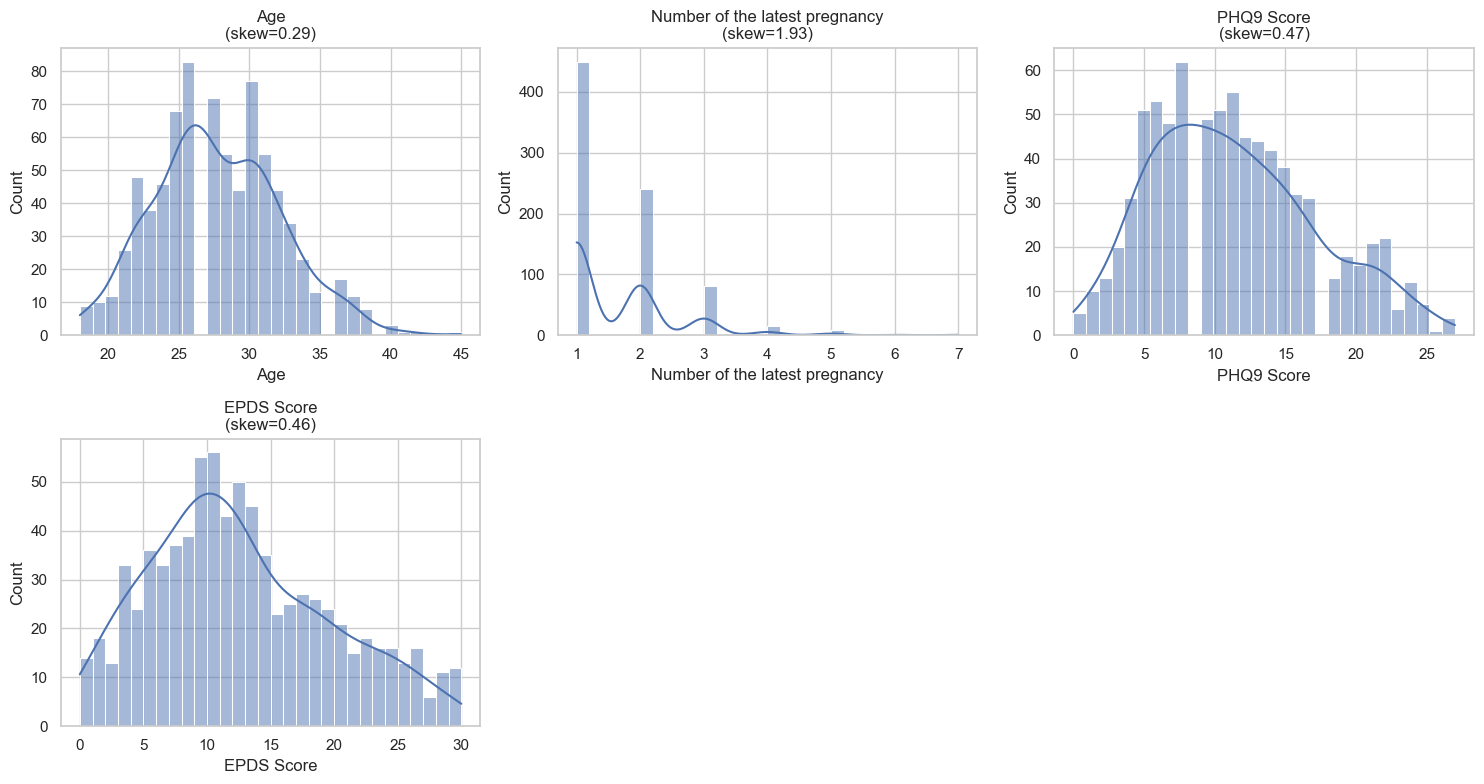

In [5]:
# Exclude 'sr' or similar non-informative numeric columns
num_cols_clean = [c for c in num_cols if c.lower() not in ['sr', 's.no', 'serial', 'id']]

# Plot histograms for numeric columns
n = len(num_cols_clean)
if n == 0:
    print("No numeric columns detected (after removing ID fields).")
else:
    ncols = 3
    nrows = (n + ncols - 1) // ncols
    plt.figure(figsize=(5 * ncols, 4 * nrows))
    for i, c in enumerate(num_cols_clean, 1):
        plt.subplot(nrows, ncols, i)
        sns.histplot(df[c].dropna(), kde=True, bins=30)
        plt.title(f"{c}\n(skew={df[c].dropna().skew():.2f})")
    plt.tight_layout()
    plt.show()


## Top 5 numeric plots (choosing & statistically explanating)

Top 5 numeric features (by variance): ['Age', 'Number of the latest pregnancy', 'PHQ9 Score', 'EPDS Score']


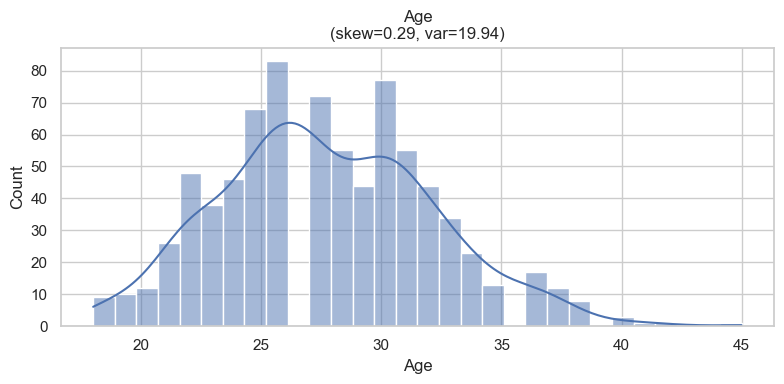

Summary for Age: mean=27.73, median=27.00, min=18.00, max=45.00, skew=0.29, var=19.94



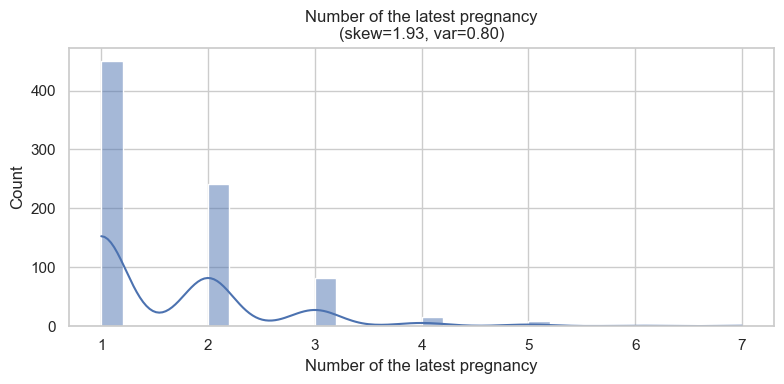

Summary for Number of the latest pregnancy: mean=1.63, median=1.00, min=1.00, max=7.00, skew=1.93, var=0.80



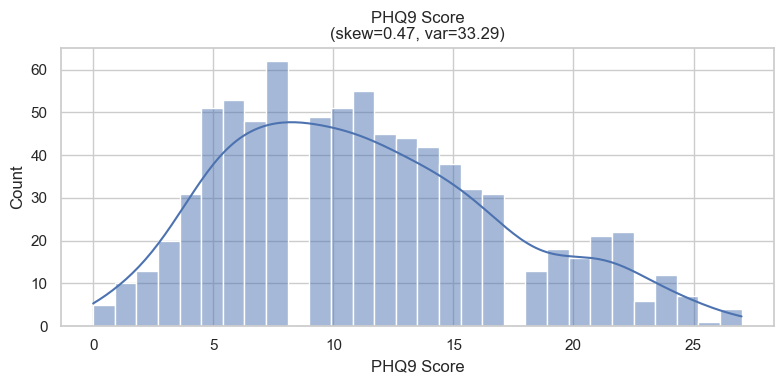

Summary for PHQ9 Score: mean=11.31, median=11.00, min=0.00, max=27.00, skew=0.47, var=33.29



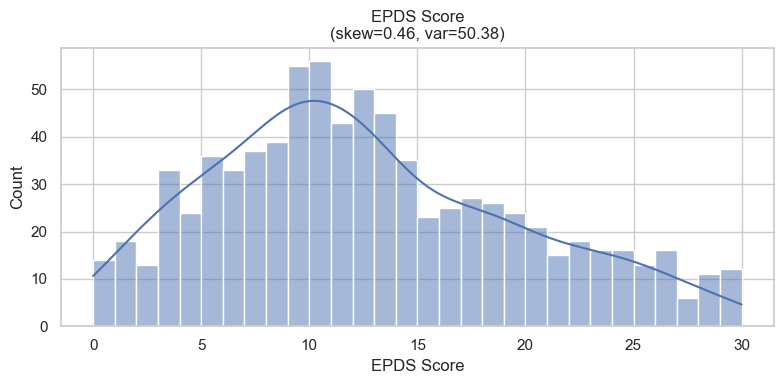

Summary for EPDS Score: mean=12.46, median=11.00, min=0.00, max=30.00, skew=0.46, var=50.38



In [6]:
# Replace 'target' with the actual target column name if known, e.g. 'PHQ9 Result' or 'EPDS Result'
target_col = 'EPDS Result' if 'EPDS Result' in df.columns else None  

# Identify ID-like non-informative numeric columns (plot them separately)
id_like = [c for c in num_cols if c.lower() in ['sr', 's.no', 'serial', 'id']]
num_cols_clean = [c for c in num_cols if c not in id_like]

# Select top 5 most important numeric features (by variance) from the informative set
if len(num_cols_clean) > 5:
    variances = df[num_cols_clean].var().sort_values(ascending=False)
    top5 = variances.head(5).index.tolist()
else:
    top5 = num_cols_clean

print("Top 5 numeric features (by variance):", top5)

# Plot each of the top-5 in its own figure for clearer inspection
for c in top5:
    data_c = df[c].dropna()
    skew_c = data_c.skew() if not data_c.empty else float('nan')
    var_c = data_c.var() if not data_c.empty else float('nan')
    mean_c = data_c.mean() if not data_c.empty else float('nan')
    median_c = data_c.median() if not data_c.empty else float('nan')
    min_c = data_c.min() if not data_c.empty else float('nan')
    max_c = data_c.max() if not data_c.empty else float('nan')
    plt.figure(figsize=(8,4))
    sns.histplot(data_c, kde=True, bins=30)
    plt.title(f"{c}\n(skew={skew_c:.2f}, var={var_c:.2f})")
    plt.tight_layout()
    plt.show()
    # quick textual explanation template
    print(f"Summary for {c}: mean={mean_c:.2f}, median={median_c:.2f}, min={min_c:.2f}, max={max_c:.2f}, skew={skew_c:.2f}, var={var_c:.2f}\n")

# Display ID-like / non-informative numeric columns separately with a clear title
if len(id_like) > 0:
    if len(id_like) == 1:
        c = id_like[0]
        plt.figure(figsize=(8,3))
        sns.histplot(df[c].dropna(), kde=False, bins=30)
        plt.title("non-informative numeric columns: " + c)
        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(6 * len(id_like), 4))
        for i, c in enumerate(id_like, 1):
            plt.subplot(1, len(id_like), i)
            sns.histplot(df[c].dropna(), kde=False, bins=30)
            plt.title(c)
        plt.suptitle("non-informative numeric columns")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


## Text Normalization & Fuzzy Deduplication (Preserve NaN/None)


In [7]:
# Smart Text Normalization & Fuzzy Deduplication (Preserve NaN/None)

if not has_rapidfuzz:
    print("⚠ Warning: Skipping fuzzy deduplication (rapidfuzz not installed).")
    print("  Install with: pip install rapidfuzz")
else:
    from rapidfuzz import process, fuzz
    
    df.columns = df.columns.str.encode('ascii', 'ignore').str.decode('ascii')
    plt.rcParams['font.family'] = 'DejaVu Sans'

    # --- STEP 1: Fix encoding issues ---
    def normalize_text(s):
        if isinstance(s, str):
            s = unicodedata.normalize('NFKD', s)
            s = s.replace(''', "'").replace(''', "'").replace('"', '"').replace('"', '"')
            return s.strip()
        return s

    df = df.map(normalize_text)

    # --- STEP 2: Identify categorical columns ---
    cat_cols = df.select_dtypes(exclude=['number', 'bool']).columns.tolist()

    # --- STEP 3: Clean casing, spaces, punctuation ---
    def clean_string(s):
        if isinstance(s, str):
            s = s.lower().strip()
            s = s.replace('-', ' ').replace('_', ' ')
            s = ' '.join(s.split())  # remove extra spaces
            return s
        return s

    for col in cat_cols:
        df[col] = df[col].map(clean_string)

    # --- STEP 4: Fuzzy deduplication preserving NaNs as a counted category ---
    def fuzzy_standardize_column(series, threshold=85, sentinel='NaN', keep_missing_label=True):
        """
        - Treat missing values as a category by filling with `sentinel` before matching.
        - If keep_missing_label=True the output will contain the sentinel string (so missing counts as a category).
          If False, sentinel is converted back to np.nan at the end (preserve NaN).
        """
        # Work on a filled series so missing is included in unique values
        filled = series.fillna(sentinel).astype(object)
        # Process values in descending frequency so the most common form becomes canonical
        unique_vals = pd.Series(filled.value_counts().index.tolist())
        mapping = {}

        for val in unique_vals:
            # first mapped value becomes canonical
            if not mapping:
                mapping[val] = val
                continue
            # fuzzy match against existing canonical keys
            result = process.extractOne(val, list(mapping.keys()), scorer=fuzz.ratio)
            match, score = result[:2]     # take only first two items

            if score >= threshold:
                mapping[val] = match
            else:
                mapping[val] = val

        # apply mapping to filled series
        mapped = filled.map(mapping)

        # optionally convert sentinel back to np.nan to preserve original NaN semantics
        if not keep_missing_label:
            mapped = mapped.replace({sentinel: np.nan})

        return mapped, mapping

    # --- STEP 5: Apply fuzzy matching (keep_missing_label=True to count missing as a unique category) ---
    for col in cat_cols:
        print(f"\nCleaning column: {col}")
        # count uniques including missing by using fillna(sentinel)
        before_unique = df[col].fillna('NaN').unique()
        before_count = len([x for x in before_unique if x is not None])
        df[col], mapping = fuzzy_standardize_column(df[col], threshold=85, sentinel='NaN', keep_missing_label=True)
        after_unique = df[col].fillna('NaN').unique()
        n_before = len([x for x in before_unique if pd.notna(x)])
        n_after = len([x for x in after_unique if pd.notna(x)])
        print(f"  Unique before (counting missing): {n_before} → after: {n_after}")
        print("  Example mappings (changed values):")
        shown = 0
        for k, v in mapping.items():
            if k != v:
                print(f"    '{k}' → '{v}'")
                shown += 1
                if shown >= 6:
                    break

    # --- STEP 6: Check for non-ASCII characters ---
    for col in cat_cols:
        bad_chars = df[col].astype(str).str.contains(r'[^\x00-\x7F]', regex=True)
        if bad_chars.any():
            print(f"Warning: Non-ASCII characters remain in column '{col}'")

    print("\nNormalization & fuzzy deduplication complete (missing values can be counted as a category).")



Cleaning column: Residence
  Unique before (counting missing): 2 → after: 2
  Example mappings (changed values):

Cleaning column: Education Level
  Unique before (counting missing): 5 → after: 5
  Example mappings (changed values):

Cleaning column: Marital status
  Unique before (counting missing): 2 → after: 2
  Example mappings (changed values):

Cleaning column: Occupation before latest pregnancy
  Unique before (counting missing): 8 → after: 7
  Example mappings (changed values):
    'house wife' → 'housewife'

Cleaning column: Monthly income before latest pregnancy
  Unique before (counting missing): 6 → after: 5
  Example mappings (changed values):
    '20000 to 30000' → '10000 to 20000'

Cleaning column: Occupation After Your Latest Childbirth
  Unique before (counting missing): 8 → after: 7
  Example mappings (changed values):
    'house wife' → 'housewife'

Cleaning column: Current monthly income
  Unique before (counting missing): 6 → after: 5
  Example mappings (changed v

## Individual Bar Chart for the categorical features

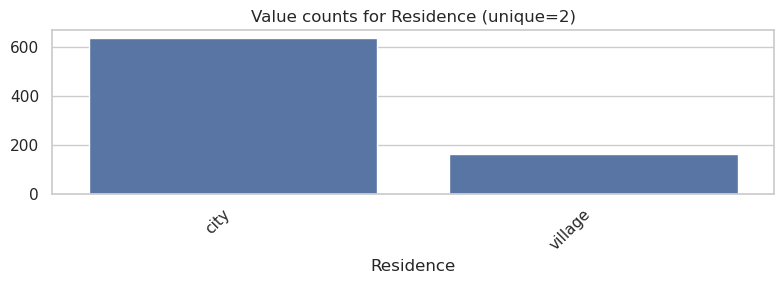

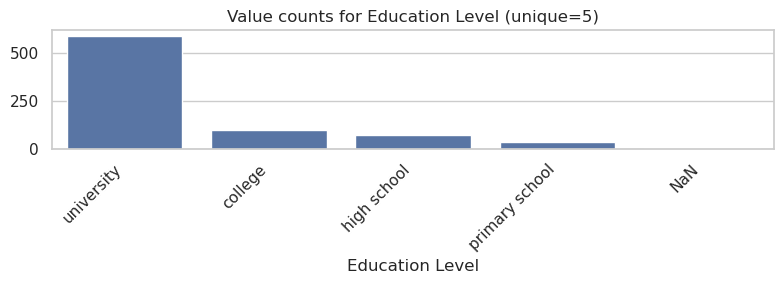

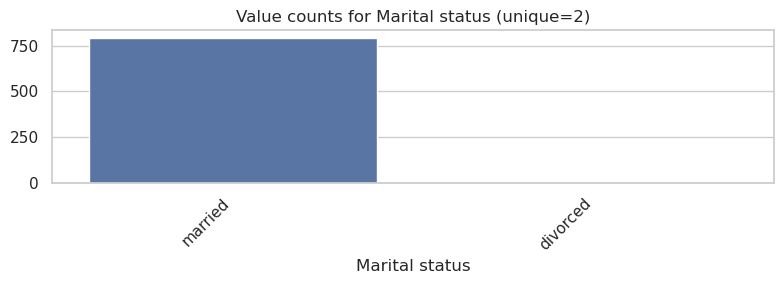

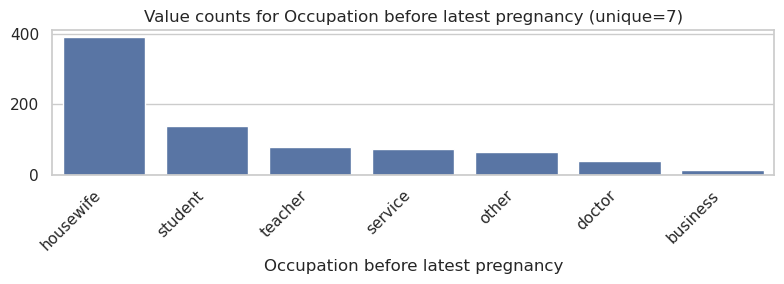

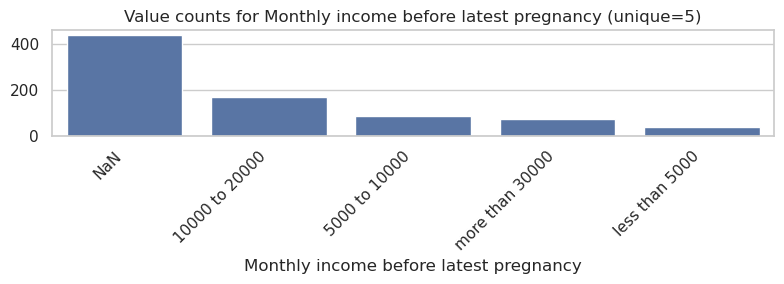

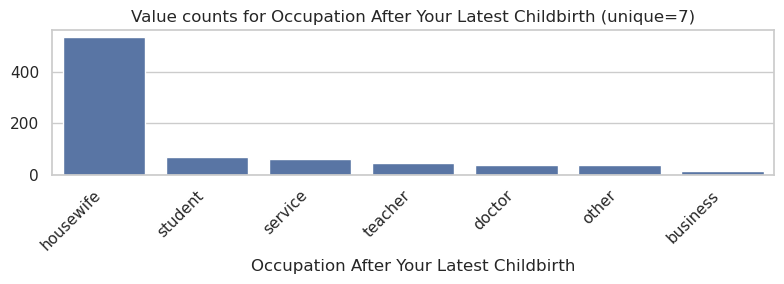

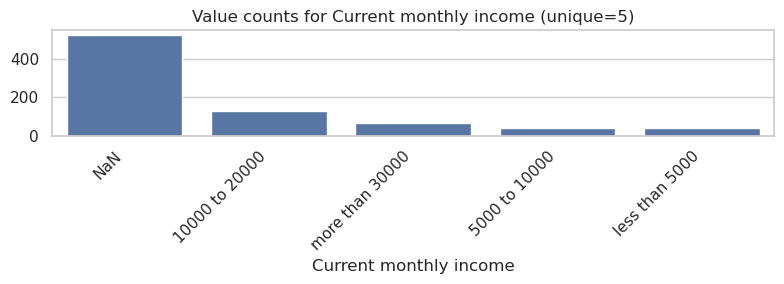

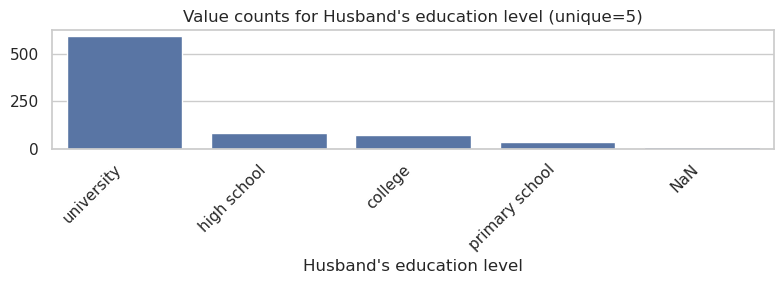

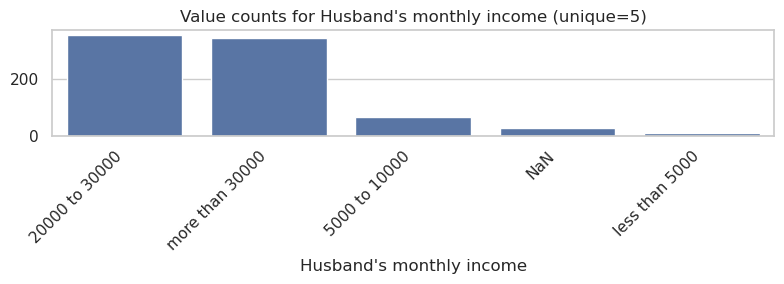

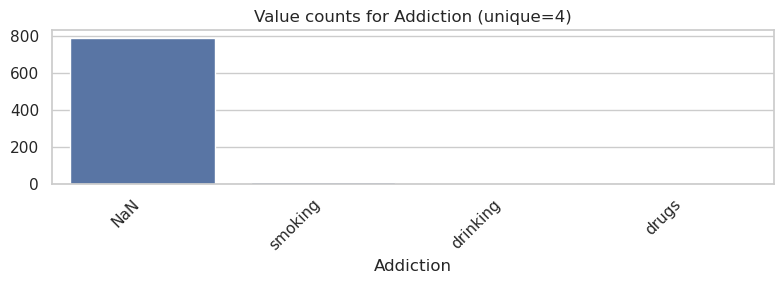

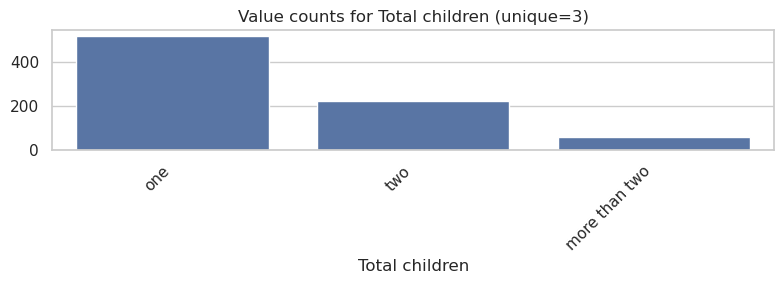

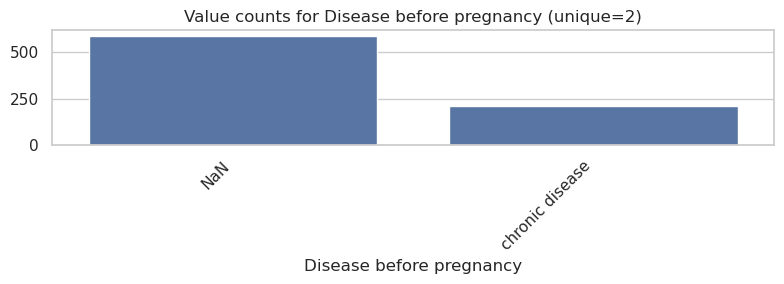

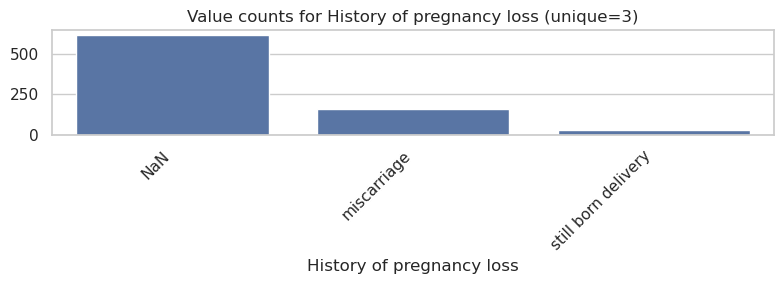

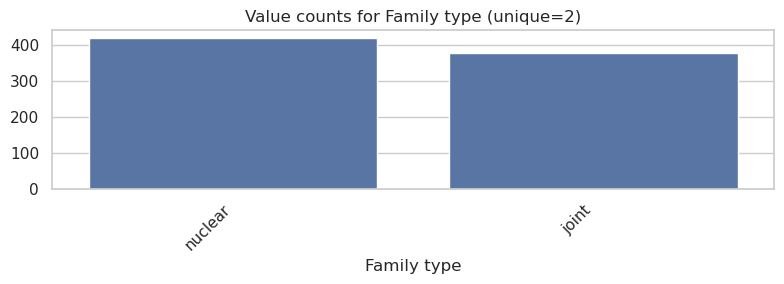

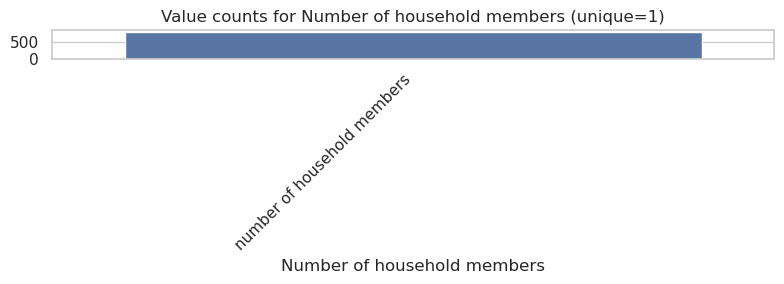

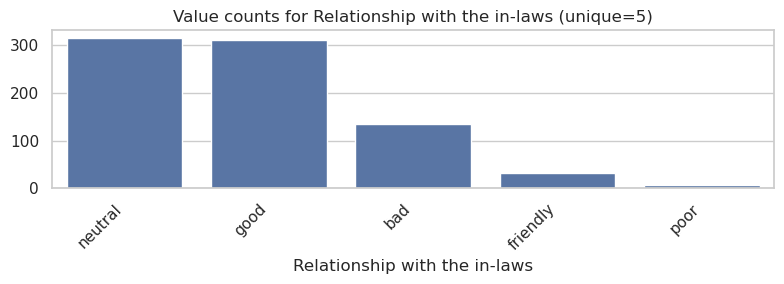

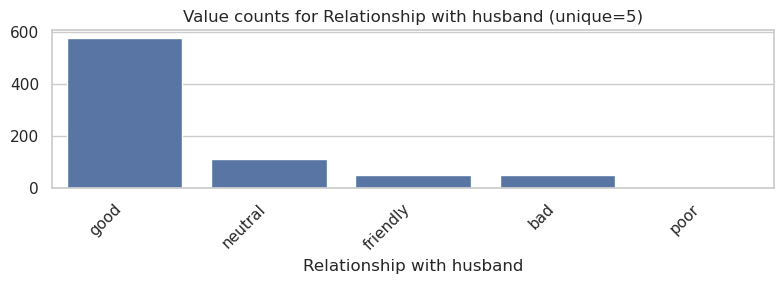

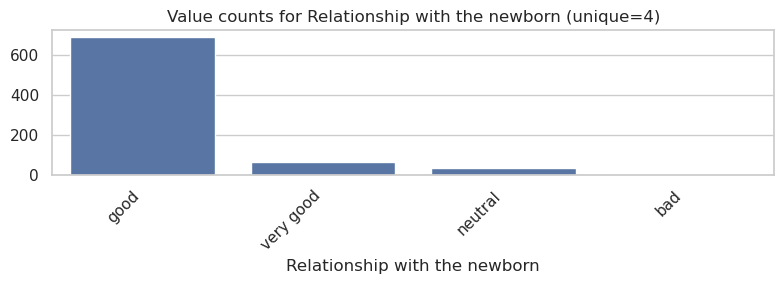

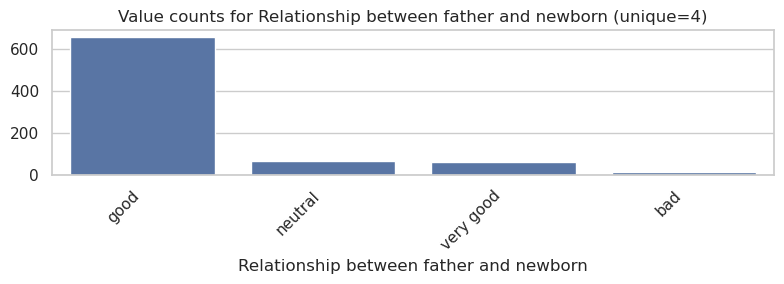

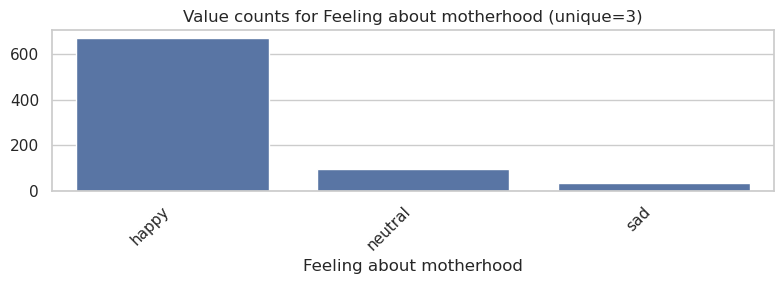

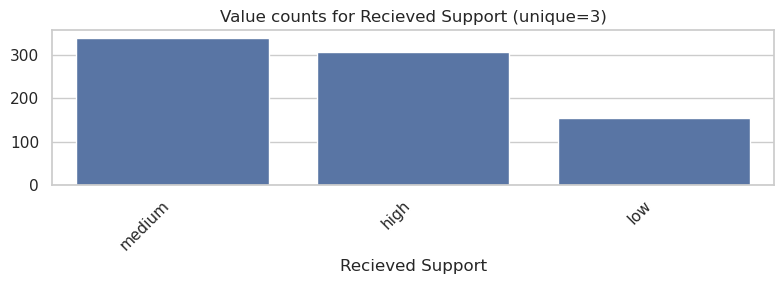

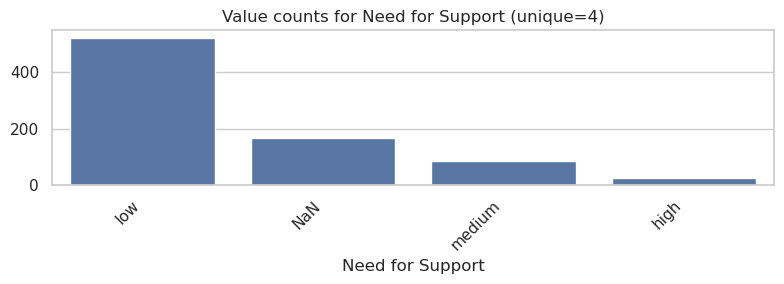

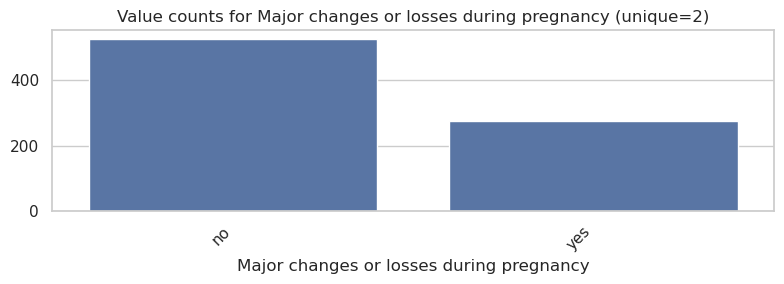

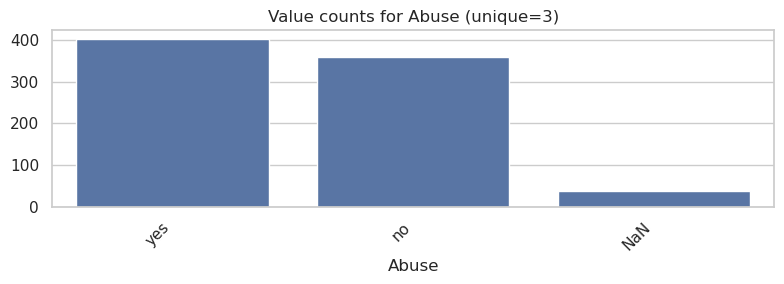

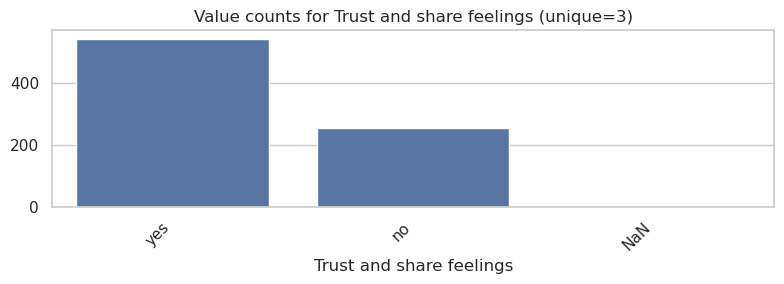

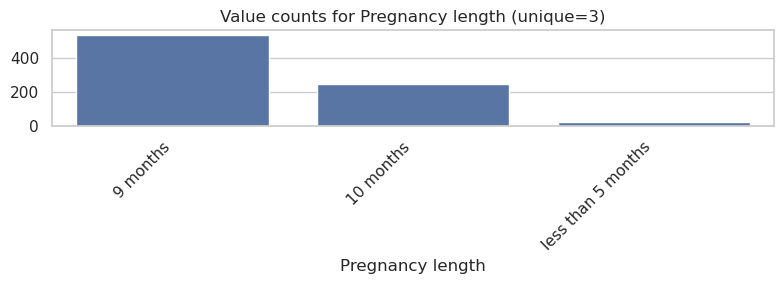

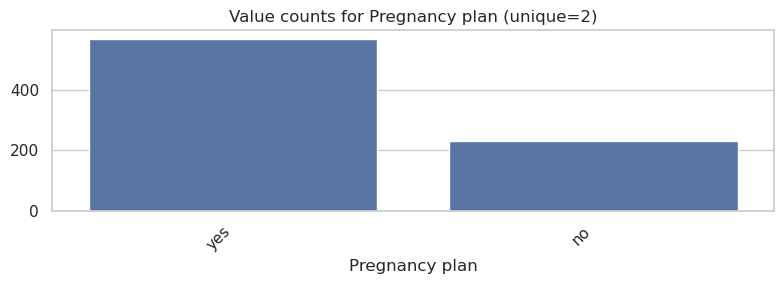

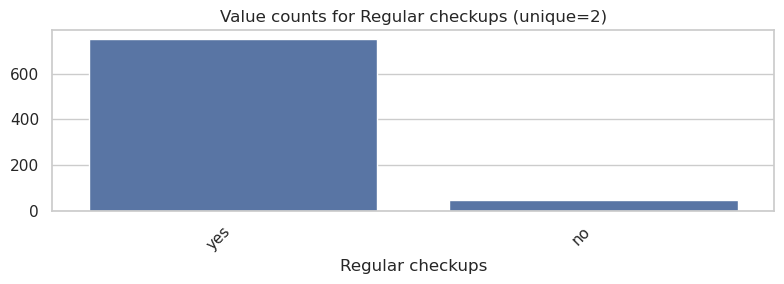

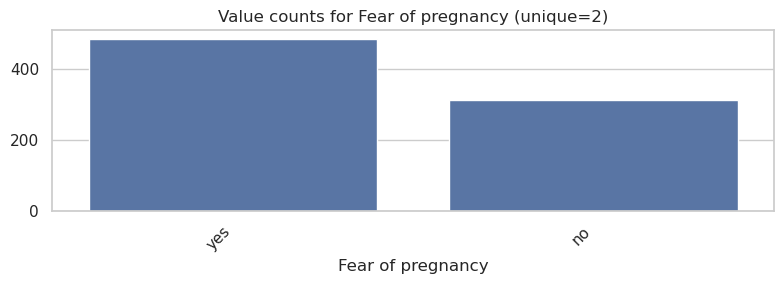

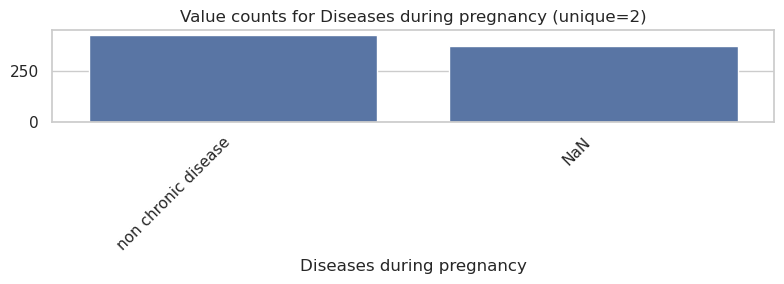

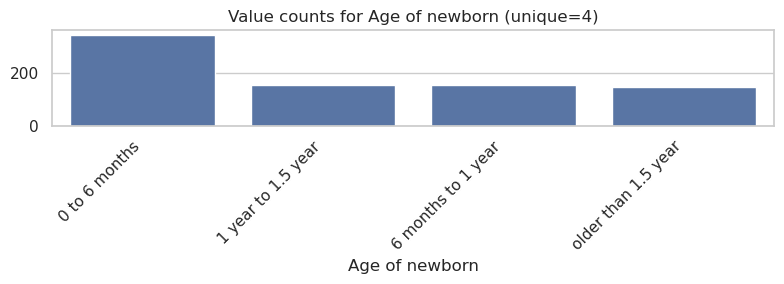

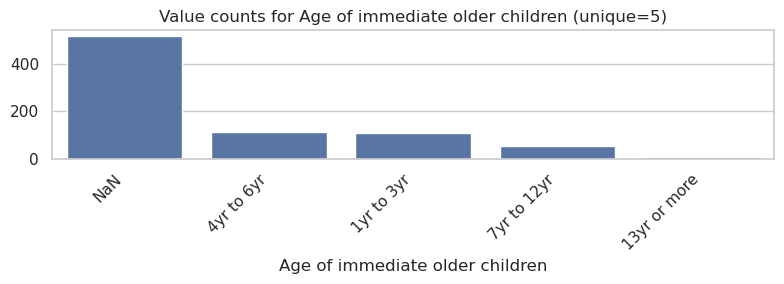

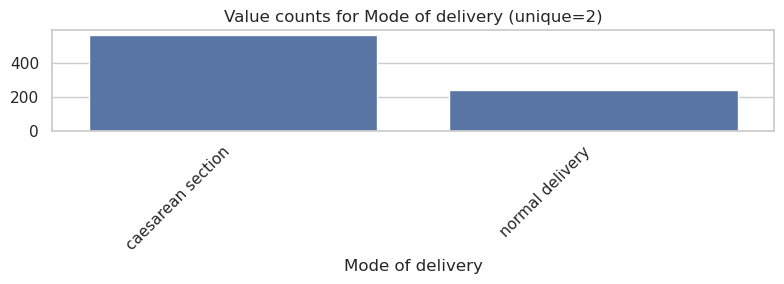

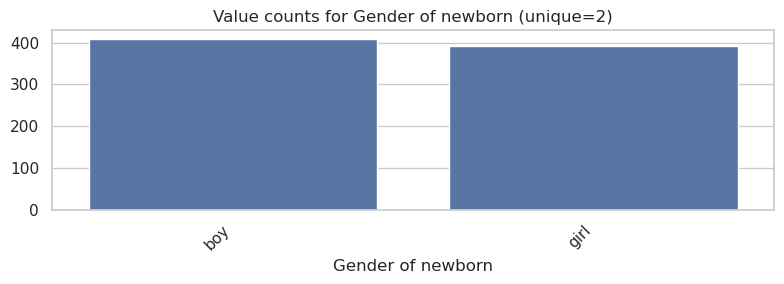

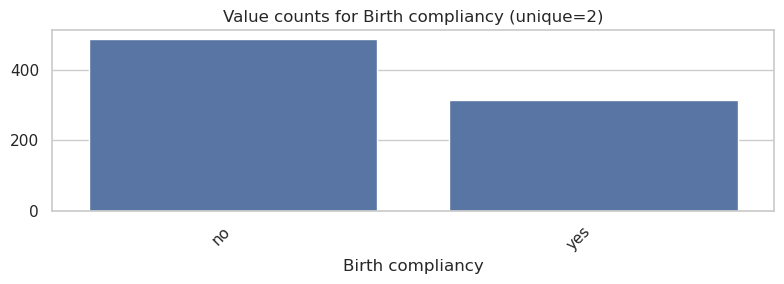

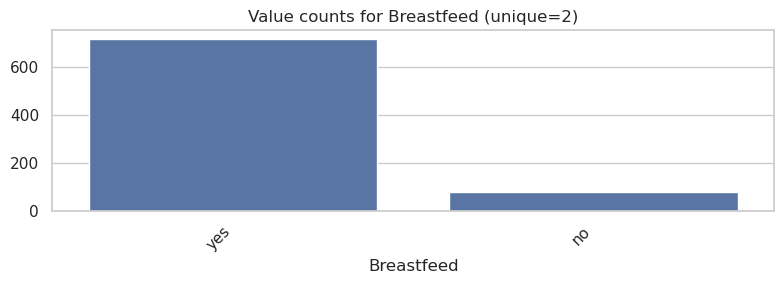

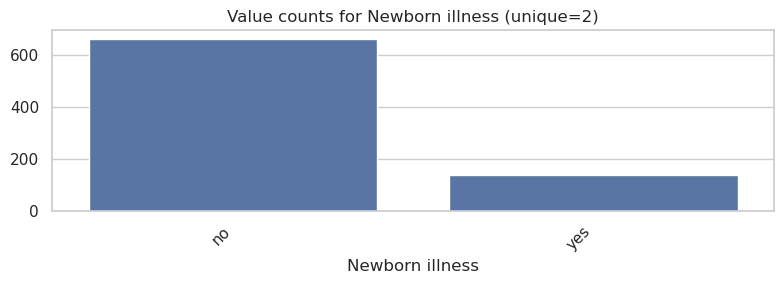

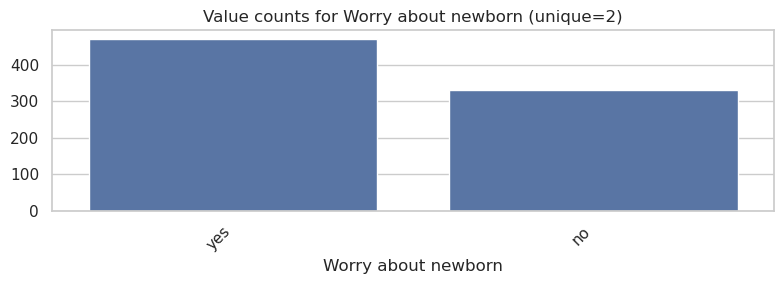

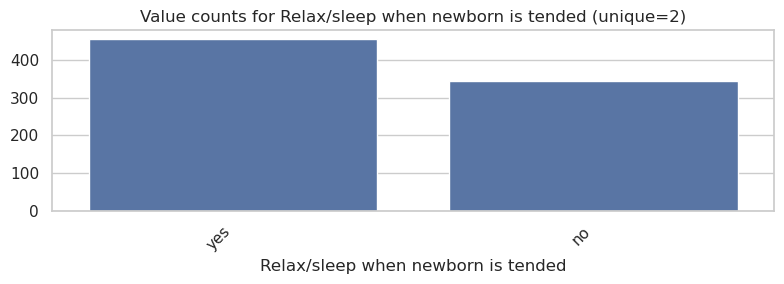

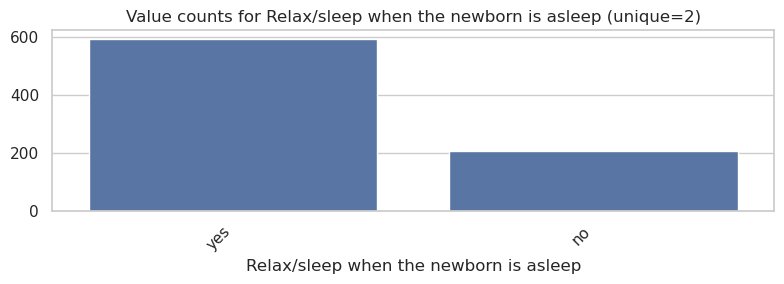

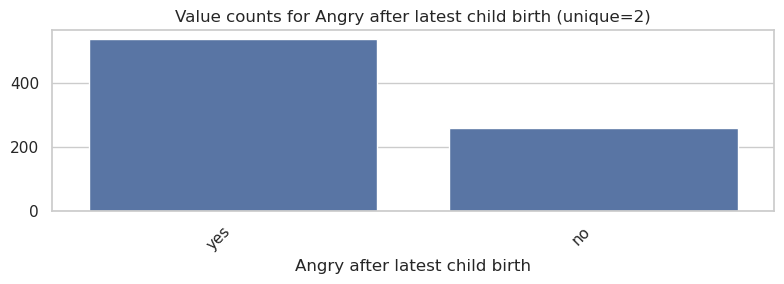

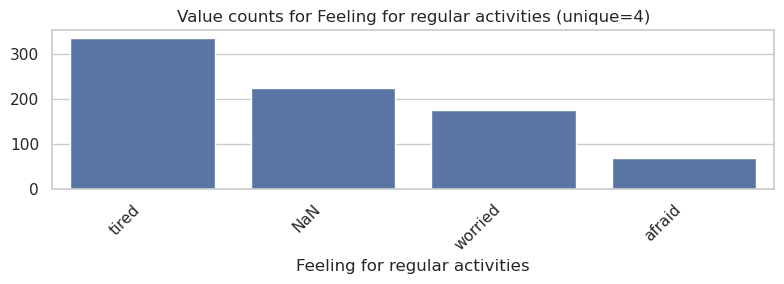

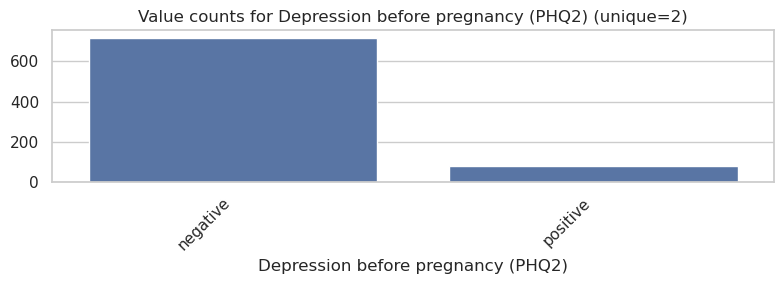

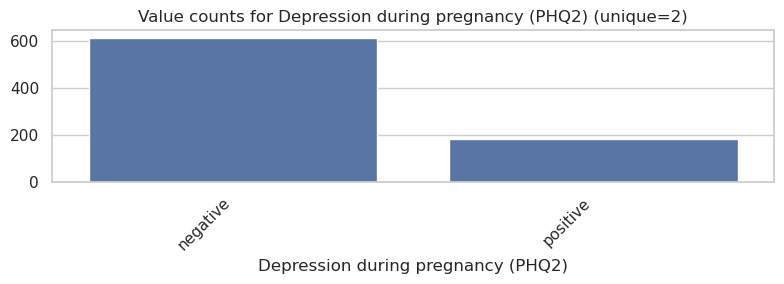

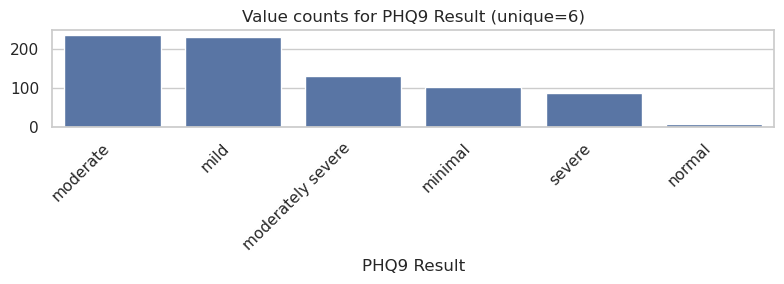

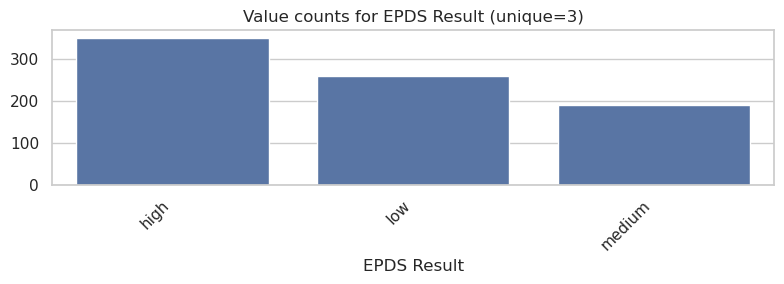

In [8]:
# For categorical features: value counts
if len(cat_cols) == 0:
    print("No categorical columns detected.")
else:
    for c in cat_cols:
        vc = df[c].value_counts(dropna=False)
        # limit plotting for very high-cardinality columns
        plt.figure(figsize=(8,3))
        if len(vc) <= 30:
            sns.barplot(x=vc.index.astype(str), y=vc.values)
            plt.xticks(rotation=45, ha='right')
        else:
            # show top 20 categories
            sns.barplot(x=vc.head(20).index.astype(str), y=vc.head(20).values)
            plt.xticks(rotation=45, ha='right')
        plt.title(f"Value counts for {c} (unique={df[c].nunique()})")
        plt.tight_layout()
        plt.show()


## Top 5 categorical plots (choosing & explaining including statistics)


Top-5 categorical columns selected for PPD analysis: ['Feeling about motherhood', 'Relationship with husband', 'History of pregnancy loss', 'Recieved Support', 'Depression during pregnancy (PHQ2)']


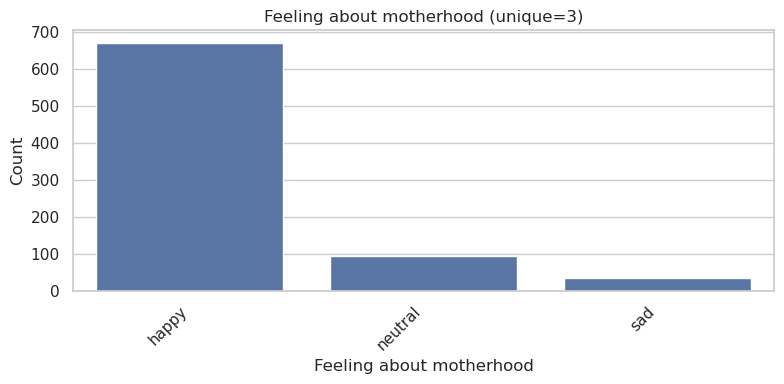


Explanation:
Maternal feelings toward the newborn and self-efficacy are direct psychological indicators of vulnerability.

--------------------------------------------------------------------------------

Value counts for 'Feeling about motherhood':
Feeling about motherhood
happy      671
neutral     94
sad         35
Name: count, dtype: int64

Normalized (proportion) counts:
Feeling about motherhood
happy      0.839
neutral    0.118
sad        0.044
Name: proportion, dtype: float64

--------------------------------------------------



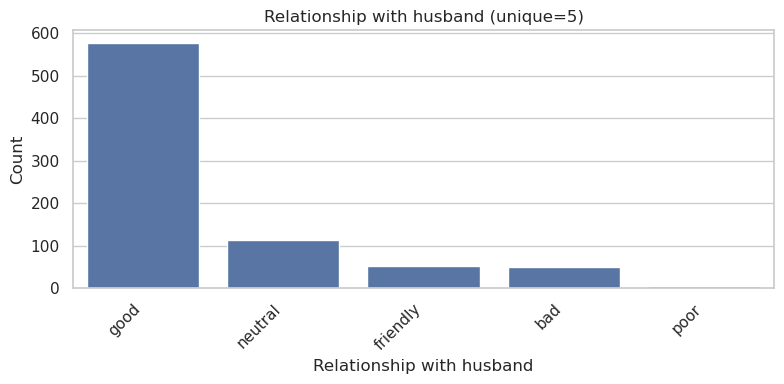


Explanation:
Marital relationship quality is crucial in Bangladeshi households where extended family often influences daily life.

--------------------------------------------------------------------------------

Value counts for 'Relationship with husband':
Relationship with husband
good        578
neutral     113
friendly     52
bad          51
poor          6
Name: count, dtype: int64

Normalized (proportion) counts:
Relationship with husband
good        0.722
neutral     0.141
friendly    0.065
bad         0.064
poor        0.008
Name: proportion, dtype: float64

--------------------------------------------------



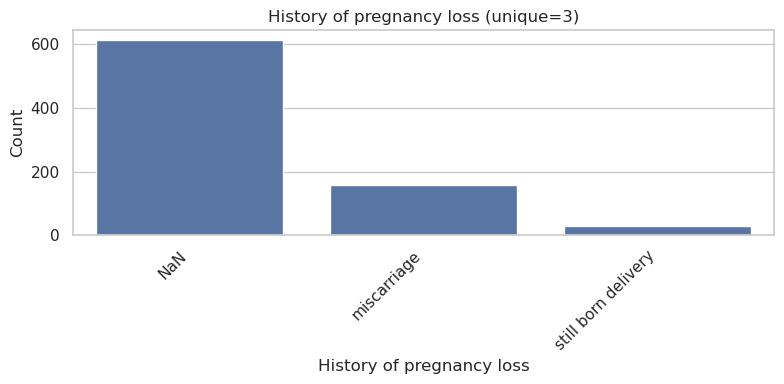


Explanation:
Prior loss is stressful and can increase anxiety and PPD risk.

--------------------------------------------------------------------------------

Value counts for 'History of pregnancy loss':
History of pregnancy loss
NaN                    613
miscarriage            158
still born delivery     29
Name: count, dtype: int64

Normalized (proportion) counts:
History of pregnancy loss
NaN                    0.766
miscarriage            0.198
still born delivery    0.036
Name: proportion, dtype: float64

--------------------------------------------------



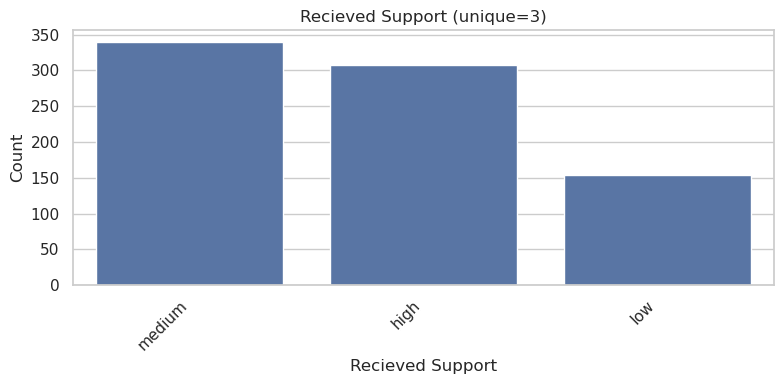


Explanation:
Social support (from husband, family, friends) buffers against PPD.

--------------------------------------------------------------------------------

Value counts for 'Recieved Support':
Recieved Support
medium    339
high      307
low       154
Name: count, dtype: int64

Normalized (proportion) counts:
Recieved Support
medium    0.424
high      0.384
low       0.192
Name: proportion, dtype: float64

--------------------------------------------------



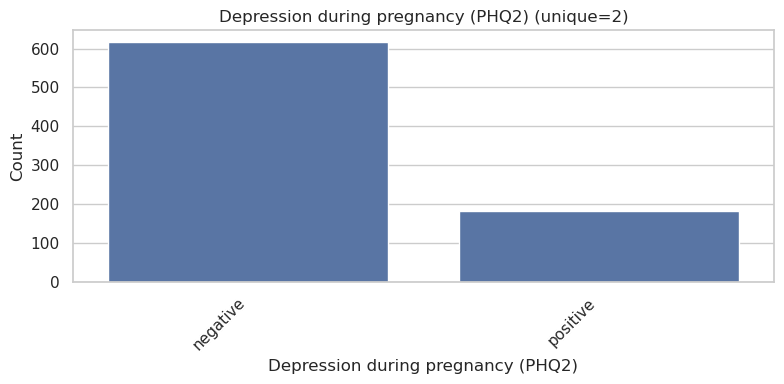


Explanation:
Pre-existing or concurrent depression is the strongest predictor of PPD.

--------------------------------------------------------------------------------

Value counts for 'Depression during pregnancy (PHQ2)':
Depression during pregnancy (PHQ2)
negative    616
positive    184
Name: count, dtype: int64

Normalized (proportion) counts:
Depression during pregnancy (PHQ2)
negative    0.77
positive    0.23
Name: proportion, dtype: float64

--------------------------------------------------



In [9]:
# --- Top 5 conceptually relevant categorical plots for PPD detection ---
top5_cat = [
    'Feeling about motherhood',
    'Relationship with husband',
    'History of pregnancy loss',
    'Recieved Support',
    'Depression during pregnancy (PHQ2)'
]
# Explanations dictionary
explanations = {
    'Depression during pregnancy (PHQ2)': "Pre-existing or concurrent depression is the strongest predictor of PPD.",
    'Recieved Support': "Social support (from husband, family, friends) buffers against PPD.",
    'Relationship with husband': "Marital relationship quality is crucial in Bangladeshi households where extended family often influences daily life.",
    'History of pregnancy loss': "Prior loss is stressful and can increase anxiety and PPD risk.",
    'Feeling about motherhood': "Maternal feelings toward the newborn and self-efficacy are direct psychological indicators of vulnerability."
}

print("Top-5 categorical columns selected for PPD analysis:", top5_cat)

for c in top5_cat:
    vc = df[c].value_counts(dropna=False)
    vc_norm = df[c].value_counts(normalize=True).round(3)
    
    plt.figure(figsize=(8,4))
    sns.barplot(x=vc.index.astype(str), y=vc.values)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Count")
    plt.title(f"{c} (unique={df[c].nunique()})")
    plt.tight_layout()
    plt.show()

        # Print explanation
    print("\nExplanation:")
    print(explanations[c])
    
    print("\n" + "-"*80 + "\n")
    
    print(f"Value counts for '{c}':")
    print(vc)
    print("\nNormalized (proportion) counts:")
    print(vc_norm)
    print("\n" + "-"*50 + "\n")


## Categorical vs Categorical


Analyzing 'Feeling about motherhood' vs EPDS Result

Cross-tabulation:


EPDS Result               high  low  medium
Feeling about motherhood                   
happy                      254  247     170
neutral                     62   13      19
sad                         34    0       1


Normalized proportions (row-wise):


EPDS Result                high    low  medium
Feeling about motherhood                      
happy                     0.379  0.368   0.253
neutral                   0.660  0.138   0.202
sad                       0.971  0.000   0.029

Explanation for 'Feeling about motherhood': Maternal feelings toward the newborn and self-efficacy are direct psychological indicators of vulnerability.

--------------------------------------------------------------------------------

Analyzing 'Relationship with husband' vs EPDS Result

Cross-tabulation:


EPDS Result                high  low  medium
Relationship with husband                   
bad                          48    1       2
friendly                     11   29      12
good                        216  207     155
neutral                      71   22      20
poor                          4    1       1


Normalized proportions (row-wise):


EPDS Result                 high    low  medium
Relationship with husband                      
bad                        0.941  0.020   0.039
friendly                   0.212  0.558   0.231
good                       0.374  0.358   0.268
neutral                    0.628  0.195   0.177
poor                       0.667  0.167   0.167

Explanation for 'Relationship with husband': Marital relationship quality is crucial in Bangladeshi households where extended family often influences daily life.

--------------------------------------------------------------------------------

Analyzing 'History of pregnancy loss' vs EPDS Result

Cross-tabulation:


EPDS Result                high  low  medium
History of pregnancy loss                   
NaN                         266  199     148
miscarriage                  73   51      34
still born delivery          11   10       8


Normalized proportions (row-wise):


EPDS Result                 high    low  medium
History of pregnancy loss                      
NaN                        0.434  0.325   0.241
miscarriage                0.462  0.323   0.215
still born delivery        0.379  0.345   0.276

Explanation for 'History of pregnancy loss': Prior loss is stressful and can increase anxiety and PPD risk.

--------------------------------------------------------------------------------

Analyzing 'Recieved Support' vs EPDS Result

Cross-tabulation:


EPDS Result       high  low  medium
Recieved Support                   
high                83  143      81
low                 88   41      25
medium             179   76      84


Normalized proportions (row-wise):


EPDS Result        high    low  medium
Recieved Support                      
high              0.270  0.466   0.264
low               0.571  0.266   0.162
medium            0.528  0.224   0.248

Explanation for 'Recieved Support': Social support (from husband, family, friends) buffers against PPD.

--------------------------------------------------------------------------------

Analyzing 'Depression during pregnancy (PHQ2)' vs EPDS Result

Cross-tabulation:


EPDS Result                         high  low  medium
Depression during pregnancy (PHQ2)                   
negative                             242  231     143
positive                             108   29      47


Normalized proportions (row-wise):


EPDS Result                          high    low  medium
Depression during pregnancy (PHQ2)                      
negative                            0.393  0.375   0.232
positive                            0.587  0.158   0.255

Explanation for 'Depression during pregnancy (PHQ2)': Pre-existing or concurrent depression is the strongest predictor of PPD.

--------------------------------------------------------------------------------



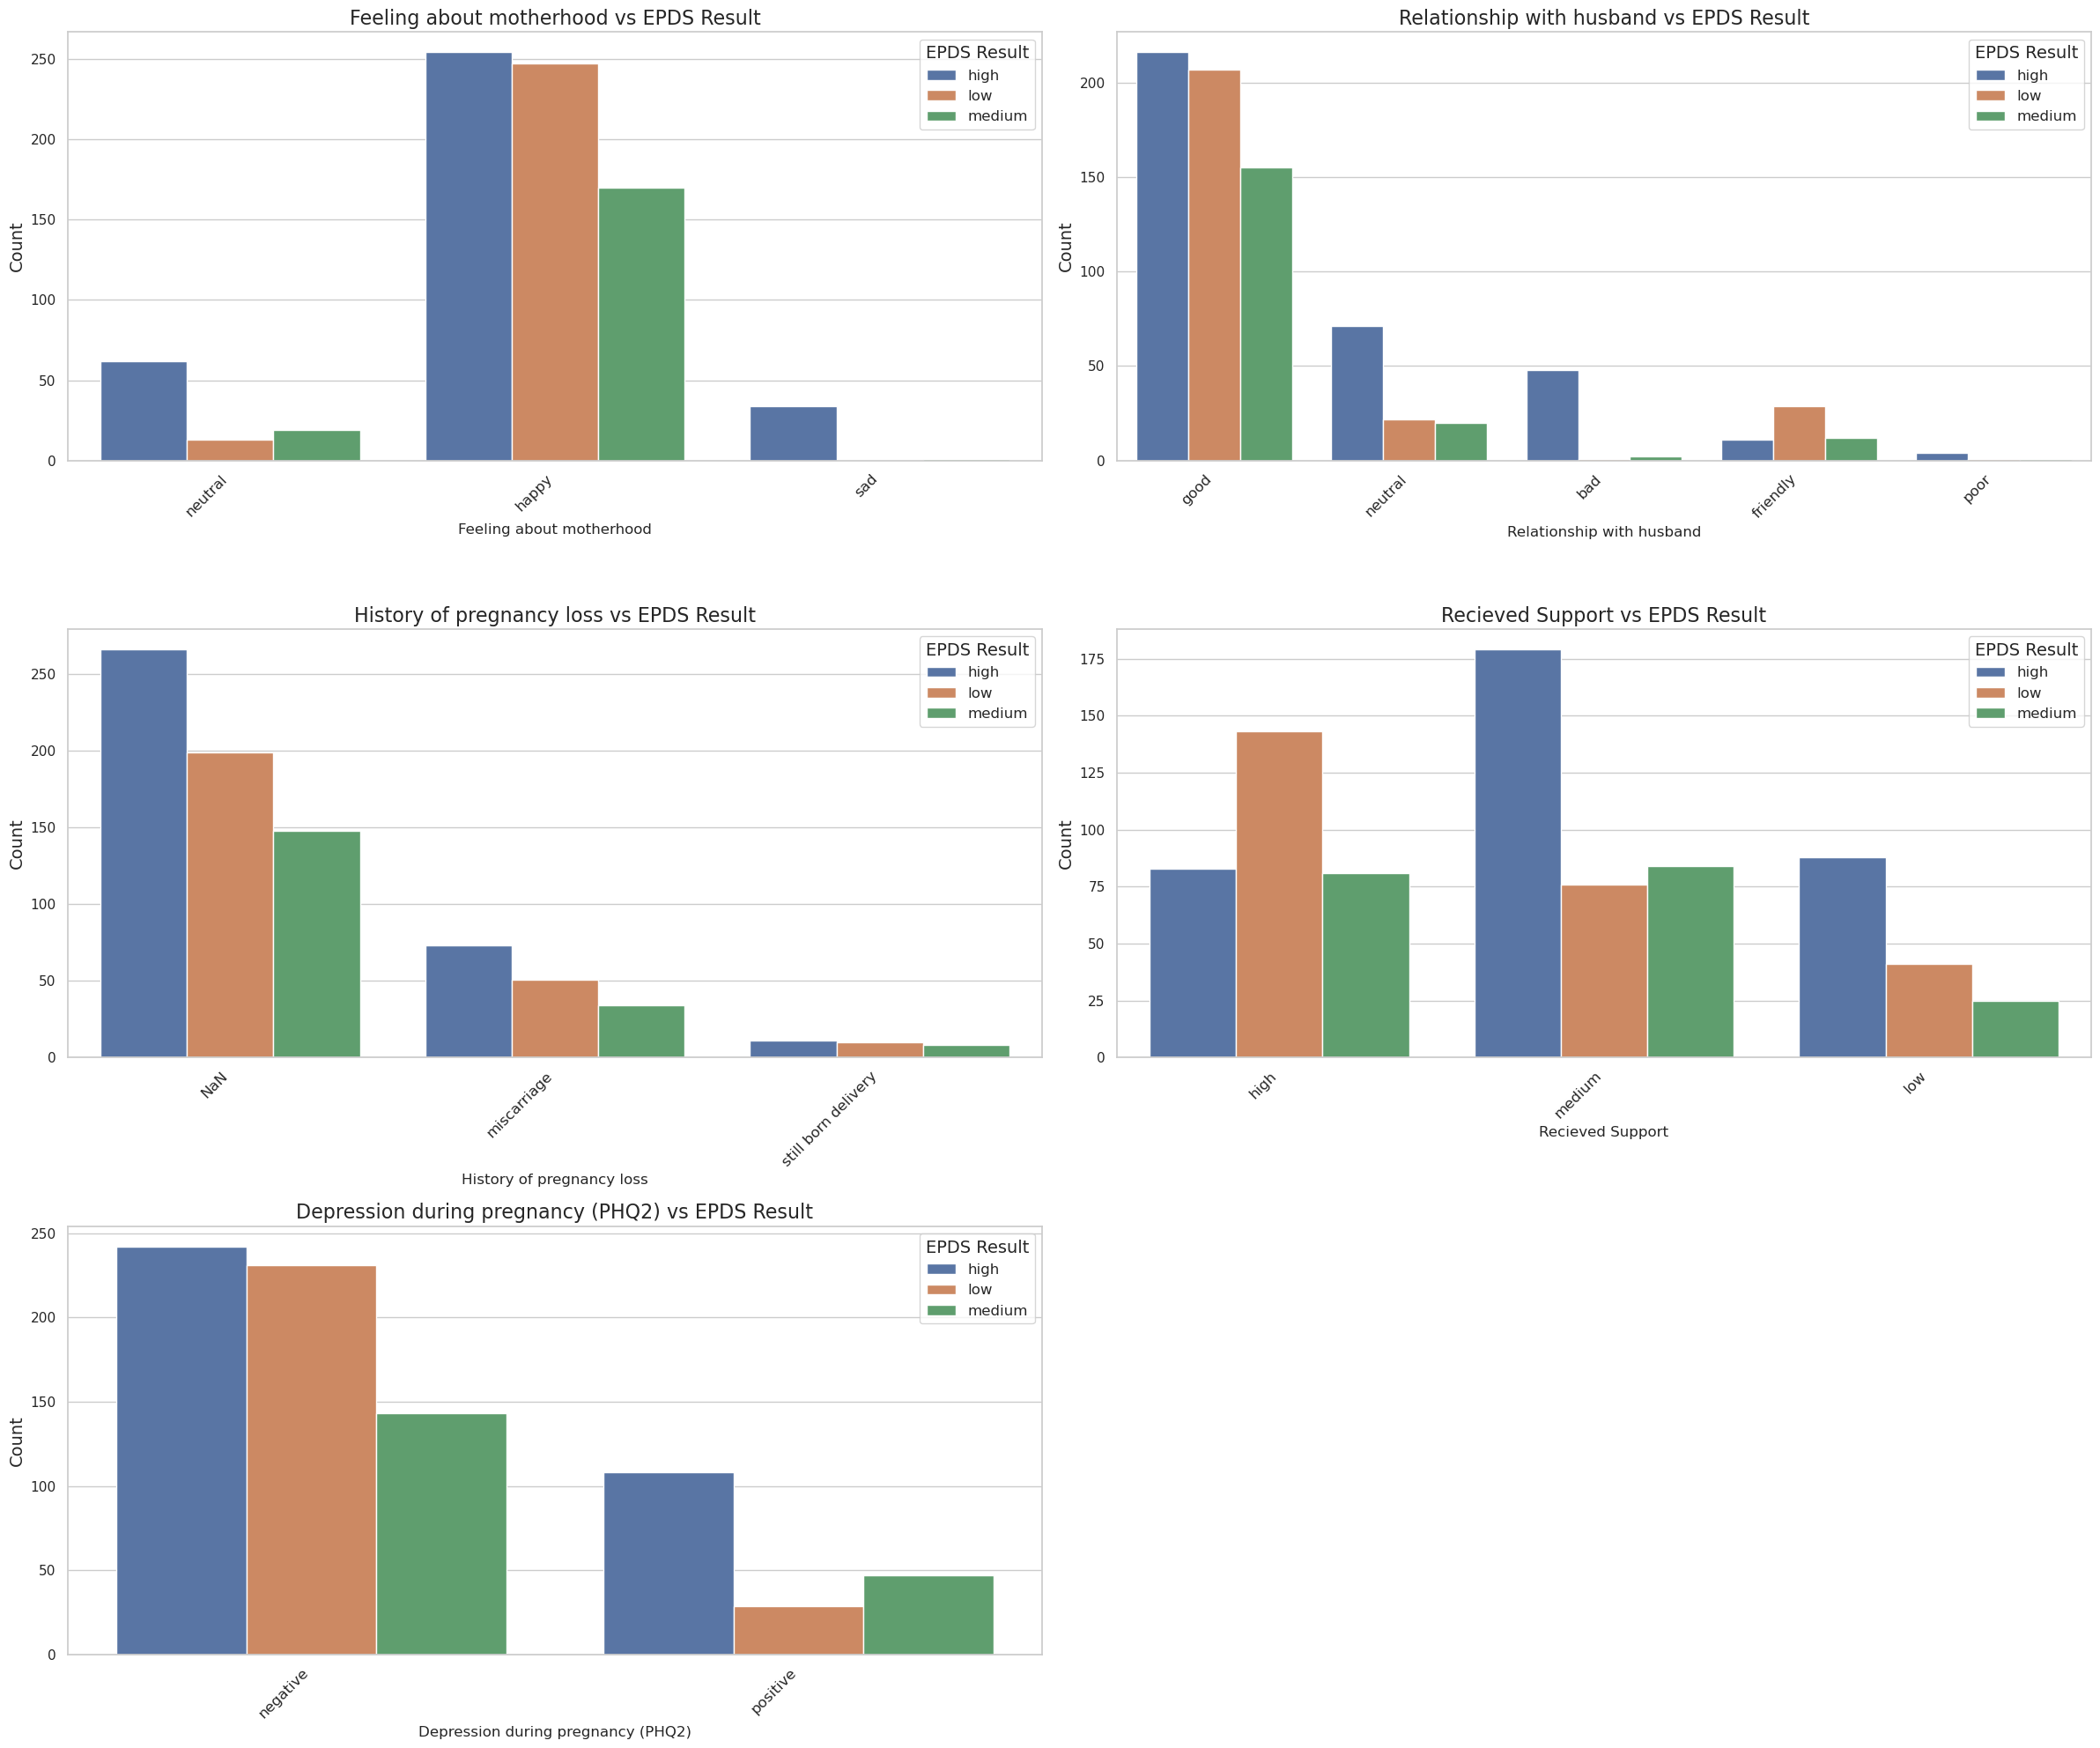

In [10]:
# --- Categorical vs Categorical analysis for PPD (single figure, blue/orange) ---
target_col = 'EPDS Result'

# Increase figure size for readability
fig, axes = plt.subplots(3, 2, figsize=(24, 20))  # bigger width & height
axes = axes.flatten()

for i, c in enumerate(top5_cat):
    ax = axes[i]
    
    # Countplot
    sns.countplot(data=df, x=c, hue=target_col, ax=ax)
    
    # Rotate x-axis labels safely
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
    
    # Improve y-axis and title font sizes
    ax.set_ylabel("Count", fontsize=14)
    ax.set_title(f"{c} vs {target_col}", fontsize=16)
    
    # Legend fonts
    ax.legend(title=target_col, fontsize=12, title_fontsize=14)
    
    # --- Text outputs below each subplot ---
    print(f"Analyzing '{c}' vs {target_col}")
    
    # Cross-tabulation
    ct = pd.crosstab(df[c], df[target_col])
    print("\nCross-tabulation:")
    display(ct)
    
    # Normalized proportions
    ct_norm = pd.crosstab(df[c], df[target_col], normalize='index').round(3)
    print("\nNormalized proportions (row-wise):")
    display(ct_norm)
    
    # Explanation printed below tables
    print(f"Explanation for '{c}': {explanations[c]}")
    print("\n" + "-"*80 + "\n")

# Remove empty subplot if exists
if len(top5_cat) < len(axes):
    for j in range(len(top5_cat), len(axes)):
        fig.delaxes(axes[j])

# Adjust spacing between subplots
plt.tight_layout()
plt.show()


## Categorical vs Numerical


Analyzing 'Age' vs 


count       mean       std   min    25%   50%   75%  \
Feeling about motherhood                                                        
happy                     671.0  27.570790  4.434328  18.0  25.00  27.0  30.5   
neutral                    94.0  28.968085  4.466006  21.0  25.25  29.0  32.0   
sad                        35.0  27.342857  4.658596  18.0  24.00  26.0  30.0   

                           max  
Feeling about motherhood        
happy                     45.0  
neutral                   42.0  
sad                       40.0


----------------------------------------------------------------------------------------------------



count       mean       std   min   25%   50%  \
Relationship with husband                                                 
bad                         51.0  27.568627  3.556711  18.0  26.0  28.0   
friendly                    52.0  25.903846  4.521234  18.0  22.0  26.0   
good                       578.0  27.683391  4.388235  18.0  25.0  27.0   
neutral                    113.0  28.752212  4.943486  18.0  25.0  28.0   
poor                         6.0  29.500000  4.415880  25.0  26.0  28.5   

                             75%   max  
Relationship with husband               
bad                        30.00  35.0  
friendly                   28.00  37.0  
good                       31.00  41.0  
neutral                    32.00  45.0  
poor                       33.25  35.0


----------------------------------------------------------------------------------------------------



count       mean       std   min   25%   50%   75%  \
History of pregnancy loss                                                       
NaN                        613.0  27.306688  4.408908  18.0  24.0  27.0  30.0   
miscarriage                158.0  29.006329  4.283722  18.0  26.0  30.0  32.0   
still born delivery         29.0  29.586207  4.960683  22.0  26.0  30.0  33.0   

                            max  
History of pregnancy loss        
NaN                        45.0  
miscarriage                40.0  
still born delivery        40.0


----------------------------------------------------------------------------------------------------



count       mean       std   min   25%   50%    75%   max
Recieved Support                                                           
high              307.0  26.957655  4.420115  18.0  24.0  27.0  30.00  45.0
low               154.0  28.487013  4.865830  18.0  25.0  28.0  31.75  42.0
medium            339.0  28.073746  4.220672  18.0  25.0  28.0  31.00  41.0


----------------------------------------------------------------------------------------------------



count       mean       std   min   25%  \
Depression during pregnancy (PHQ2)                                           
negative                            616.0  27.824675  4.552327  18.0  25.0   
positive                            184.0  27.391304  4.156650  18.0  25.0   

                                     50%   75%   max  
Depression during pregnancy (PHQ2)                    
negative                            27.0  31.0  45.0  
positive                            27.0  30.0  40.0


----------------------------------------------------------------------------------------------------



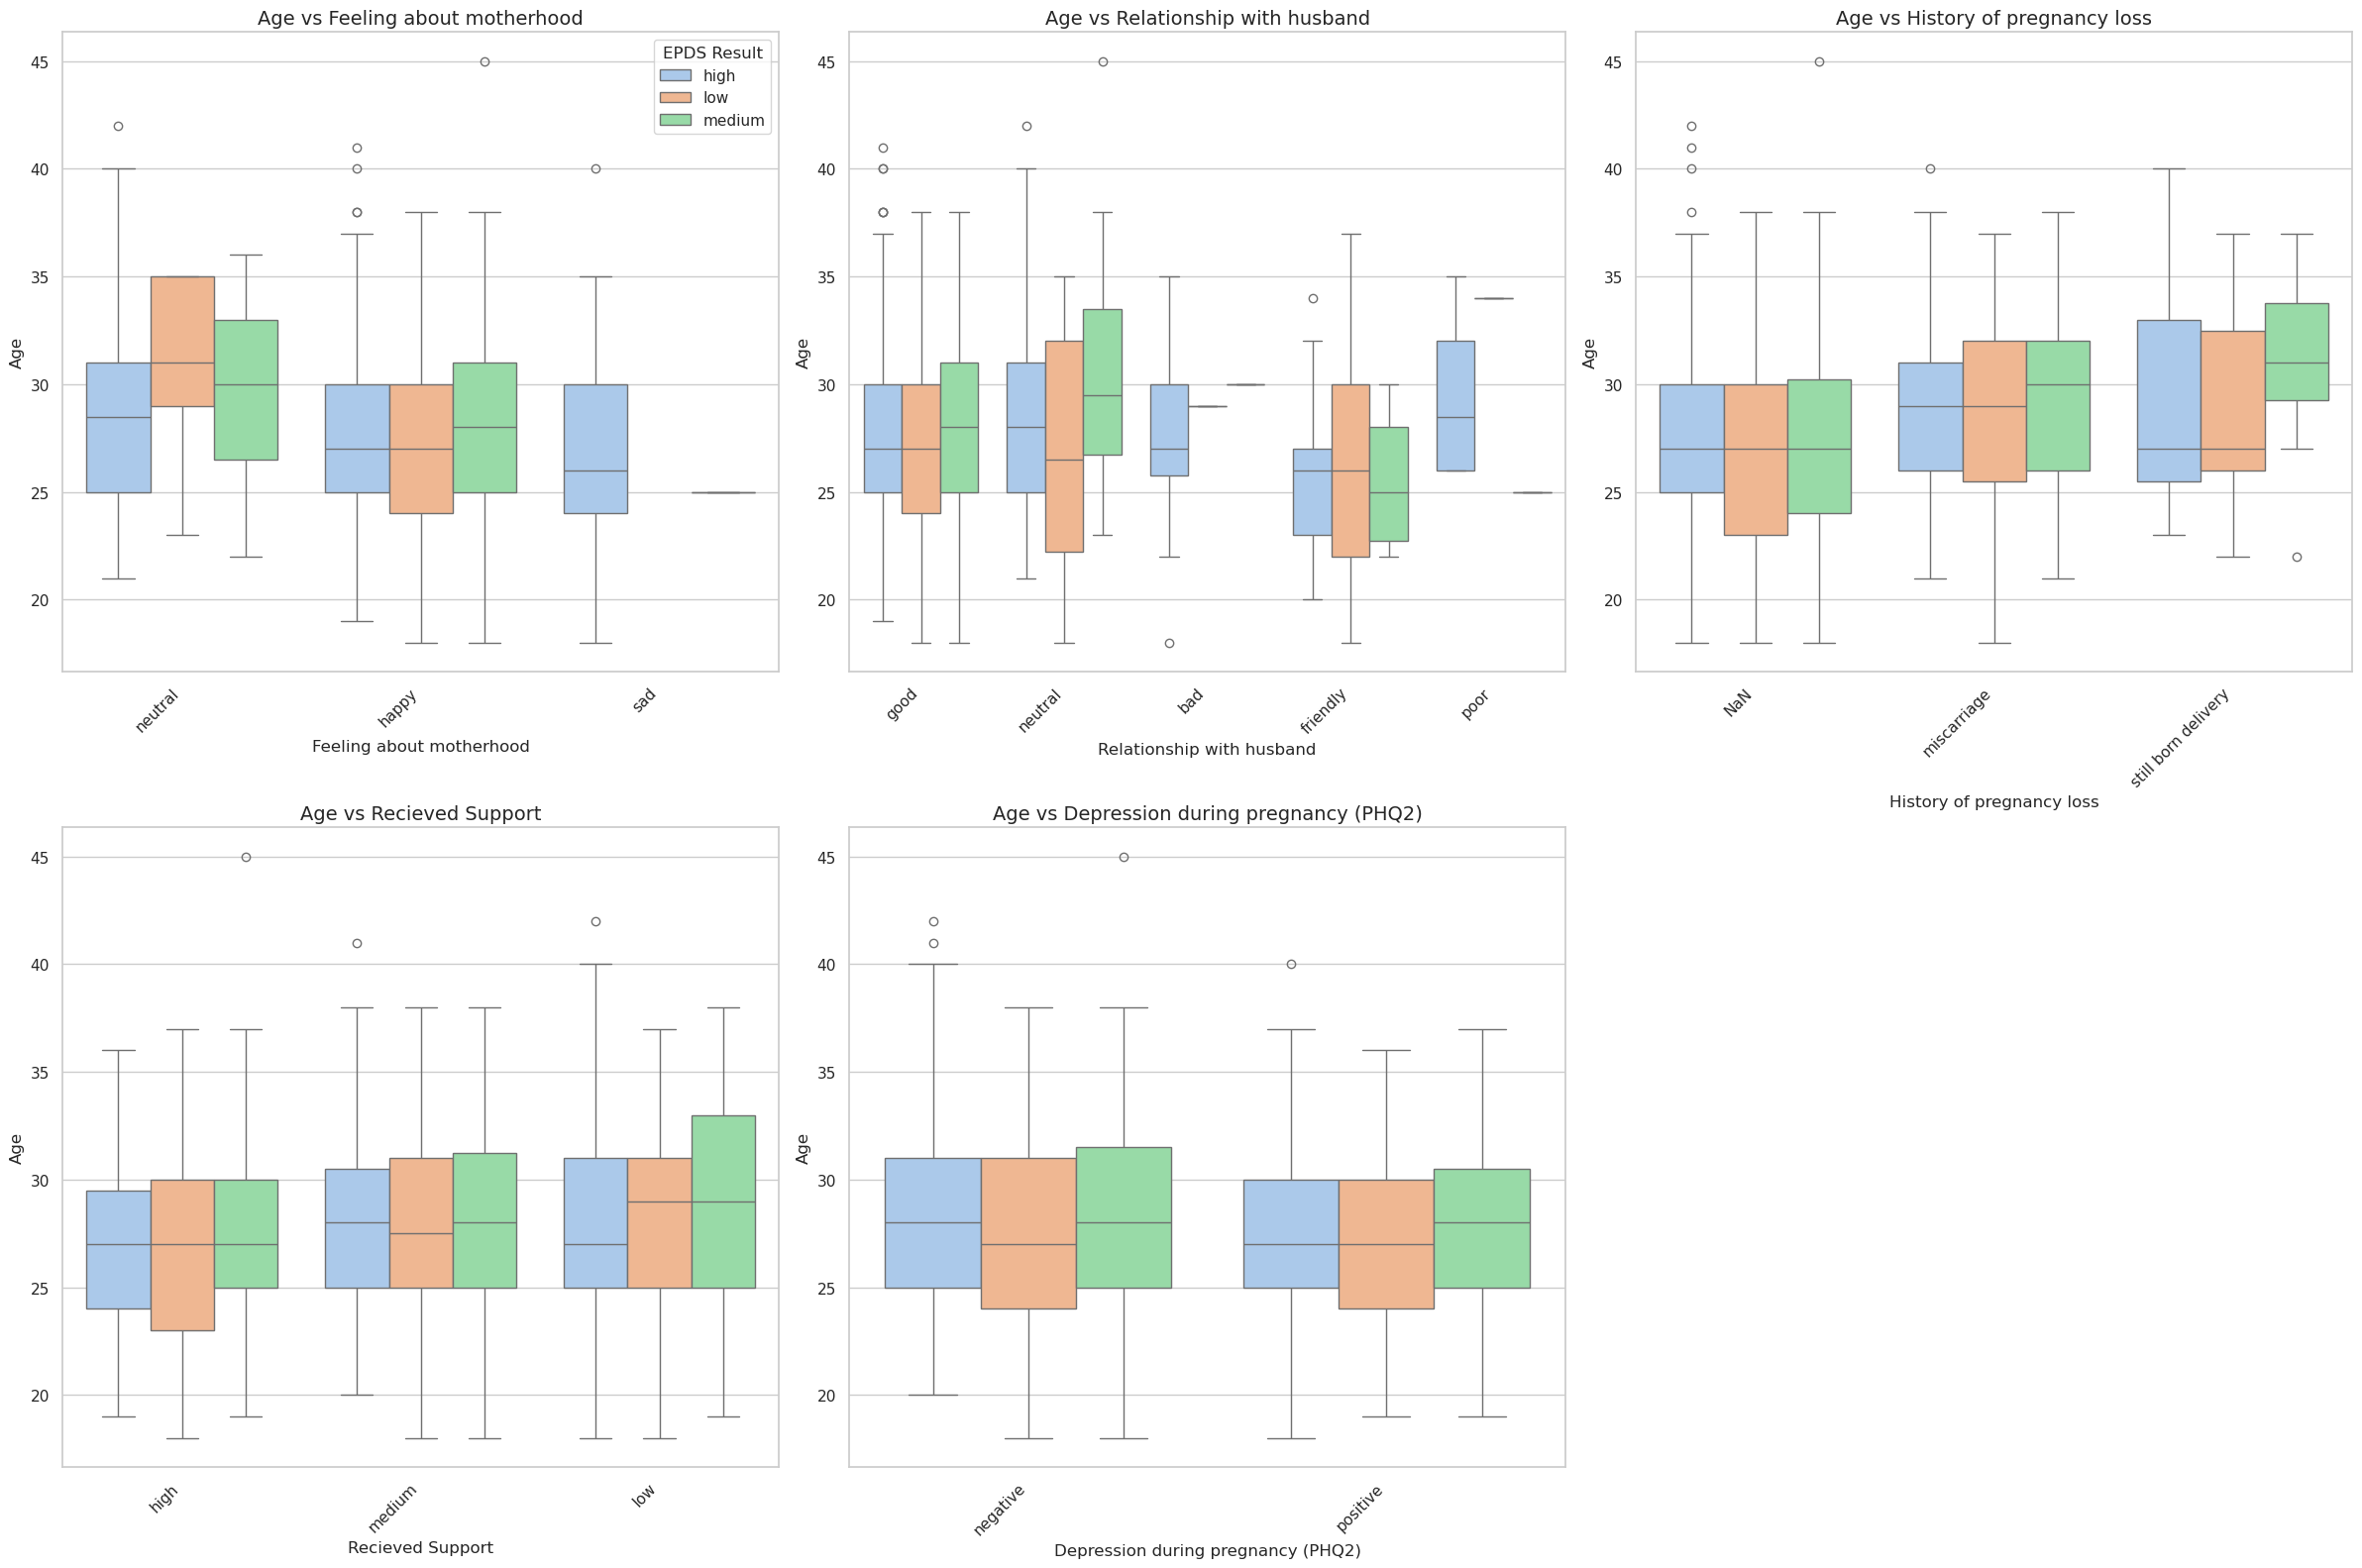

Analyzing 'Number of the latest pregnancy' vs 


count      mean       std  min  25%  50%  75%  max
Feeling about motherhood                                                    
happy                     671.0  1.609538  0.867058  1.0  1.0  1.0  2.0  7.0
neutral                    94.0  1.819149  1.057109  1.0  1.0  1.5  2.0  5.0
sad                        35.0  1.542857  0.918530  1.0  1.0  1.0  2.0  5.0


----------------------------------------------------------------------------------------------------



count      mean       std  min  25%  50%   75%  max
Relationship with husband                                                     
bad                         51.0  1.392157  0.602609  1.0  1.0  1.0  2.00  3.0
friendly                    52.0  1.500000  0.779643  1.0  1.0  1.0  2.00  4.0
good                       578.0  1.648789  0.911798  1.0  1.0  1.0  2.00  7.0
neutral                    113.0  1.716814  0.958692  1.0  1.0  1.0  2.00  6.0
poor                         6.0  1.500000  0.836660  1.0  1.0  1.0  1.75  3.0


----------------------------------------------------------------------------------------------------



count      mean       std  min  25%  50%  75%  max
History of pregnancy loss                                                    
NaN                        613.0  1.399674  0.655644  1.0  1.0  1.0  2.0  5.0
miscarriage                158.0  2.291139  1.048528  1.0  2.0  2.0  3.0  7.0
still born delivery         29.0  2.931034  1.386955  1.0  2.0  2.0  4.0  6.0


----------------------------------------------------------------------------------------------------



count      mean       std  min  25%  50%  75%  max
Recieved Support                                                    
high              307.0  1.511401  0.809886  1.0  1.0  1.0  2.0  7.0
low               154.0  1.792208  1.045847  1.0  1.0  2.0  2.0  6.0
medium            339.0  1.666667  0.882662  1.0  1.0  1.0  2.0  7.0


----------------------------------------------------------------------------------------------------



count      mean       std  min  25%  50%  \
Depression during pregnancy (PHQ2)                                             
negative                            616.0  1.584416  0.858824  1.0  1.0  1.0   
positive                            184.0  1.788043  0.993789  1.0  1.0  1.5   

                                    75%  max  
Depression during pregnancy (PHQ2)            
negative                            2.0  7.0  
positive                            2.0  6.0


----------------------------------------------------------------------------------------------------



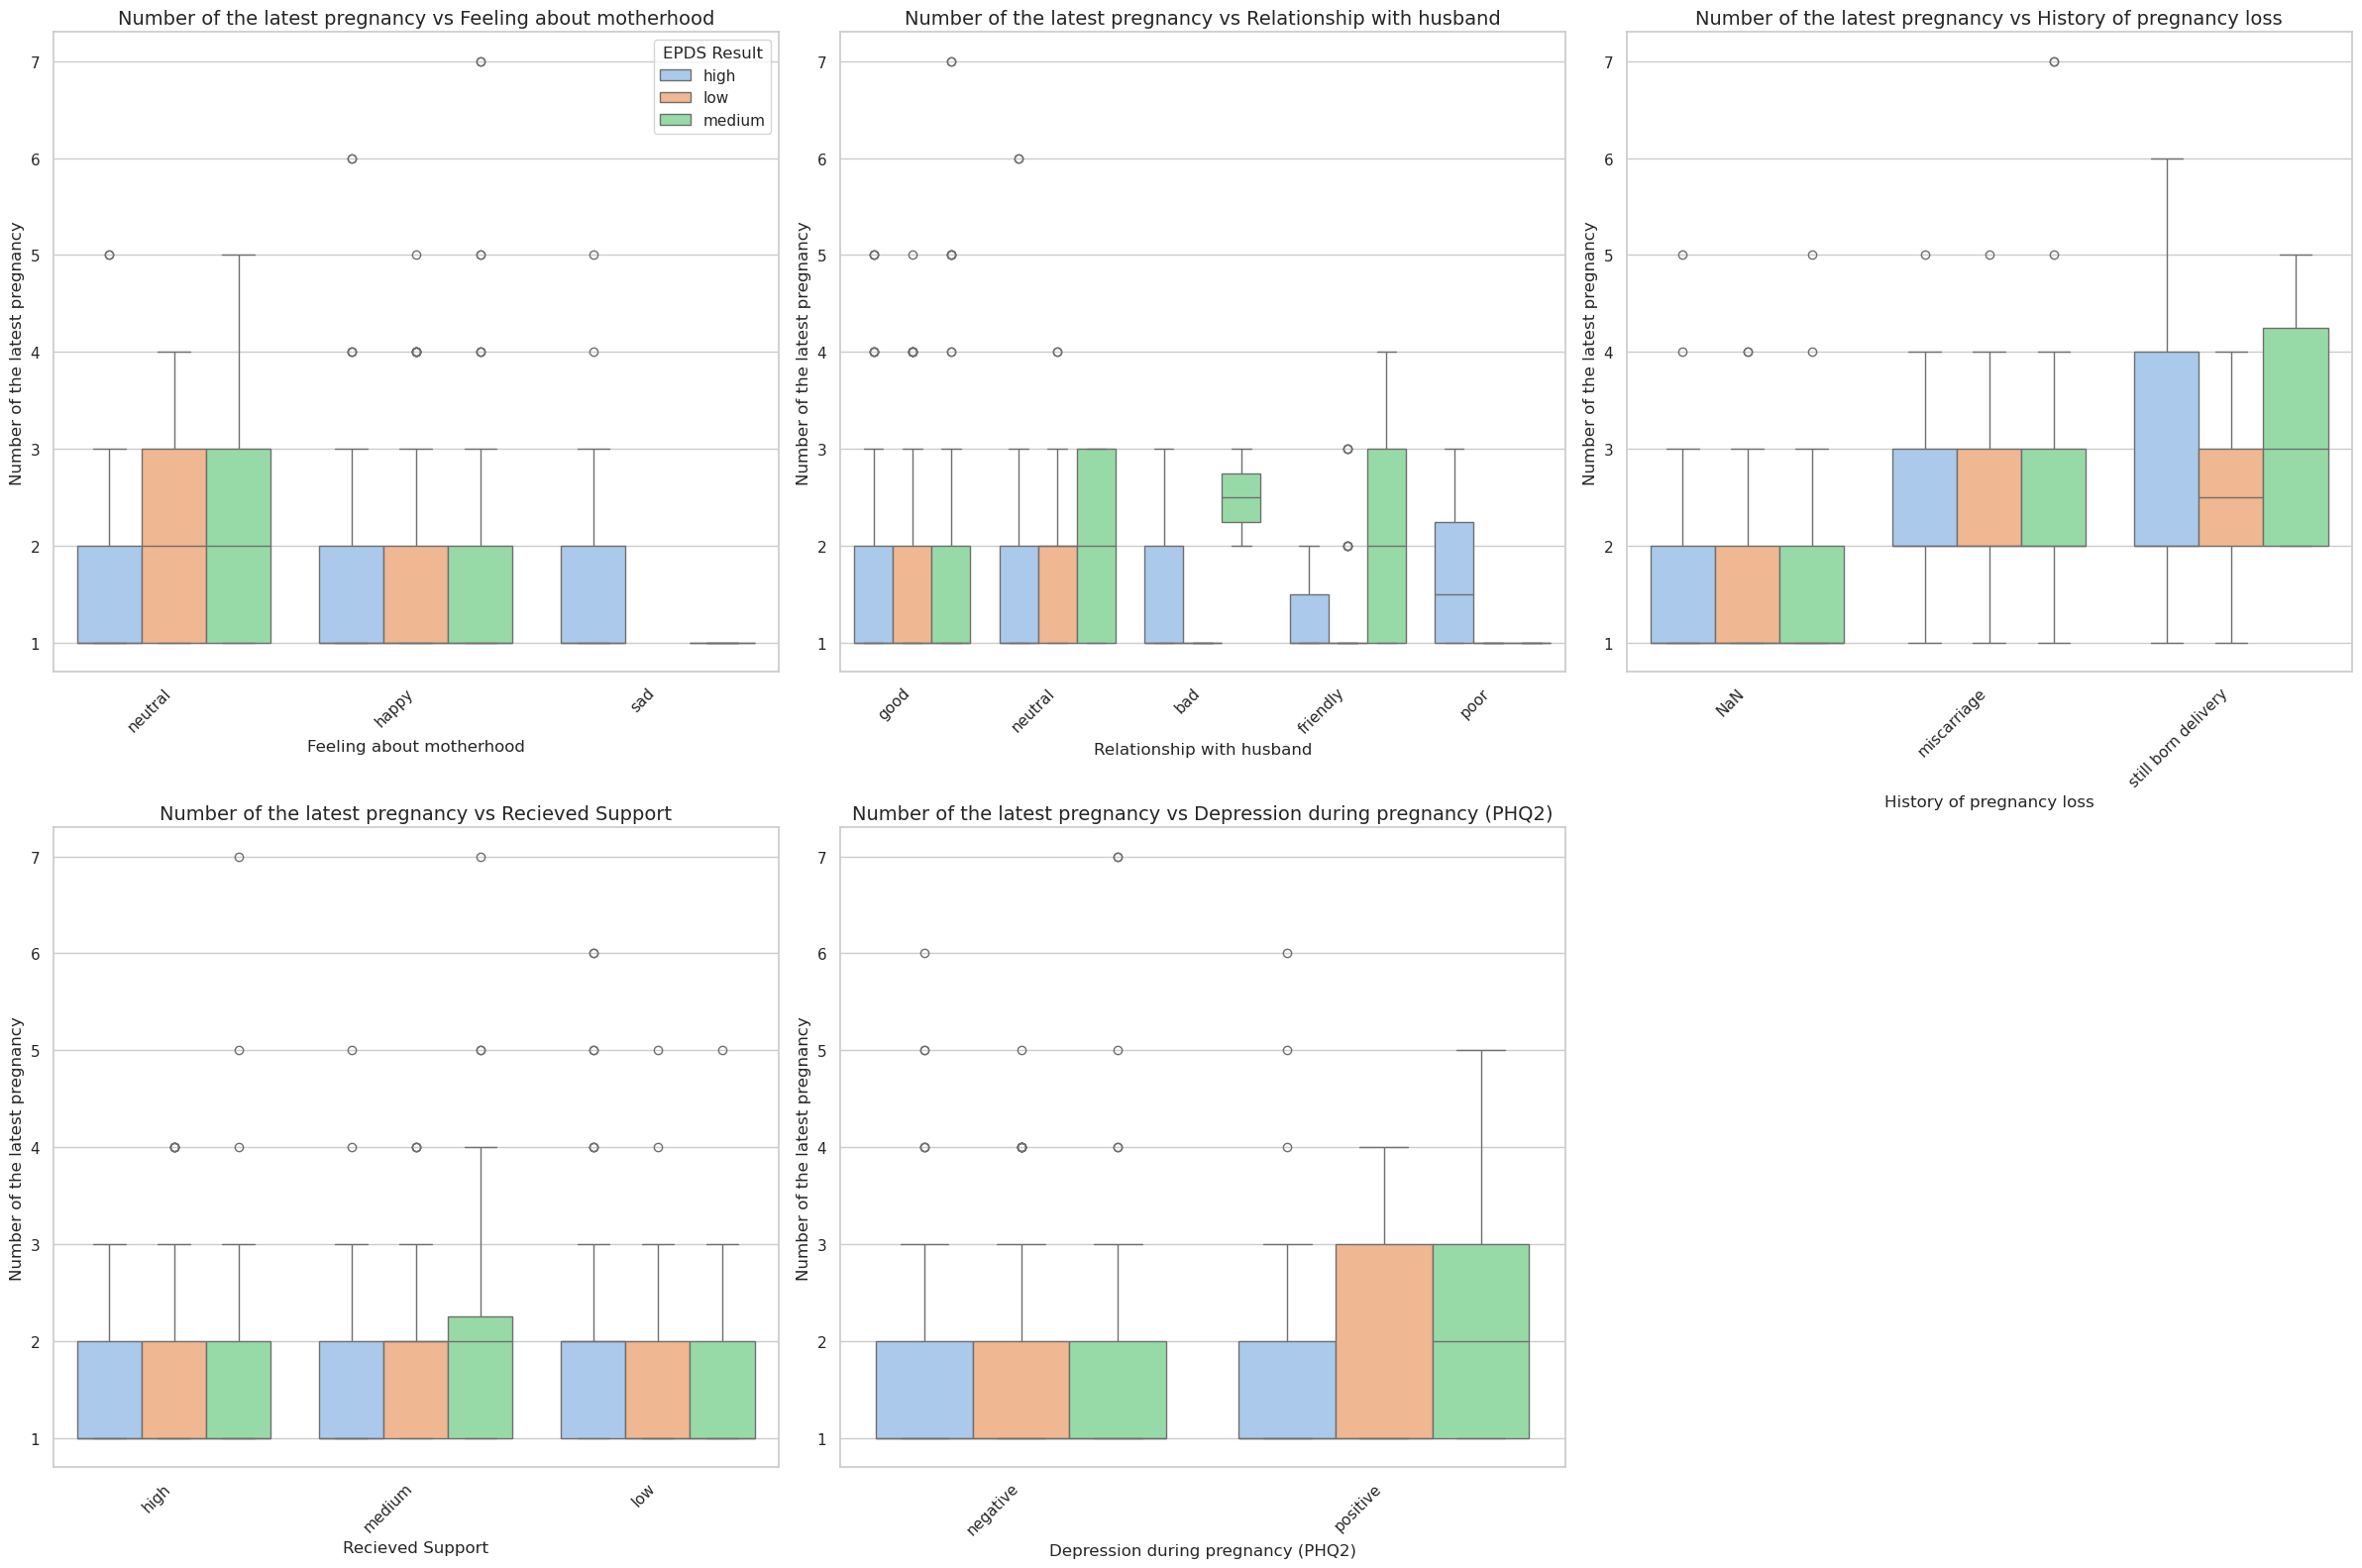

Analyzing 'PHQ9 Score' vs 


count       mean       std   min   25%   50%   75%  \
Feeling about motherhood                                                       
happy                     671.0  10.426230  5.332818   0.0   6.0  10.0  14.0   
neutral                    94.0  14.797872  5.782026   5.0  10.0  14.0  20.0   
sad                        35.0  18.828571  4.817161  11.0  14.0  20.0  22.5   

                           max  
Feeling about motherhood        
happy                     25.0  
neutral                   27.0  
sad                       27.0


----------------------------------------------------------------------------------------------------



count       mean       std  min   25%   50%    75%  \
Relationship with husband                                                       
bad                         51.0  18.352941  5.117904  7.0  15.0  18.0  22.50   
friendly                    52.0   8.423077  4.064896  2.0   5.0   8.0  10.25   
good                       578.0  10.610727  5.520627  0.0   6.0  10.0  14.00   
neutral                    113.0  12.778761  5.243592  2.0   9.0  12.0  17.00   
poor                         6.0  15.833333  5.810909  7.0  12.5  17.0  20.00   

                            max  
Relationship with husband        
bad                        27.0  
friendly                   20.0  
good                       27.0  
neutral                    24.0  
poor                       22.0


----------------------------------------------------------------------------------------------------



count       mean       std  min  25%   50%   75%  \
History of pregnancy loss                                                     
NaN                        613.0  11.309951  5.828304  0.0  7.0  11.0  15.0   
miscarriage                158.0  11.556962  5.750097  0.0  7.0  11.0  15.0   
still born delivery         29.0   9.896552  4.434804  1.0  5.0  11.0  14.0   

                            max  
History of pregnancy loss        
NaN                        27.0  
miscarriage                27.0  
still born delivery        17.0


----------------------------------------------------------------------------------------------------



count       mean       std  min  25%   50%   75%   max
Recieved Support                                                        
high              307.0   9.459283  5.261229  0.0  6.0   8.0  13.0  25.0
low               154.0  12.487013  6.143424  1.0  8.0  12.0  16.0  27.0
medium            339.0  12.445428  5.613735  0.0  8.0  12.0  16.0  27.0


----------------------------------------------------------------------------------------------------



count       mean       std  min  25%  \
Depression during pregnancy (PHQ2)                                         
negative                            616.0  10.577922  5.588644  0.0  6.0   
positive                            184.0  13.750000  5.709019  1.0  9.0   

                                     50%   75%   max  
Depression during pregnancy (PHQ2)                    
negative                            10.0  14.0  27.0  
positive                            13.0  18.0  27.0


----------------------------------------------------------------------------------------------------



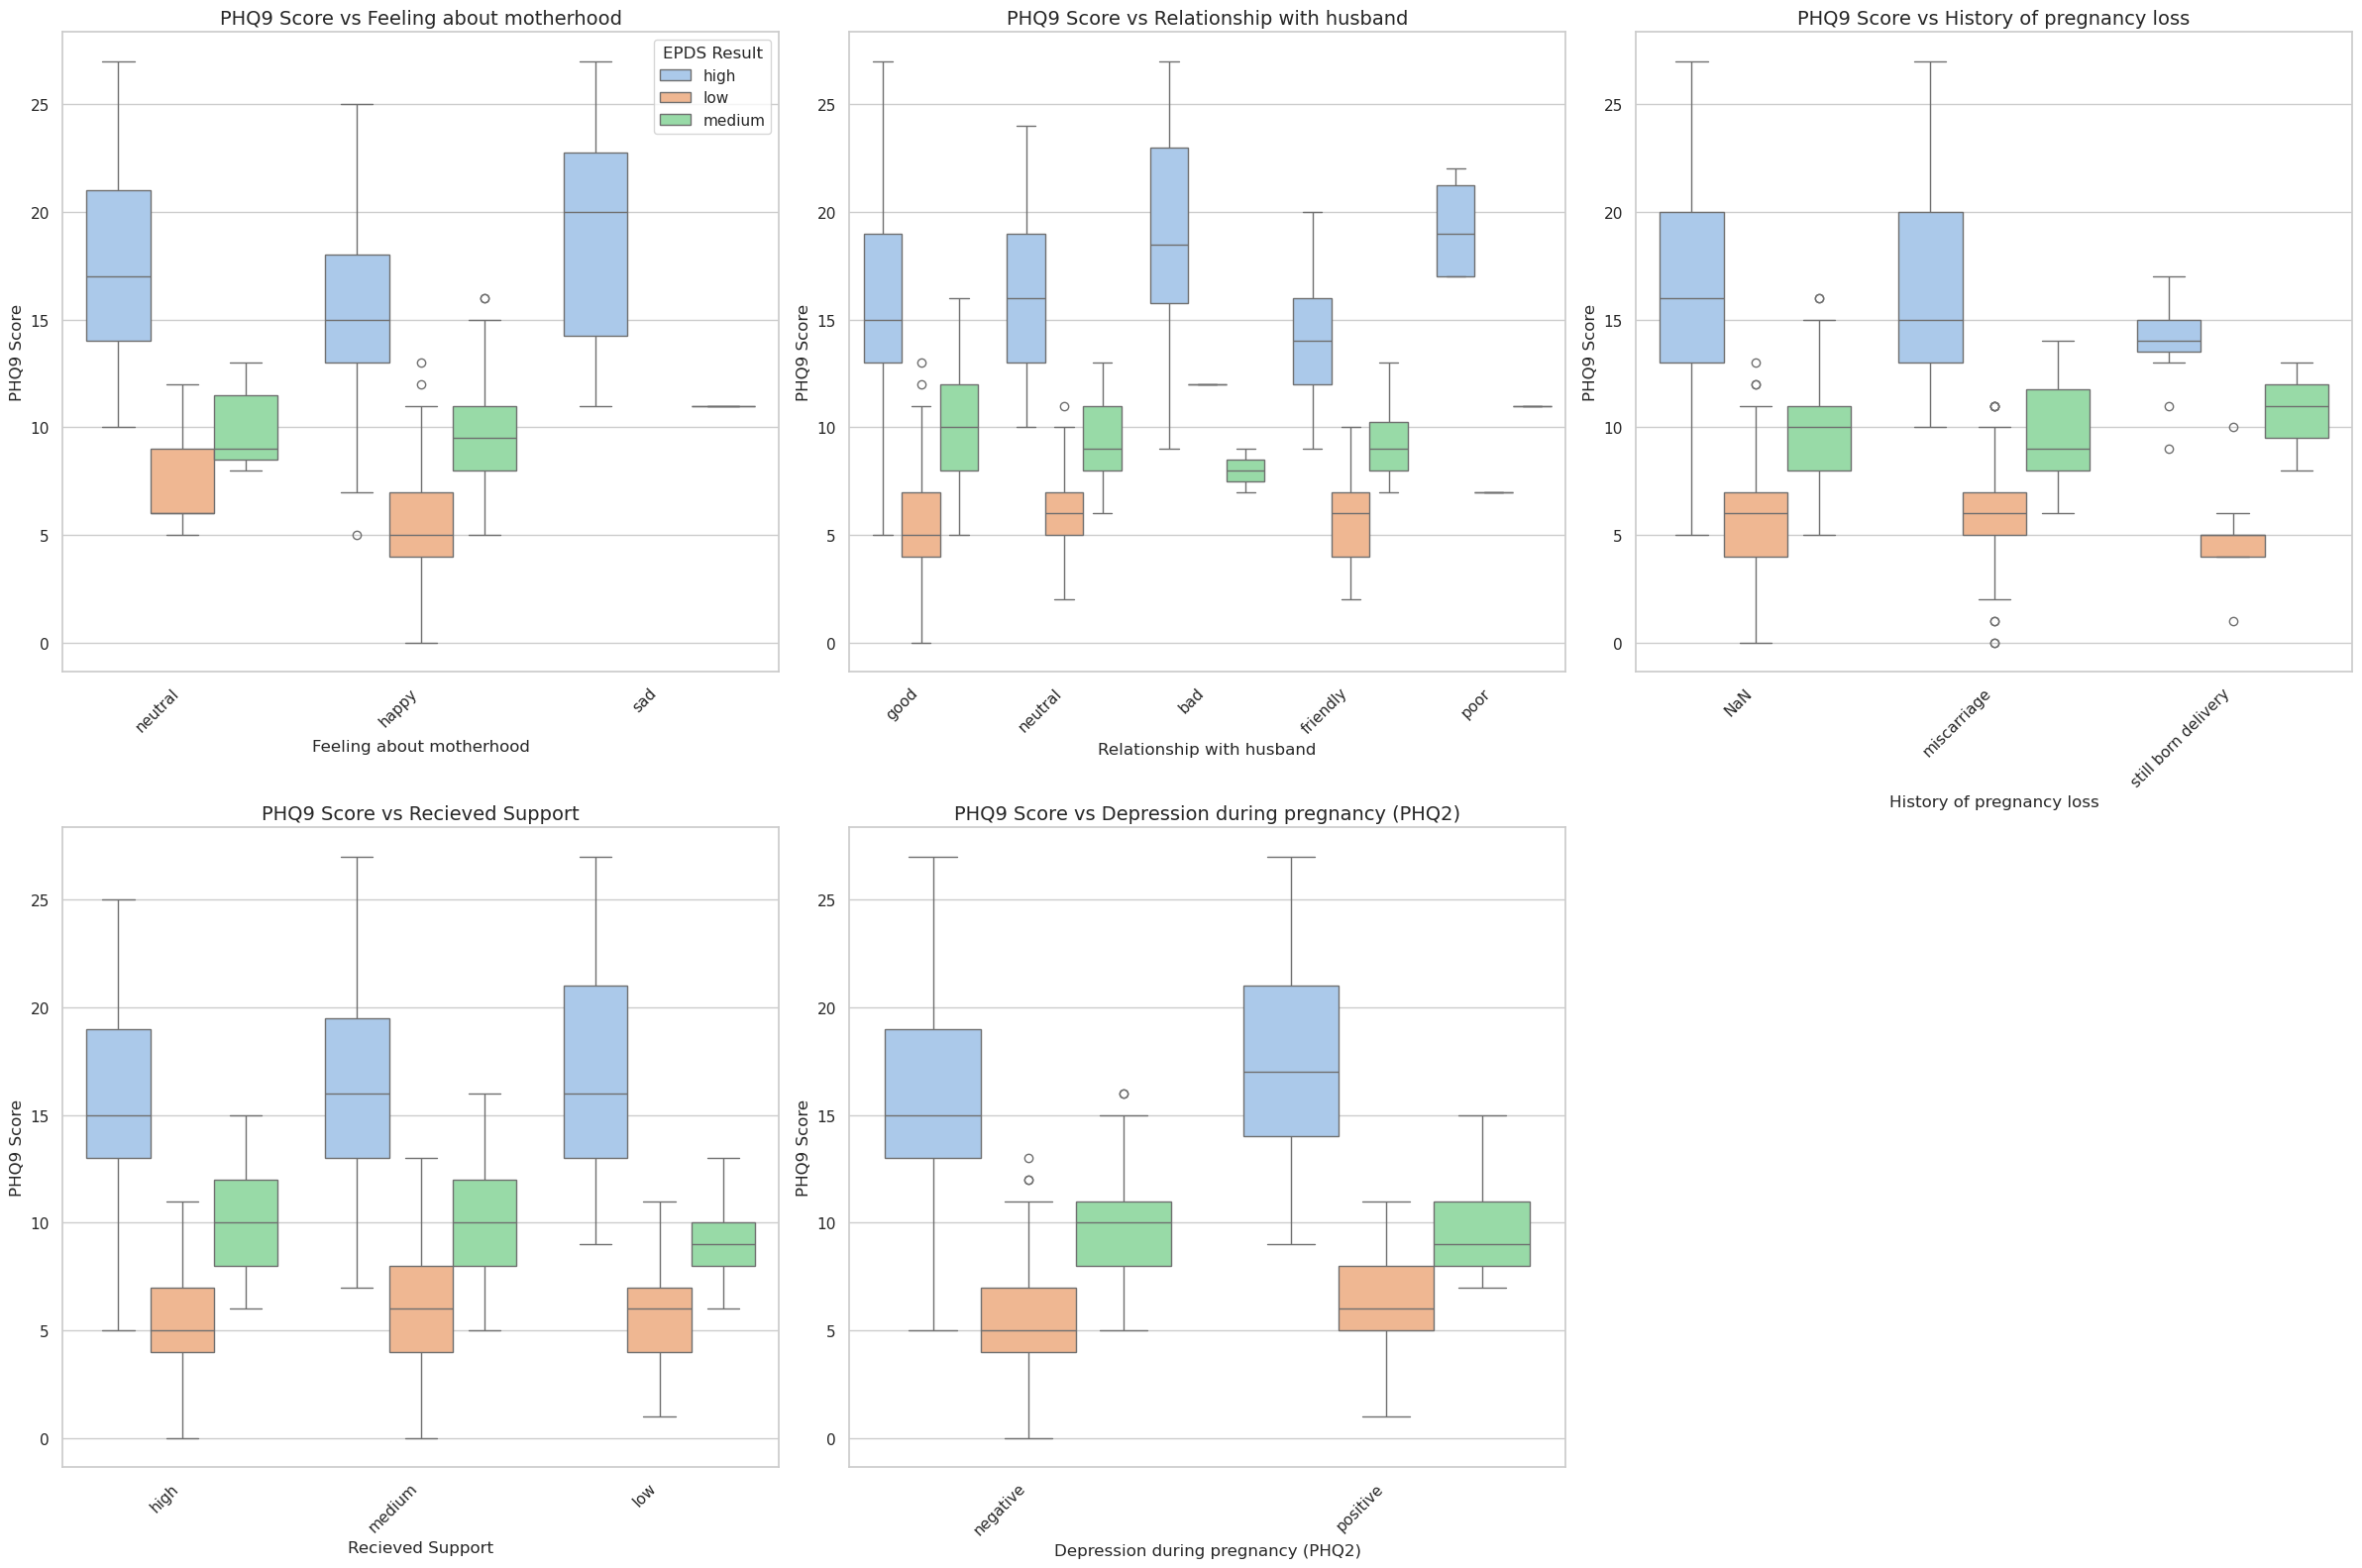

Analyzing 'EPDS Score' vs 


count       mean       std   min   25%   50%    75%  \
Feeling about motherhood                                                        
happy                     671.0  11.347243  6.533506   0.0   7.0  10.0  15.00   
neutral                    94.0  16.734043  7.085007   3.0  11.0  17.0  22.75   
sad                        35.0  22.371429  5.423726  10.0  19.0  23.0  26.50   

                           max  
Feeling about motherhood        
happy                     30.0  
neutral                   30.0  
sad                       30.0


----------------------------------------------------------------------------------------------------



count       mean       std  min   25%   50%   75%  \
Relationship with husband                                                      
bad                         51.0  22.235294  5.591380  8.0  19.0  23.0  27.0   
friendly                    52.0   9.076923  5.268650  0.0   5.0   8.0  12.0   
good                       578.0  11.442907  6.642729  0.0   7.0  11.0  15.0   
neutral                    113.0  14.584071  6.577458  2.0   9.0  14.0  20.0   
poor                         6.0  17.000000  7.348469  7.0  12.0  18.5  20.5   

                            max  
Relationship with husband        
bad                        30.0  
friendly                   26.0  
good                       30.0  
neutral                    30.0  
poor                       27.0


----------------------------------------------------------------------------------------------------



count       mean       std  min  25%   50%   75%  \
History of pregnancy loss                                                     
NaN                        613.0  12.491028  7.112219  0.0  7.0  11.0  18.0   
miscarriage                158.0  12.759494  7.152061  0.0  8.0  12.0  17.0   
still born delivery         29.0  10.241379  6.294301  0.0  4.0  12.0  14.0   

                            max  
History of pregnancy loss        
NaN                        30.0  
miscarriage                30.0  
still born delivery        25.0


----------------------------------------------------------------------------------------------------



count       mean       std  min  25%   50%    75%   max
Recieved Support                                                         
high              307.0   9.915309  6.387743  0.0  5.0   9.0  13.00  30.0
low               154.0  14.194805  7.578847  0.0  8.0  13.0  20.75  30.0
medium            339.0  13.982301  6.824923  0.0  9.0  13.0  19.00  30.0


----------------------------------------------------------------------------------------------------



count       mean       std  min   25%  \
Depression during pregnancy (PHQ2)                                          
negative                            616.0  11.538961  6.884301  0.0   6.0   
positive                            184.0  15.554348  6.943746  0.0  10.0   

                                     50%   75%   max  
Depression during pregnancy (PHQ2)                    
negative                            11.0  16.0  30.0  
positive                            14.0  21.0  30.0


----------------------------------------------------------------------------------------------------



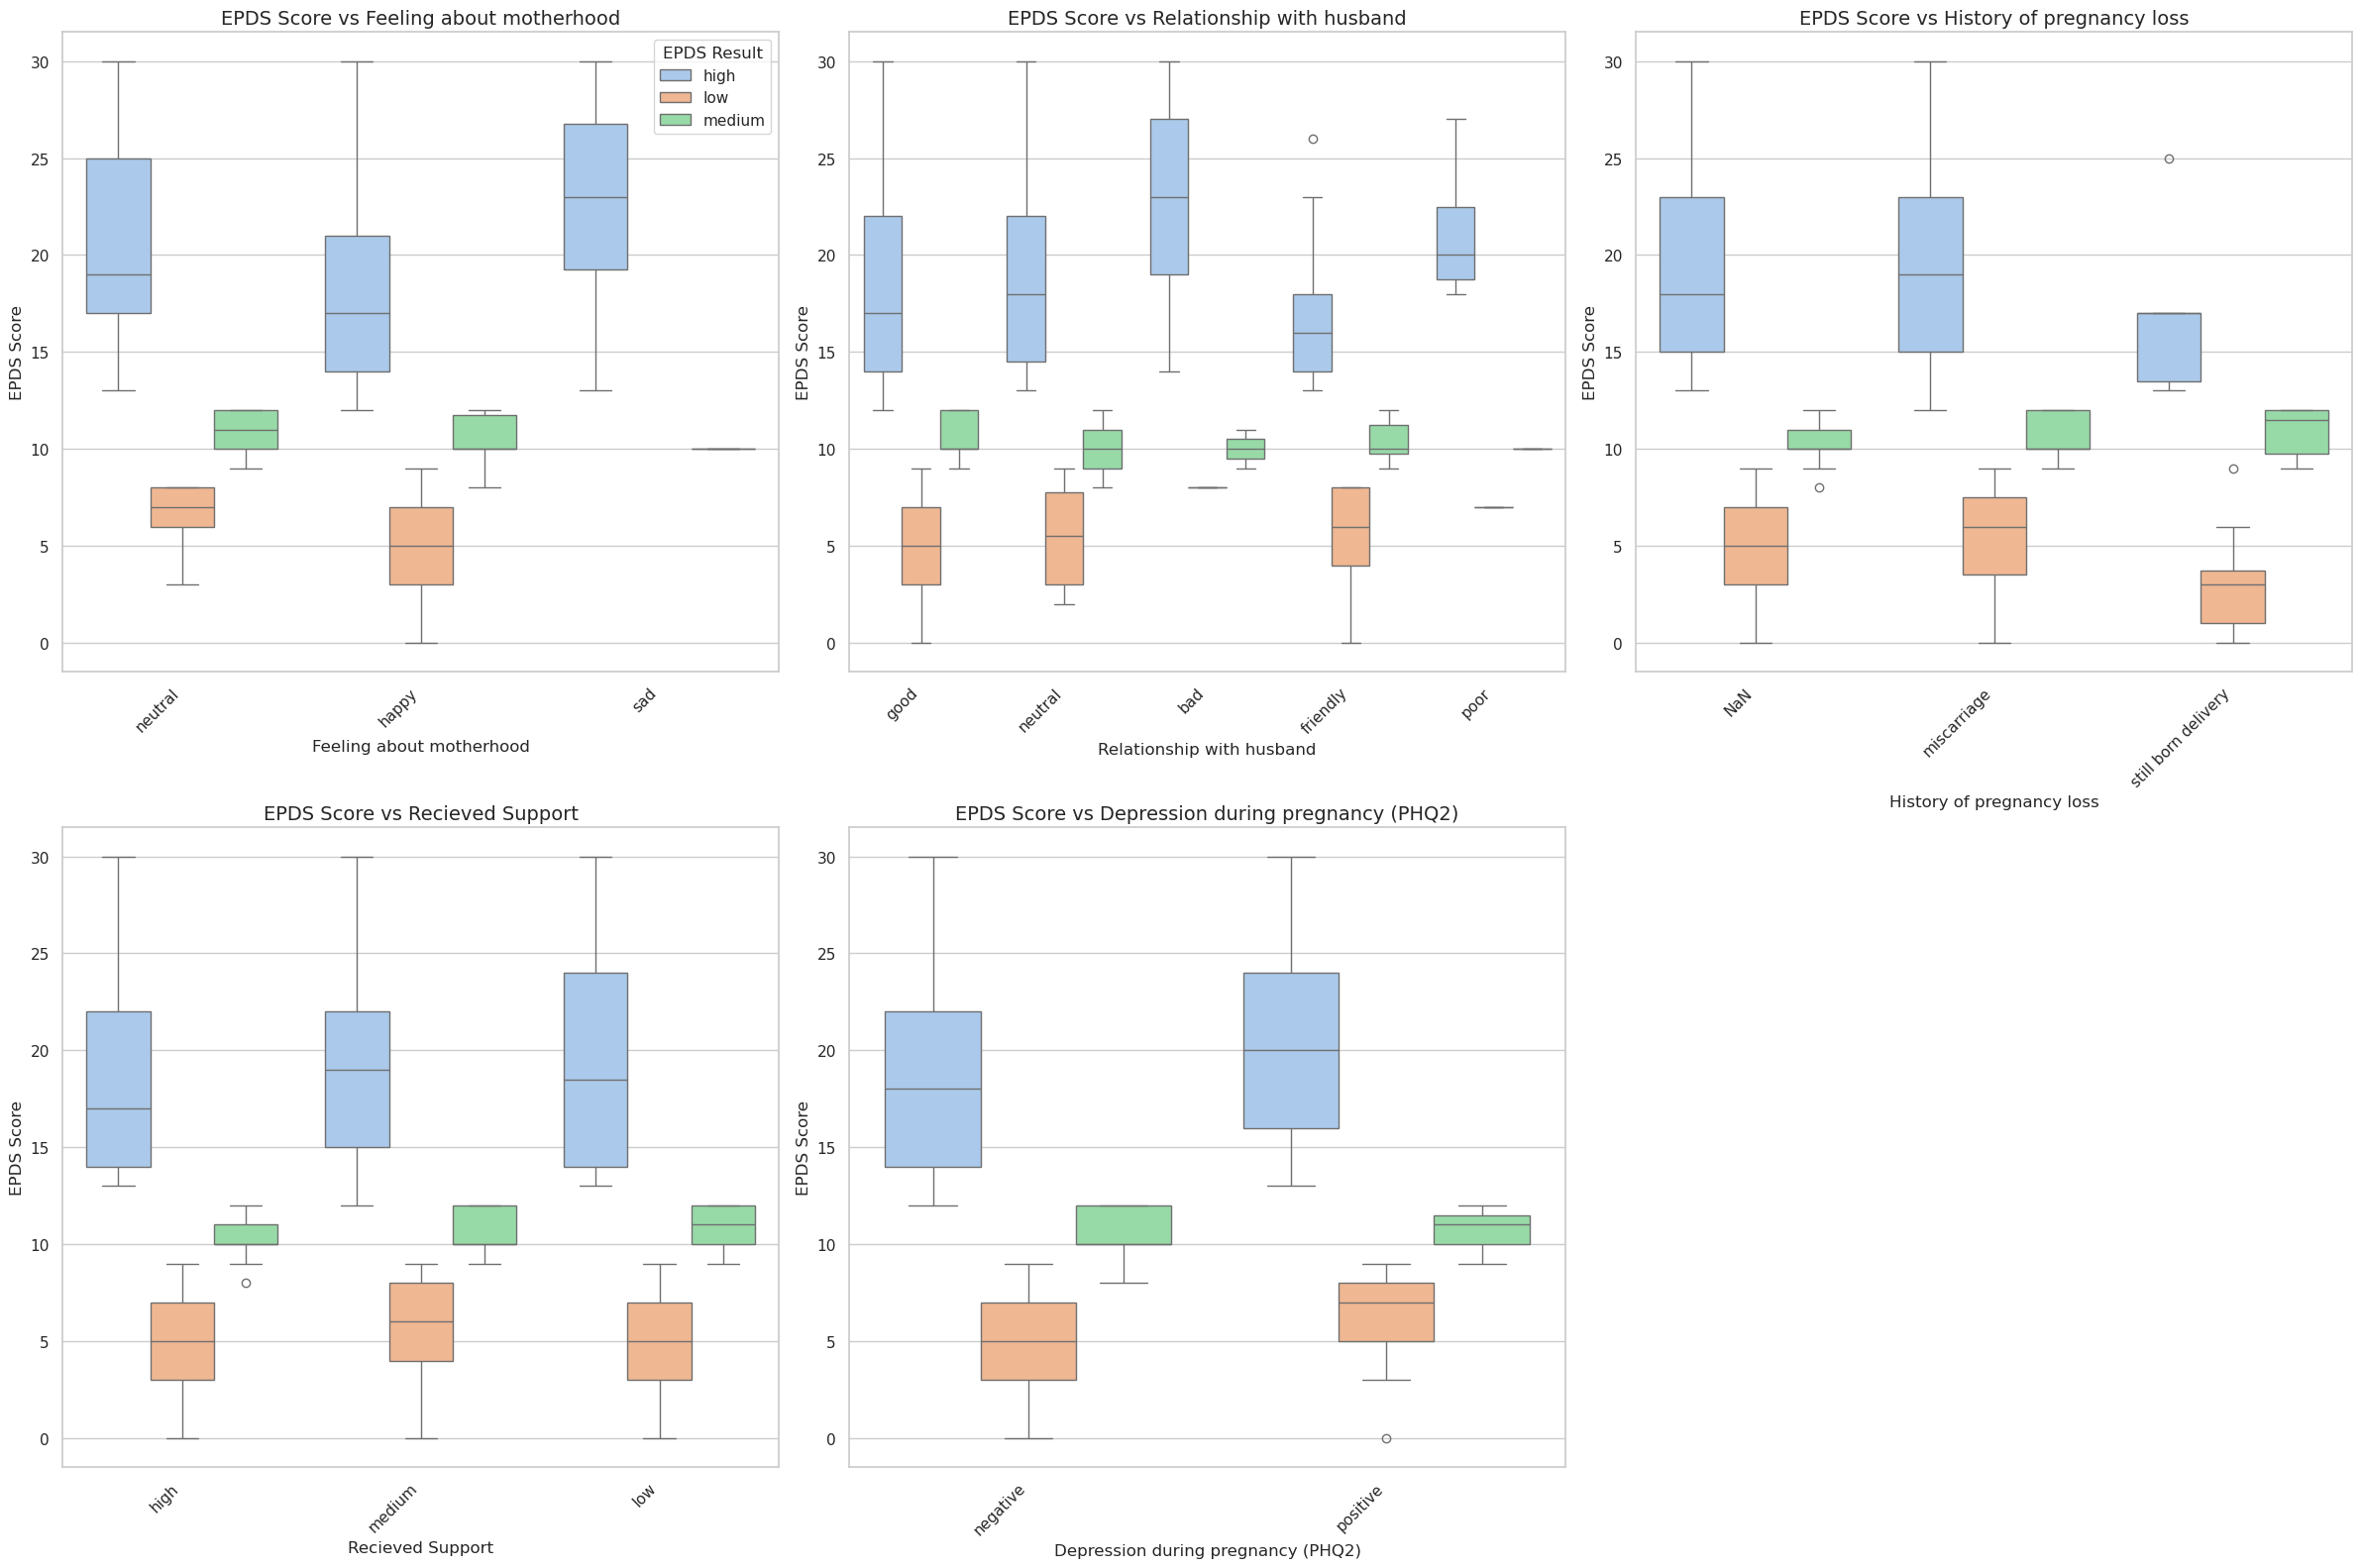

In [11]:
# --- Categorical vs Numerical analysis for PPD (big square layout, no duplicates) ---
numeric_cols = ['Age', 'Number of the latest pregnancy', 'PHQ9 Score', 'EPDS Score']

for num_col in numeric_cols:
    fig, axes = plt.subplots(2, 3, figsize=(24, 16))  # 2 rows x 3 columns
    axes = axes.flatten()
    
    print(f"Analyzing '{num_col}' vs ")
    for i, cat_col in enumerate(top5_cat):
        ax = axes[i]
        
        # Boxplot: numeric vs categorical
        sns.boxplot(data=df, x=cat_col, y=num_col, hue='EPDS Result', ax=ax, palette='pastel')
        
        # Titles and labels
        ax.set_title(f"{num_col} vs {cat_col}", fontsize=14)
        ax.set_xlabel(cat_col, fontsize=12)
        ax.set_ylabel(num_col, fontsize=12)
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=11)
        ax.tick_params(axis='y', labelsize=11)
        
        # Legend only for first subplot
        if i != 0:
            ax.get_legend().remove()
        else:
            ax.legend(title='EPDS Result', fontsize=11, title_fontsize=12)
        
        # --- Summary statistics (one print per numeric x categorical pair) ---
        display(df.groupby(cat_col)[num_col].describe())
        print("\n" + "-"*100 + "\n")
    
    # Remove any empty subplot (6th subplot in 2x3 grid)
    if len(top5_cat) < len(axes):
        for j in range(len(top5_cat), len(axes)):
            fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()


## Numerical vs Numerical pair plot


<Figure size 1200x1200 with 0 Axes>

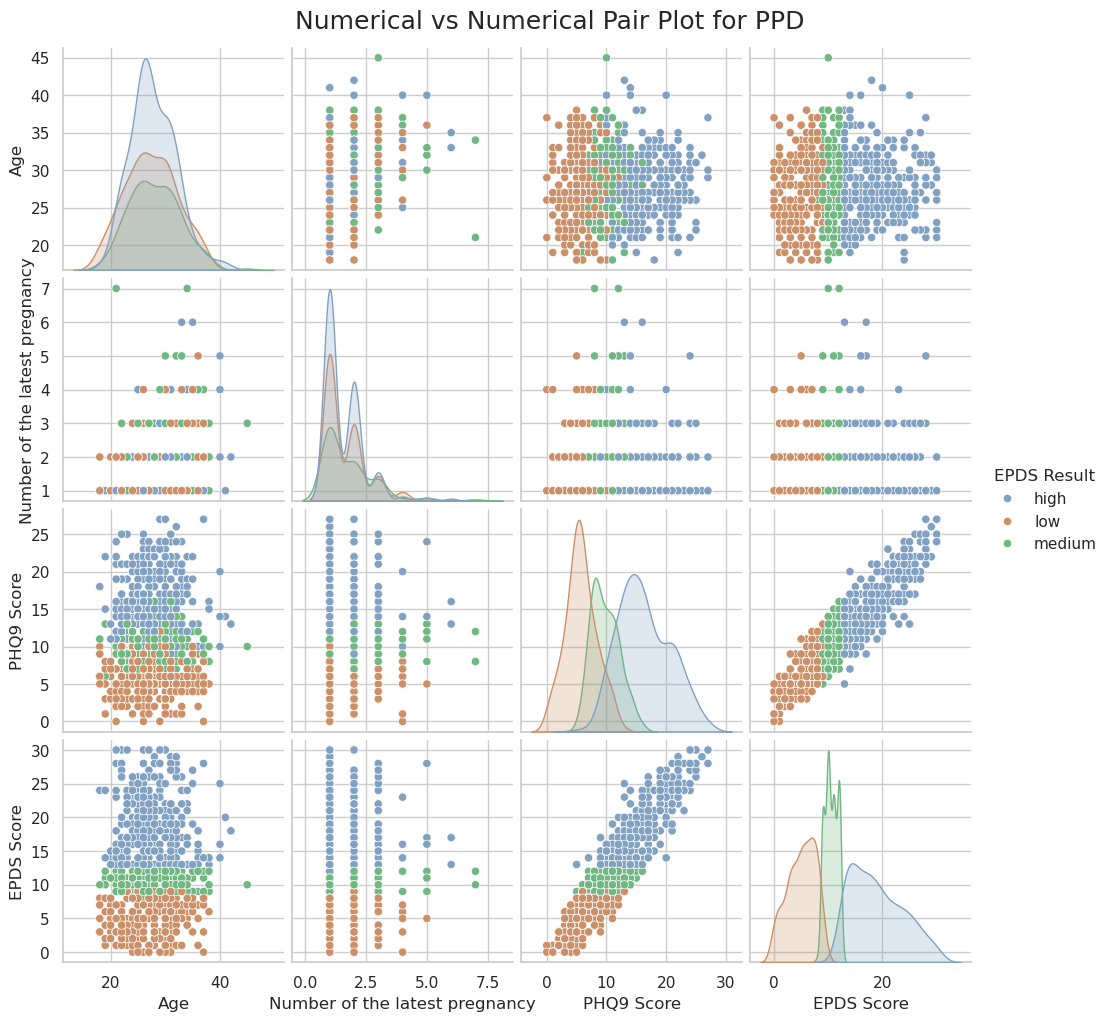

In [12]:
# --- Numerical vs Numerical analysis for PPD (darker pastel) ---
numeric_cols = ['Age', 'Number of the latest pregnancy', 'PHQ9 Score', 'EPDS Score']
target_col = 'EPDS Result'

# Create slightly darker pastel palette
n_classes = df[target_col].nunique()
base_palette = sns.color_palette("pastel", n_colors=n_classes)
darker_palette = [(r*0.8, g*0.8, b*0.8) for r, g, b in base_palette]

# Pairplot with hue = EPDS Result
plt.figure(figsize=(12, 12))
sns.pairplot(df[numeric_cols + [target_col]], 
             hue=target_col, 
             palette=darker_palette,  # darker pastel
             diag_kind='kde', 
             corner=False)  # corner=False shows full matrix

plt.suptitle("Numerical vs Numerical Pair Plot for PPD", fontsize=18, y=1.02)
plt.show()


## Missing data handling strategy
1. Show missing % per column.  
2. Impute numeric columns with median (configurable).  
3. Impute categorical with mode or 'missing' label.  
4. Optionally use KNNImputer for more advanced imputation (not included by default).


In [13]:
# --- Strip leading/trailing spaces from column names ---
df.columns = df.columns.str.strip()
cat_cols = [c.strip() for c in cat_cols]
num_cols = [c.strip() for c in num_cols if c.strip() != 'sr']  # remove 'sr'

# --- Missing values BEFORE imputation (using same approach as before) ---
missing_before = df.isnull().sum().sort_values(ascending=False)
missing_before = missing_before[missing_before > 0]

missing_before_df = pd.DataFrame({
    'Features': missing_before.index,
    'Missing Count (Before)': missing_before.values,
    'Missing % (Before)': round((missing_before / len(df)) * 100, 2).values
}).reset_index(drop=True)

# --- Copy dataframe for preprocessing ---
df_proc = df.copy()

# --- Numeric imputation ---
use_knn = False  # Set True to use KNN imputer, False to use median

if len(num_cols) > 0:
    if use_knn:
        knn_imputer = KNNImputer(n_neighbors=5)
        df_proc[num_cols] = knn_imputer.fit_transform(df_proc[num_cols])
    else:
        num_imputer = SimpleImputer(strategy='median')
        df_proc[num_cols] = num_imputer.fit_transform(df_proc[num_cols])

# --- Categorical imputation ---
for c in cat_cols:
    df_proc[c] = df_proc[c].fillna('Missing')

# --- Missing values AFTER imputation (same columns as before) ---
missing_after = df_proc[missing_before.index].isnull().sum()
missing_after_df = pd.DataFrame({
    'Features': missing_after.index,
    'Missing Count (After)': missing_after.values,
    'Missing % (After)': round((missing_after / len(df_proc)) * 100, 2).values
}).reset_index(drop=True)

# --- Combined table: Before vs After ---
missing_summary = pd.concat([
    missing_before_df[['Features']],
    missing_after_df[['Missing Count (After)', 'Missing % (After)']]
], axis=1)

print("Missing Data Handling: After Imputation")
display(missing_summary)



Missing Data Handling: After Imputation


Empty DataFrame
Columns: [Features, Missing Count (After), Missing % (After)]
Index: []

## One-Hot Encoding


In [14]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# -------------------------------------
# 1. Select X and y (modify target name)
# -------------------------------------
X = df.drop(columns=['EPDS Result'])   # <-- change 'target'
y = df['EPDS Result']

# -------------------------------------
# 2. Identify categorical columns
# -------------------------------------
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns:", cat_cols)

cat_cols_to_encode = cat_cols  # all categorical columns
print(f"Categorical columns to encode ({len(cat_cols_to_encode)}): {cat_cols_to_encode}")

# -------------------------------------
# 3. One-Hot Encode the FULL dataset
# -------------------------------------
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

X_encoded = ohe.fit_transform(X[cat_cols_to_encode])

encoded_cols = ohe.get_feature_names_out(cat_cols_to_encode)

# Convert encoded array → DataFrame
X_ohe = pd.DataFrame(X_encoded, columns=encoded_cols, index=X.index)

# -------------------------------------
# 4. Drop original categorical cols & append encoded cols
# -------------------------------------
X_final = pd.concat([X.drop(columns=cat_cols_to_encode), X_ohe], axis=1)

print("Final dataset shape after OHE:", X_final.shape)

print("\n--- Encoded Sample ---")
display(X_ohe.head())

print("\n--- One-Hot Encoded Columns ---")
import textwrap
wrapped_cols = textwrap.fill(', '.join(encoded_cols), width=120)
print(wrapped_cols)

# -------------------------------------
# 5. NOW you can split X_final however you want
# -------------------------------------
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(
#     X_final, y, test_size=0.2, random_state=42
# )




Categorical columns: ['Residence', 'Education Level', 'Marital status', 'Occupation before latest pregnancy', 'Monthly income before latest pregnancy', 'Occupation After Your Latest Childbirth', 'Current monthly income', "Husband's education level", "Husband's monthly income", 'Addiction', 'Total children', 'Disease before pregnancy', 'History of pregnancy loss', 'Family type', 'Number of household members', 'Relationship with the in-laws', 'Relationship with husband', 'Relationship with the newborn', 'Relationship between father and newborn', 'Feeling about motherhood', 'Recieved Support', 'Need for Support', 'Major changes or losses during pregnancy', 'Abuse', 'Trust and share feelings', 'Pregnancy length', 'Pregnancy plan', 'Regular checkups', 'Fear of pregnancy', 'Diseases during pregnancy', 'Age of newborn', 'Age of immediate older children', 'Mode of delivery', 'Gender of newborn', 'Birth compliancy', 'Breastfeed', 'Newborn illness', 'Worry about newborn', 'Relax/sleep when newbo

Residence_city  Residence_village  Education Level_NaN  \
0             1.0                0.0                  0.0   
1             1.0                0.0                  0.0   
2             1.0                0.0                  0.0   
3             1.0                0.0                  0.0   
4             1.0                0.0                  0.0   

   Education Level_college  Education Level_high school  \
0                      0.0                          0.0   
1                      0.0                          0.0   
2                      0.0                          0.0   
3                      0.0                          0.0   
4                      0.0                          0.0   

   Education Level_primary school  Education Level_university  \
0                             0.0                         1.0   
1                             0.0                         1.0   
2                             0.0                         1.0   
3                             0.0                         1.0   
4                             0.0                         1.0   

   Marital status_divorced  Marital status_married  \
0                      0.0                     1.0   
1                      1.0                     0.0   
2                      0.0                     1.0   
3                      0.0                     1.0   
4                      0.0                     1.0   

   Occupation before latest pregnancy_business  \
0                                          0.0   
1                                          0.0   
2                                          0.0   
3                                          0.0   
4                                          0.0   

   Occupation before latest pregnancy_doctor  \
0                                        0.0   
1                                        1.0   
2                                        0.0   
3                                        1.0   
4                                        0.0   

   Occupation before latest pregnancy_housewife  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                                           1.0   

   Occupation before latest pregnancy_other  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   

   Occupation before latest pregnancy_service  \
0                                         0.0   
1                                         0.0   
2                                         1.0   
3                                         0.0   
4                                         0.0   

   Occupation before latest pregnancy_student  \
0                                         1.0   
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.0   

   Occupation before latest pregnancy_teacher  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.0   

   Monthly income before latest pregnancy_10000 to 20000  \
0                                                0.0       
1                                                1.0       
2                                                1.0       
3                                                0.0       
4                                                0.0       

   Monthly income before latest pregnancy_5000 to 10000  \
0                                                0.0      
1                    


--- One-Hot Encoded Columns ---
Residence_city, Residence_village, Education Level_NaN, Education Level_college, Education Level_high school, Education
Level_primary school, Education Level_university, Marital status_divorced, Marital status_married, Occupation before
latest pregnancy_business, Occupation before latest pregnancy_doctor, Occupation before latest pregnancy_housewife,
Occupation before latest pregnancy_other, Occupation before latest pregnancy_service, Occupation before latest
pregnancy_student, Occupation before latest pregnancy_teacher, Monthly income before latest pregnancy_10000 to 20000,
Monthly income before latest pregnancy_5000 to 10000, Monthly income before latest pregnancy_NaN, Monthly income before
latest pregnancy_less than 5000, Monthly income before latest pregnancy_more than 30000, Occupation After Your Latest
Childbirth_business, Occupation After Your Latest Childbirth_doctor, Occupation After Your Latest Childbirth_housewife,
Occupation After Your Lates

##  Standardization
We will StandardScale numeric features: ['Age', 'Number of the latest pregnancy', 'PHQ9 Score', 'EPDS Score']

In [15]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# -------------------------------
# 1. Numeric columns to scale
# -------------------------------
num_cols_to_scale = ['Age', 
                     'Number of the latest pregnancy', 
                     ]

# -------------------------------------------
# 2. Extract numeric columns from X_final
# -------------------------------------------
X_num = X_final[num_cols_to_scale].copy()

# -------------------------------------------
# 3. Standardize numeric features
# -------------------------------------------
scaler = StandardScaler()

X_num_scaled = pd.DataFrame(
    scaler.fit_transform(X_num),
    columns=num_cols_to_scale,
    index=X_final.index
)

# -------------------------------------------
# 4. Drop old numeric columns from X_final
# -------------------------------------------
X_final_no_num = X_final.drop(columns=num_cols_to_scale, errors='ignore')

# -------------------------------------------
# 5. Combine scaled numeric + existing features
# -------------------------------------------
X_final_scaled = pd.concat([X_num_scaled, X_final_no_num], axis=1)

print("Final dataset shape after scaling:", X_final_scaled.shape)

print("\nScaled numeric features (first 5 rows):")
display(X_num_scaled.head())


Final dataset shape after scaling: (800, 150)

Scaled numeric features (first 5 rows):


Age  Number of the latest pregnancy
0 -0.834672                       -0.705638
1  0.733839                       -0.705638
2  0.733839                       -0.705638
3  0.957912                       -0.705638
4 -0.162453                       -0.705638

## Correlation matrix & feature drop
- Approximate mutual information between features and target (for numeric & categorical).
- Then drop highly collinear features (threshold configurable).


Excluding ID-like columns: []


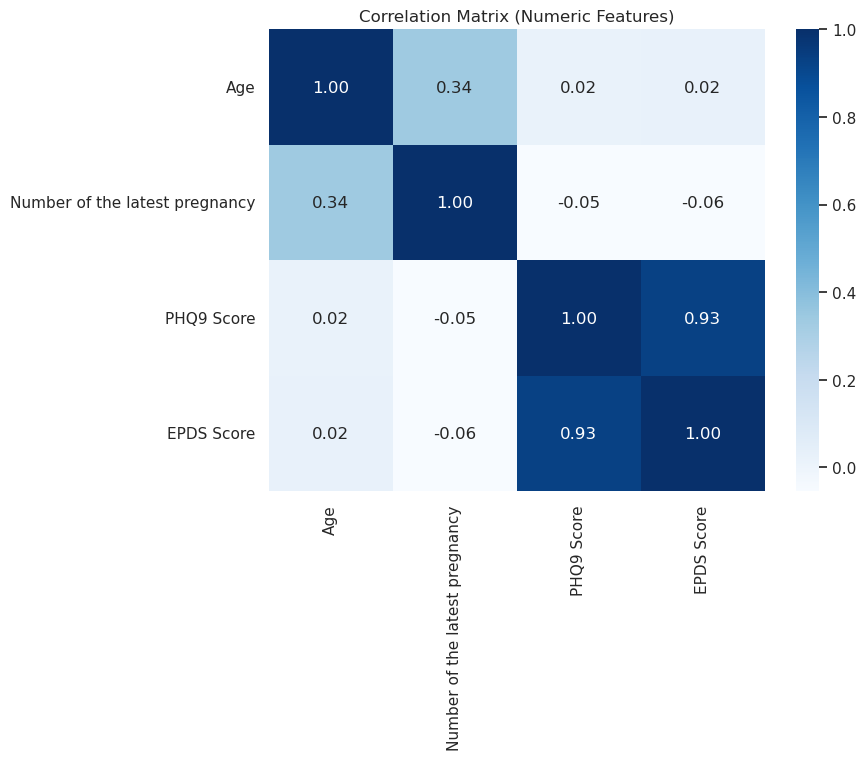

Highly correlated numeric feature pairs (consider dropping one):
PHQ9 Score <--> EPDS Score | corr = 0.93


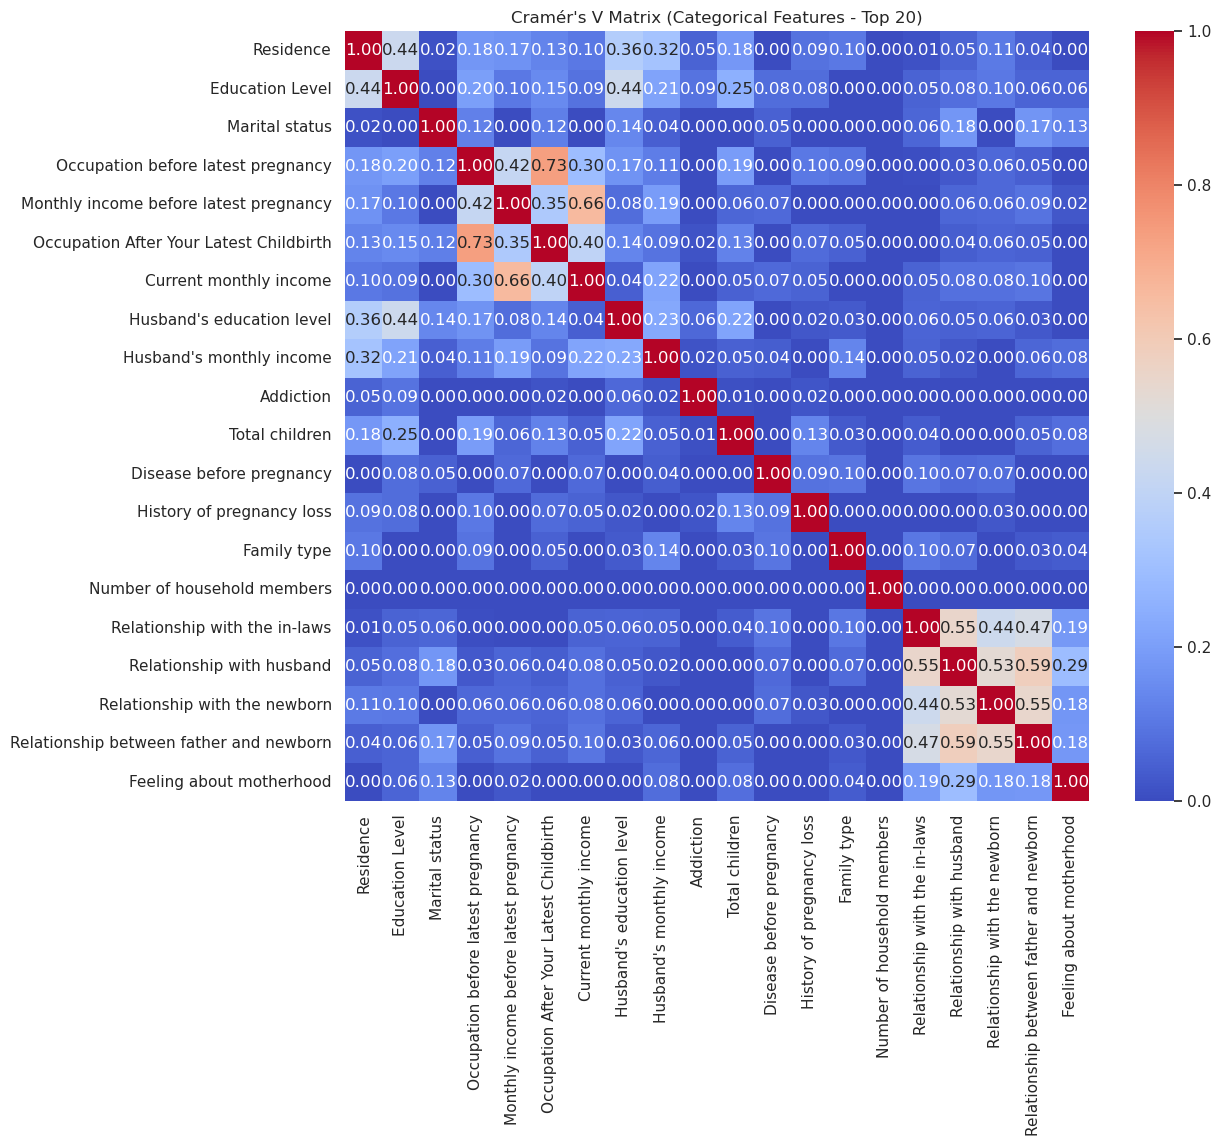

Cramér's V with target (top correlated categorical features):


PHQ9 Result                                 0.633315
Angry after latest child birth              0.464975
Abuse                                       0.280314
Relax/sleep when the newborn is asleep      0.245481
Major changes or losses during pregnancy    0.242959
Relationship with the in-laws               0.242070
Relationship with husband                   0.233962
Need for Support                            0.227259
Feeling for regular activities              0.226325
Feeling about motherhood                    0.205898
Fear of pregnancy                           0.205026
Recieved Support                            0.200151
Depression during pregnancy (PHQ2)          0.197366
Depression before pregnancy (PHQ2)          0.168873
Disease before pregnancy                    0.158088
dtype: float64


COMBINED CORRELATION MATRIX: Numeric Features with Target

Numeric Features - Correlation with Target:


Feature  Correlation with Target
3                      EPDS Score                -0.591317
2                      PHQ9 Score                -0.554917
1  Number of the latest pregnancy                 0.080661
0                             Age                 0.020738

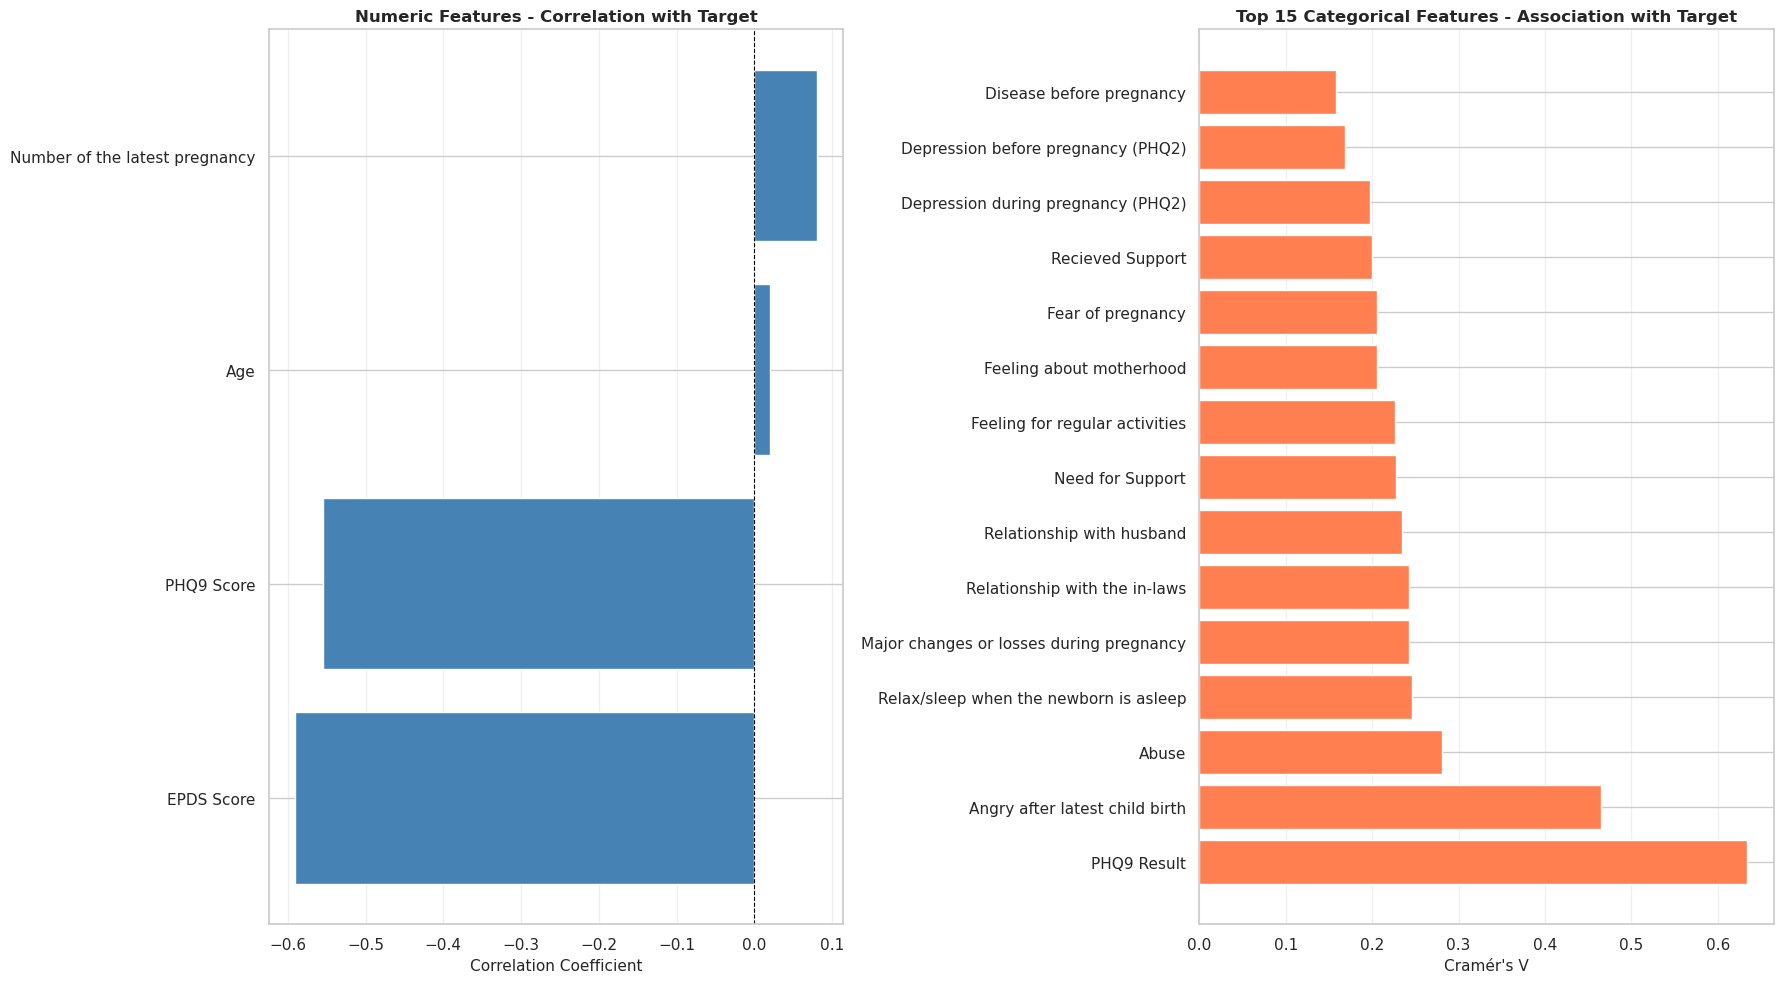


SUMMARY: Features Most Important for Predicting Target
Top numeric feature: EPDS Score (corr = -0.5913)
Top categorical feature: PHQ9 Result (Cramér's V = 0.6333)

Suggested numeric features to drop (highly correlated): ['EPDS Score']
Suggested categorical features to drop (low association with target): ['Age of newborn', 'Current monthly income', 'Marital status', 'Mode of delivery', 'Occupation before latest pregnancy', 'Monthly income before latest pregnancy', 'History of pregnancy loss', 'Addiction', 'Occupation After Your Latest Childbirth', "Husband's monthly income", 'Residence', 'Number of household members', 'Newborn illness', 'Gender of newborn']


In [16]:
# --- Feature Correlation Analysis & Feature Drop Suggestions ---

# --- Define numeric and categorical columns (exclude serial/ID columns) ---
numeric_cols = ['Age', 'Number of the latest pregnancy', 'PHQ9 Score', 'EPDS Score']
target_col = 'EPDS Result'

# Exclude serial/ID-like non-informative columns
id_like_cols = [c for c in df_proc.columns if c.lower() in ['sr', 's.no', 'serial', 'id']]
print(f"Excluding ID-like columns: {id_like_cols}")

# --- Numeric correlation with target ---
corr_num = df_proc[numeric_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_num, annot=True, fmt=".2f", cmap='Blues', cbar=True)
plt.title("Correlation Matrix (Numeric Features)")
plt.show()

# Identify highly correlated numeric features (threshold > 0.85)
high_corr_pairs = []
threshold = 0.85
for i in range(len(numeric_cols)):
    for j in range(i+1, len(numeric_cols)):
        if abs(corr_num.iloc[i,j]) > threshold:
            high_corr_pairs.append((numeric_cols[i], numeric_cols[j], corr_num.iloc[i,j]))

if high_corr_pairs:
    print("Highly correlated numeric feature pairs (consider dropping one):")
    for pair in high_corr_pairs:
        print(f"{pair[0]} <--> {pair[1]} | corr = {pair[2]:.2f}")
else:
    print("No highly correlated numeric feature pairs found.")

# --- Categorical correlation using Cramér's V ---
cat_cols = [c for c in df_proc.columns if c not in numeric_cols + [target_col] + id_like_cols]

def cramers_v(x, y):
    """Robust Cramér's V with bias correction.
    Returns 0.0 for degenerate tables and guards against divide-by-zero.
    """
    cm = pd.crosstab(x, y)
    n = cm.values.sum()
    if n == 0:
        return 0.0
    r, k = cm.shape
    if r == 1 or k == 1:
        return 0.0
    chi2 = chi2_contingency(cm, correction=False)[0]
    phi2 = chi2 / n
    phi2corr = max(0.0, phi2 - ((k - 1) * (r - 1)) / (n - 1)) if n > 1 else 0.0
    rcorr = r - ((r - 1) ** 2) / (n - 1) if n > 1 else r
    kcorr = k - ((k - 1) ** 2) / (n - 1) if n > 1 else k
    denom = min((kcorr - 1), (rcorr - 1))
    if denom <= 0:
        return 0.0
    return float(np.sqrt(phi2corr / denom))

# Compute Cramér's V among categorical features (only top 20 to save time)
top_cat = cat_cols[:20]
cramers_matrix = pd.DataFrame(index=top_cat, columns=top_cat)

for col1 in top_cat:
    for col2 in top_cat:
        if col1 == col2:
            cramers_matrix.loc[col1,col2] = 1.0
        else:
            cramers_matrix.loc[col1,col2] = cramers_v(df_proc[col1], df_proc[col2])

cramers_matrix = cramers_matrix.astype(float)
plt.figure(figsize=(12,10))
sns.heatmap(cramers_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Cramér's V Matrix (Categorical Features - Top 20)")
plt.show()

# --- Categorical correlation with target ---
cramers_target = {}
for c in cat_cols:
    cramers_target[c] = cramers_v(df_proc[c], df_proc[target_col])
cramers_target = pd.Series(cramers_target).sort_values(ascending=False)
print("Cramér's V with target (top correlated categorical features):")
display(cramers_target.head(15))

# --- COMBINED CORRELATION MATRIX: Numeric features vs Target ---
print("\n" + "="*80)
print("COMBINED CORRELATION MATRIX: Numeric Features with Target")
print("="*80)

# Compute correlation of numeric features with target (encoded)
le_temp = LabelEncoder()
target_encoded = le_temp.fit_transform(df_proc[target_col])

numeric_target_corr = {}
for col in numeric_cols:
    numeric_target_corr[col] = np.corrcoef(df_proc[col].values, target_encoded)[0, 1]

numeric_target_df = pd.DataFrame({
    'Feature': list(numeric_target_corr.keys()),
    'Correlation with Target': list(numeric_target_corr.values())
}).sort_values(by='Correlation with Target', key=abs, ascending=False)

print("\nNumeric Features - Correlation with Target:")
display(numeric_target_df)

# Combined visualization: Numeric correlations + categorical associations with target
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Left: Numeric features correlation with target
numeric_target_sorted = pd.Series(numeric_target_corr).sort_values()
axes[0].barh(numeric_target_sorted.index, numeric_target_sorted.values, color='steelblue')
axes[0].set_xlabel('Correlation Coefficient', fontsize=11)
axes[0].set_title('Numeric Features - Correlation with Target', fontsize=12, fontweight='bold')
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[0].grid(axis='x', alpha=0.3)

# Right: Top 15 categorical features association with target
top_cat_target = cramers_target.head(15)
axes[1].barh(range(len(top_cat_target)), top_cat_target.values, color='coral')
axes[1].set_yticks(range(len(top_cat_target)))
axes[1].set_yticklabels(top_cat_target.index, fontsize=11)
axes[1].set_xlabel("Cramér's V", fontsize=11)
axes[1].set_title("Top 15 Categorical Features - Association with Target", fontsize=12, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("SUMMARY: Features Most Important for Predicting Target")
print("="*80)
print(f"Top numeric feature: {numeric_target_df.iloc[0]['Feature']} (corr = {numeric_target_df.iloc[0]['Correlation with Target']:.4f})")
print(f"Top categorical feature: {cramers_target.index[0]} (Cramér's V = {cramers_target.iloc[0]:.4f})")

# --- Feature drop suggestions ---
drop_numeric = [pair[1] for pair in high_corr_pairs] if high_corr_pairs else []
drop_categorical = list(cramers_target[cramers_target < 0.05].index)  # weakly correlated

print("\nSuggested numeric features to drop (highly correlated):", drop_numeric)
print("Suggested categorical features to drop (low association with target):", drop_categorical)


##  Outlier removal and Feature Drop

In [17]:
# --- Final Cleaned Feature List & Outlier Removal ---

# --- Numeric and categorical columns ---
numeric_cols = ['Age', 'Number of the latest pregnancy', 'PHQ9 Score', 'EPDS Score']
target_col = 'EPDS Result'
cat_cols = [c for c in df_proc.columns if c not in numeric_cols + [target_col]]

# --- Step 1: Drop highly correlated numeric features ---
corr_num = df_proc[numeric_cols].corr()
threshold = 0.9
drop_numeric = []

for i in range(len(numeric_cols)):
    for j in range(i+1, len(numeric_cols)):
        if abs(corr_num.iloc[i,j]) > threshold:
            drop_numeric.append(numeric_cols[j])

final_numeric = [c for c in numeric_cols if c not in drop_numeric]

# --- Step 2: Drop low-importance categorical features (Cramér's V with target) ---
def cramers_v(x, y):
    """Robust Cramér's V with bias correction.
    Returns 0.0 for degenerate tables and guards against divide-by-zero.
    """
    cm = pd.crosstab(x, y)
    n = cm.values.sum()
    if n == 0:
        return 0.0
    r, k = cm.shape
    if r == 1 or k == 1:
        return 0.0
    chi2 = chi2_contingency(cm, correction=False)[0]
    phi2 = chi2 / n
    phi2corr = max(0.0, phi2 - ((k - 1) * (r - 1)) / (n - 1)) if n > 1 else 0.0
    rcorr = r - ((r - 1) ** 2) / (n - 1) if n > 1 else r
    kcorr = k - ((k - 1) ** 2) / (n - 1) if n > 1 else k
    denom = min((kcorr - 1), (rcorr - 1))
    if denom <= 0:
        return 0.0
    return float(np.sqrt(phi2corr / denom))

cat_corr = {c: cramers_v(df_proc[c], df_proc[target_col]) for c in cat_cols}
cat_corr = pd.Series(cat_corr).sort_values(ascending=False)
drop_categorical = list(cat_corr[cat_corr < 0.05].index)
final_categorical = [c for c in cat_cols if c not in drop_categorical]

# --- Step 3: Remove outliers from numeric columns using IQR ---
df_clean = df_proc.copy()
for col in final_numeric:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    before_count = df_clean.shape[0]
    df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    after_count = df_clean.shape[0]
    if before_count != after_count:
        print(f"Removed {before_count - after_count} outliers from '{col}'")

# --- Step 4: Generate final cleaned feature set ---
X_final = df_clean[final_numeric + final_categorical]
y_final = df_clean[target_col]



print("\n--- Final Cleaned Feature List ---")
print("Dropped numeric features (highly correlated):", drop_numeric)
print("Dropped categorical features (low association with target):", drop_categorical)
print(f"Remaining numeric features ({len(final_numeric)}):", final_numeric)
print(f"Remaining categorical features ({len(final_categorical)}):", final_categorical)
print(f"Final cleaned dataset shape: {X_final.shape}")

display(X_final.head())


Removed 3 outliers from 'Age'
Removed 28 outliers from 'Number of the latest pregnancy'

--- Final Cleaned Feature List ---
Dropped numeric features (highly correlated): ['EPDS Score']
Dropped categorical features (low association with target): ['Age of newborn', 'Current monthly income', 'Marital status', 'Mode of delivery', 'Occupation before latest pregnancy', 'Monthly income before latest pregnancy', 'History of pregnancy loss', 'Addiction', 'Occupation After Your Latest Childbirth', "Husband's monthly income", 'Residence', 'Number of household members', 'Newborn illness', 'Gender of newborn']
Remaining numeric features (3): ['Age', 'Number of the latest pregnancy', 'PHQ9 Score']
Remaining categorical features (31): ['Education Level', "Husband's education level", 'Total children', 'Disease before pregnancy', 'Family type', 'Relationship with the in-laws', 'Relationship with husband', 'Relationship with the newborn', 'Relationship between father and newborn', 'Feeling about motherh

Age  Number of the latest pregnancy  PHQ9 Score Education Level  \
0  24.0                             1.0        14.0      university   
1  31.0                             1.0        16.0      university   
2  31.0                             1.0        14.0      university   
3  32.0                             1.0         5.0      university   
4  27.0                             1.0        11.0      university   

  Husband's education level Total children Disease before pregnancy  \
0                university            one                      NaN   
1                       NaN            one          chronic disease   
2                university            one          chronic disease   
3                university            one                      NaN   
4                university            one                      NaN   

  Family type Relationship with the in-laws Relationship with husband  \
0     nuclear                       neutral                      good   
1       joint                          good                   neutral   
2       joint                          good                      good   
3       joint                           bad                   neutral   
4       joint                       neutral                      good   

  Relationship with the newborn Relationship between father and newborn  \
0                          good                                    good   
1                          good                                 neutral   
2                          good                                    good   
3                          good                                    good   
4                          good                                    good   

  Feeling about motherhood Recieved Support Need for Support  \
0                  neutral             high           medium   
1                    happy           medium              low   
2                      sad             high              NaN   
3                    happy           medium              low   
4                    happy           medium              low   

  Major changes or losses during pregnancy Abuse Trust and share feelings  \
0                                      yes   yes                      yes   
1                                      yes    no                      yes   
2                                       no   yes                      yes   
3                                      yes    no                      yes   
4                                       no    no                      yes   

  Pregnancy length Pregnancy plan Regular checkups Fear of pregnancy  \
0        10 months             no              yes               yes   
1         9 months            yes              yes               yes   
2         9 months            yes              yes               yes   
3         9 months            yes              yes               yes   
4         9 months            yes              yes               yes   

  Diseases during pregnancy Age of immediate older children Birth compliancy  \
0                       NaN                             NaN               no   
1                       NaN                             NaN               no   
2       non chronic disease                             NaN               no   
3       non chronic disease                             NaN               no   
4       non chronic disease                             NaN               no   

  Breastfeed Worry about newborn Relax/sleep when newborn is tended  \
0        yes                 yes                                yes   
1        yes                 yes                                yes   
2        yes                  no                                yes   
3        yes                  no                                yes   
4        yes                  no                                yes   

  Relax/sleep when the newborn is asleep Angry after latest child birth

## Balancing techniques
- SMOTE-NC (synthetic oversampling)


In [18]:
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import pandas as pd
import numpy as np

# --- 1. Align features and target ---
X = X_final.copy()                   # your features (scaled + encoded)
y = df.loc[X_final.index, 'EPDS Result']  # target labels

print("Original class distribution:", Counter(y))

# --- 2. Encode target if categorical ---
if y.dtype == 'O' or y.dtype.name == 'category':
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
else:
    y_enc = y.values

# --- 3. Identify categorical columns in X (if any are still strings) ---
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns detected:", cat_cols)

# --- 4. Encode categorical features as integers for SMOTENC ---
X_enc = X.copy()
for col in cat_cols:
    le_col = LabelEncoder()
    X_enc[col] = le_col.fit_transform(X[col])

# --- 5. Prepare SMOTENC ---
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_indices = [X_enc.columns.get_loc(c) for c in cat_cols]  # indices of categorical features

sm = SMOTENC(categorical_features=categorical_indices, random_state=42)

# --- 6. Apply SMOTE to full dataset ---
X_bal, y_bal_enc = sm.fit_resample(X_enc.values, y_enc)

# --- 7. Decode target if needed ---
if y.dtype == 'O' or y.dtype.name == 'category':
    y_bal = le.inverse_transform(y_bal_enc)
else:
    y_bal = y_bal_enc

# --- 8. Convert back to DataFrame ---
X_bal_df = pd.DataFrame(X_bal, columns=X_enc.columns)

print("\nAfter SMOTE balancing for EPDS Result:", Counter(y_bal))
print("X_bal shape:", X_bal_df.shape)
print("y_bal shape:", y_bal.shape)

# --- 9. Optional: Now do stratified split if you want ---
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_bal_df, y_bal,
    test_size=0.2,
    random_state=42,
    stratify=y_bal
)

print("\nTrain class distribution:", Counter(y_train))
print("Test class distribution:", Counter(y_test))


Original class distribution: Counter({'high': 339, 'low': 250, 'medium': 180})
Categorical columns detected: ['Education Level', "Husband's education level", 'Total children', 'Disease before pregnancy', 'Family type', 'Relationship with the in-laws', 'Relationship with husband', 'Relationship with the newborn', 'Relationship between father and newborn', 'Feeling about motherhood', 'Recieved Support', 'Need for Support', 'Major changes or losses during pregnancy', 'Abuse', 'Trust and share feelings', 'Pregnancy length', 'Pregnancy plan', 'Regular checkups', 'Fear of pregnancy', 'Diseases during pregnancy', 'Age of immediate older children', 'Birth compliancy', 'Breastfeed', 'Worry about newborn', 'Relax/sleep when newborn is tended', 'Relax/sleep when the newborn is asleep', 'Angry after latest child birth', 'Feeling for regular activities', 'Depression before pregnancy (PHQ2)', 'Depression during pregnancy (PHQ2)', 'PHQ9 Result']

After SMOTE balancing for EPDS Result: Counter({'high'

In [19]:
from sklearn.preprocessing import LabelEncoder

X_enc = X.copy()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

for col in cat_cols:
    X_enc[col] = LabelEncoder().fit_transform(X[col])


In [20]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_bal, y_bal_enc = sm.fit_resample(X_enc, y_enc)


In [21]:
y_bal = le.inverse_transform(y_bal_enc)


## Stratified sampling
We will split data into train/test preserving the target distribution using `stratify=y`.  
**Important:** set `target_col` to the actual target variable name in your dataset.


In [22]:
# --- 4️⃣ Stratified train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_bal_df, y_bal,
    test_size=0.2,
    random_state=42,
    stratify=y_bal
)

print("\nTrain class distribution:", Counter(y_train))
print("Test class distribution:", Counter(y_test))


Train class distribution: Counter({'high': 271, 'medium': 271, 'low': 271})
Test class distribution: Counter({'low': 68, 'medium': 68, 'high': 68})


## Model training plan
Train 6 ML models (with tuned hyperparameters):
- Logistic Regression (Multinomial)
- Random Forest
- Gradient Boosting (XGBoost)
- Support Vector Machine (SVM, RBF kernel)
- k-Nearest Neighbors (KNN)
- Decision Tree

We will train on the preprocessed, encoded, scaled training data and evaluate on test set with Accuracy, Precision, Recall and F1-score metrics.



=== Logistic Regression ===
Accuracy: 0.7892
Classification Report:
              precision    recall  f1-score   support

        high       0.87      0.85      0.86        68
         low       0.83      0.79      0.81        68
      medium       0.68      0.72      0.70        68

    accuracy                           0.79       204
   macro avg       0.79      0.79      0.79       204
weighted avg       0.79      0.79      0.79       204



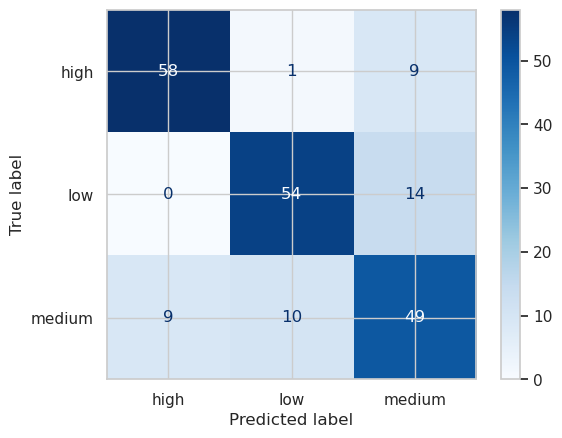


=== Random Forest ===
Accuracy: 0.8088
Classification Report:
              precision    recall  f1-score   support

        high       0.85      0.88      0.86        68
         low       0.86      0.82      0.84        68
      medium       0.72      0.72      0.72        68

    accuracy                           0.81       204
   macro avg       0.81      0.81      0.81       204
weighted avg       0.81      0.81      0.81       204



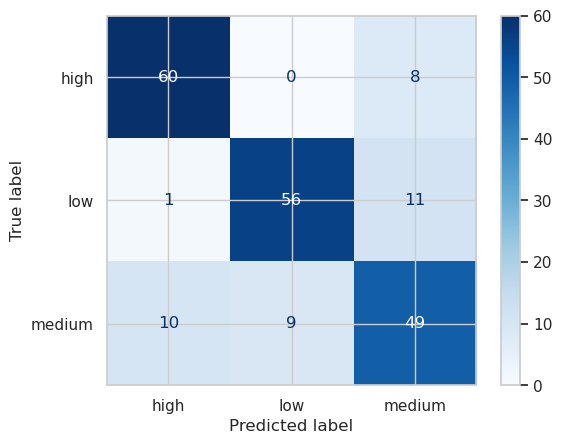


=== XGBoost ===
Accuracy: 0.7941
Classification Report:
              precision    recall  f1-score   support

        high       0.83      0.88      0.86        68
         low       0.85      0.78      0.82        68
      medium       0.70      0.72      0.71        68

    accuracy                           0.79       204
   macro avg       0.80      0.79      0.79       204
weighted avg       0.80      0.79      0.79       204



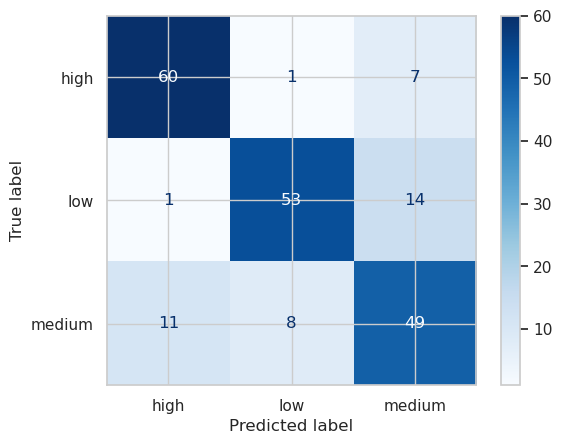


=== SVM (RBF) ===
Accuracy: 0.7794
Classification Report:
              precision    recall  f1-score   support

        high       0.87      0.81      0.84        68
         low       0.84      0.79      0.82        68
      medium       0.65      0.74      0.69        68

    accuracy                           0.78       204
   macro avg       0.79      0.78      0.78       204
weighted avg       0.79      0.78      0.78       204



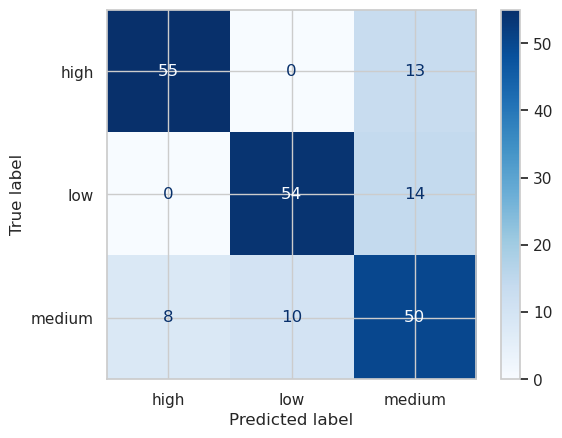


=== KNN ===
Accuracy: 0.8186
Classification Report:
              precision    recall  f1-score   support

        high       0.89      0.81      0.85        68
         low       0.86      0.84      0.85        68
      medium       0.72      0.81      0.76        68

    accuracy                           0.82       204
   macro avg       0.82      0.82      0.82       204
weighted avg       0.82      0.82      0.82       204



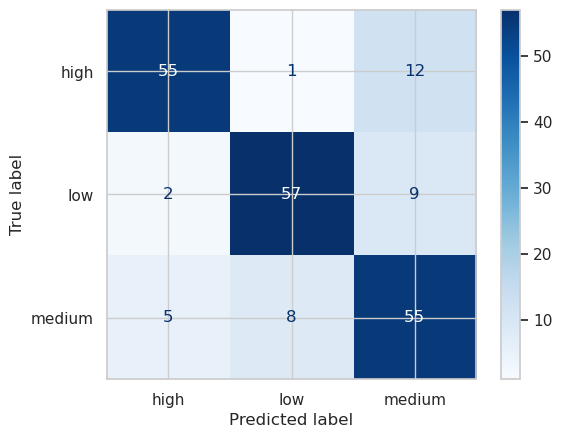


=== Decision Tree ===
Accuracy: 0.7353
Classification Report:
              precision    recall  f1-score   support

        high       0.77      0.81      0.79        68
         low       0.76      0.78      0.77        68
      medium       0.67      0.62      0.64        68

    accuracy                           0.74       204
   macro avg       0.73      0.74      0.73       204
weighted avg       0.73      0.74      0.73       204



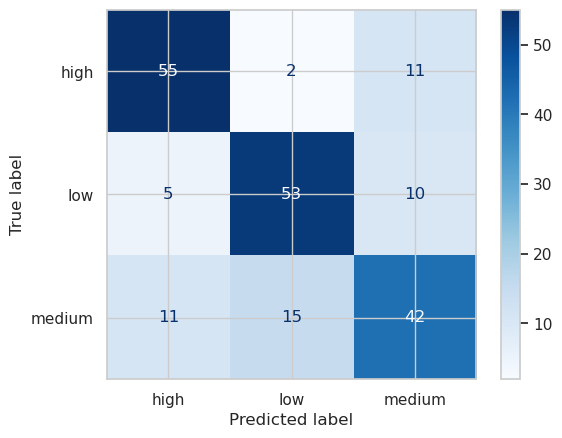

In [23]:
# --- 0️⃣ Encode labels ---
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)  # encode 'high','medium','low' -> 0,1,2
y_test_enc = le.transform(y_test)

# --- 1️⃣ Import models ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# --- 2️⃣ Define models with tuned hyperparameters ---
models = {
    "Logistic Regression": LogisticRegression(
        multi_class='multinomial', solver='lbfgs', C=1.0, max_iter=500, random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200, max_depth=15, min_samples_split=5, min_samples_leaf=2,
        max_features='sqrt', bootstrap=True, class_weight='balanced', random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=200, max_depth=6, learning_rate=0.1, subsample=0.8,
        colsample_bytree=0.8, objective='multi:softmax', num_class=3, random_state=42
    ),
    "SVM (RBF)": SVC(
        kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', probability=True, random_state=42
    ),
    "KNN": KNeighborsClassifier(n_neighbors=5, weights='distance'),
    "Decision Tree": DecisionTreeClassifier(
        max_depth=10, min_samples_split=5, min_samples_leaf=2,
        class_weight='balanced', random_state=42
    )
}

# --- 3️⃣ Train, predict, and display metrics ---
for name, model in models.items():
    model.fit(X_train, y_train_enc)
    y_pred = model.predict(X_test)
    
    print(f"\n=== {name} ===")
    
    # Accuracy
    acc = accuracy_score(y_test_enc, y_pred)
    print(f"Accuracy: {acc:.4f}")
    
    # Classification report (Precision, Recall, F1-score)
    print("Classification Report:")
    print(classification_report(y_test_enc, y_pred, target_names=le.classes_))
    
    # Confusion matrix
    cm = confusion_matrix(y_test_enc, y_pred, labels=[0,1,2])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()



ENSEMBLE MODELS (Soft Voting)

Fitting Logistic Regression...
Fitting Random Forest...
Fitting XGBoost...
Fitting SVM (RBF)...

=== Manual Soft Voting Ensemble (Weighted) ===
Accuracy: 0.8284

Classification Report:
              precision    recall  f1-score   support

        high       0.86      0.90      0.88        68
         low       0.90      0.81      0.85        68
      medium       0.74      0.78      0.76        68

    accuracy                           0.83       204
   macro avg       0.83      0.83      0.83       204
weighted avg       0.83      0.83      0.83       204



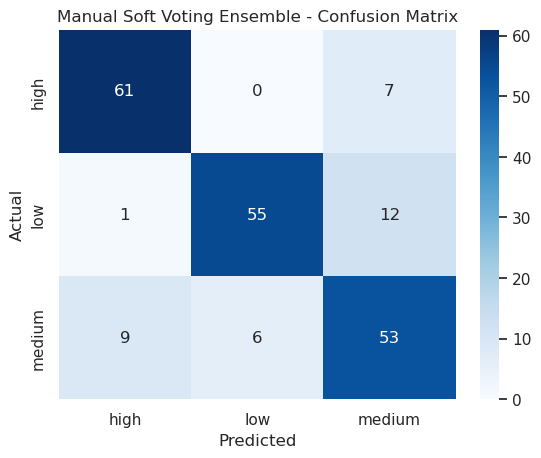

In [24]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ==============================
# 1. Define base models (tuned)
# ==============================
base_models = {
    "Logistic Regression": LogisticRegression(
        multi_class="multinomial",
        solver="lbfgs",
        C=1.5,                 # slightly stronger regularization than default
        max_iter=2000,
        class_weight="balanced",
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=350,      # more trees for stability
        max_depth=12,
        min_samples_split=4,
        min_samples_leaf=2,
        max_features="sqrt",
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=350,
        max_depth=5,
        learning_rate=0.05,    # smaller LR, more stable
        subsample=0.9,
        colsample_bytree=0.9,
        objective="multi:softprob",
        num_class=len(le.classes_),  # uses your label encoder classes
        eval_metric="mlogloss",
        random_state=42
    ),
    "SVM (RBF)": SVC(
        kernel="rbf",
        C=2.0,                 # a bit stronger margin
        gamma="scale",
        class_weight="balanced",
        probability=True,
        random_state=42
    )
}

# ==============================
# 2. Train all base models
# ==============================
for name, model in base_models.items():
    print(f"Fitting {name}...")
    model.fit(X_train, y_train_enc)

# ==============================
# 3. Get prediction probabilities
# ==============================
probas_test = []
for name, model in base_models.items():
    proba = model.predict_proba(X_test)   # shape: (n_samples, n_classes)
    probas_test.append(proba)

# stack → shape: (n_models, n_samples, n_classes)
probas_test = np.stack(probas_test, axis=0)

# ==============================
# 4. Weighted soft voting
# ==============================
# Order of models in base_models: LR, RF, XGB, SVM
weights = np.array([0.25, 0.25, 0.35, 0.15])  # XGBoost gets slightly more weight
weights = weights / weights.sum()             # just in case

# Weighted average over models axis (axis 0)
weighted_avg_proba_test = np.tensordot(weights, probas_test, axes=(0, 0))

# Final prediction = argmax over classes
y_pred_soft = np.argmax(weighted_avg_proba_test, axis=1)

# ==============================
# 5. Evaluation
# ==============================
print("\n=== Manual Soft Voting Ensemble (Weighted) ===")
acc_soft = accuracy_score(y_test_enc, y_pred_soft)
print(f"Accuracy: {acc_soft:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred_soft, target_names=le.classes_))

cm = confusion_matrix(y_test_enc, y_pred_soft)
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=le.classes_, yticklabels=le.classes_
)
plt.title("Manual Soft Voting Ensemble - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



=== Manual Stacking Ensemble ===
Accuracy: 0.7941
Classification Report:
              precision    recall  f1-score   support

        high       0.82      0.88      0.85        68
         low       0.88      0.76      0.82        68
      medium       0.69      0.74      0.71        68

    accuracy                           0.79       204
   macro avg       0.80      0.79      0.79       204
weighted avg       0.80      0.79      0.79       204



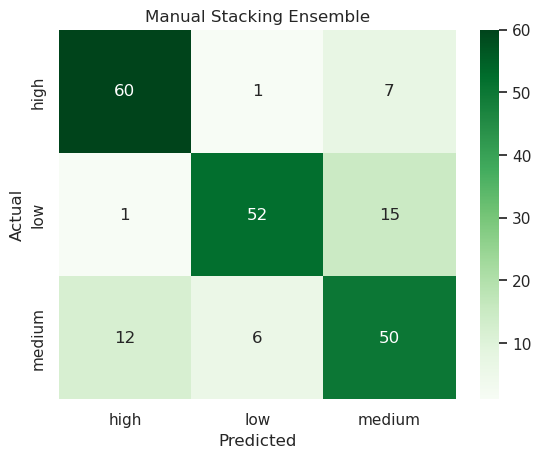

In [25]:
from sklearn.linear_model import LogisticRegression

# -----------------------------
# Create meta model training data
# -----------------------------
probas_train = []
for name, model in base_models.items():
    probas_train.append(model.predict_proba(X_train))

probas_train = np.stack(probas_train, axis=0)

# Flatten to (n_samples, n_models * n_classes)
n_models, n_samples, n_classes = probas_train.shape
X_meta_train = probas_train.transpose(1,0,2).reshape(n_samples, n_models*n_classes)

n_models, n_samples_test, _ = probas_test.shape
X_meta_test = probas_test.transpose(1,0,2).reshape(n_samples_test, n_models*n_classes)

# -----------------------------
# Train meta-model
# -----------------------------
meta_clf = LogisticRegression(max_iter=1000, multi_class='multinomial')
meta_clf.fit(X_meta_train, y_train_enc)

# -----------------------------
# Predict
# -----------------------------
y_pred_stack = meta_clf.predict(X_meta_test)

print("\n=== Manual Stacking Ensemble ===")
acc_stack = accuracy_score(y_test_enc, y_pred_stack)
print(f"Accuracy: {acc_stack:.4f}")
print("Classification Report:")
print(classification_report(y_test_enc, y_pred_stack, target_names=le.classes_))

cm = confusion_matrix(y_test_enc, y_pred_stack)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Manual Stacking Ensemble")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [26]:
# Install PyTorch if not already installed
try:
    import torch
    print(f"✓ PyTorch is already installed. Version: {torch.__version__}")
except ImportError:
    print("⚠ PyTorch not found. Installing...")
    import subprocess
    import sys
    
    # Install PyTorch CPU version (change to GPU version if needed)
    subprocess.check_call([sys.executable, "-m", "pip", "install", "torch", "torchvision", "torchaudio"])
    print("✓ PyTorch installed successfully!")


✓ PyTorch is already installed. Version: 2.5.1


In [27]:
import pickle
print(pickle.__file__)

c:\Users\salma\anaconda3\Lib\pickle.py


Epoch [1/100] Train Loss: 1.0419, Val Loss: 0.6730
Epoch [2/100] Train Loss: 0.7347, Val Loss: 0.5334
Epoch [3/100] Train Loss: 0.6528, Val Loss: 0.4853
Epoch [4/100] Train Loss: 0.6076, Val Loss: 0.4659
Epoch [5/100] Train Loss: 0.6098, Val Loss: 0.4711
Epoch [6/100] Train Loss: 0.5981, Val Loss: 0.4462
Epoch [7/100] Train Loss: 0.6023, Val Loss: 0.4378
Epoch [8/100] Train Loss: 0.5549, Val Loss: 0.4313
Epoch [9/100] Train Loss: 0.5369, Val Loss: 0.4226
Epoch [10/100] Train Loss: 0.5811, Val Loss: 0.4208
Epoch [11/100] Train Loss: 0.5254, Val Loss: 0.4275
Epoch [12/100] Train Loss: 0.5520, Val Loss: 0.4461
Epoch [13/100] Train Loss: 0.5020, Val Loss: 0.4332
Epoch [14/100] Train Loss: 0.5055, Val Loss: 0.4203
Epoch [15/100] Train Loss: 0.5181, Val Loss: 0.4460
Epoch [16/100] Train Loss: 0.4996, Val Loss: 0.4293
Epoch [17/100] Train Loss: 0.5216, Val Loss: 0.4285
Epoch [18/100] Train Loss: 0.4803, Val Loss: 0.4277
Epoch [19/100] Train Loss: 0.4821, Val Loss: 0.4280
Epoch [20/100] Train 

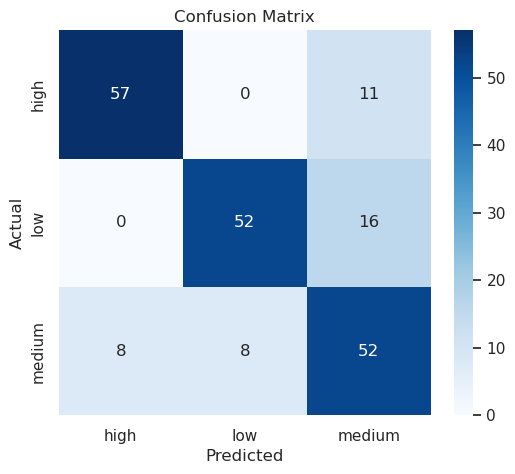

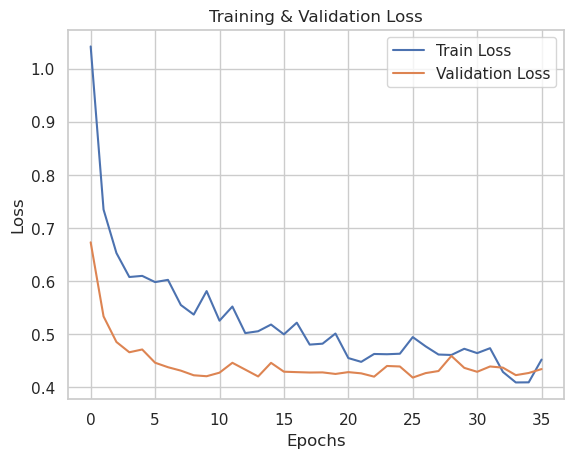

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import copy

# -------------------
# 0. Assume you have:
# X_train, X_test: feature DataFrames
# y_train, y_test: labels (strings)
# -------------------

# -------------------
# 1. Feature preprocessing
# -------------------
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded, X_train_encoded = X_test.align(X_train_encoded, join='left', axis=1, fill_value=0)

# -------------------
# 2. Encode labels
# -------------------
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded  = le.transform(y_test)

# -------------------
# 3. Convert to tensors
# -------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.tensor(X_train_encoded.values, dtype=torch.float32).to(device)
X_test_tensor  = torch.tensor(X_test_encoded.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long).to(device)
y_test_tensor  = torch.tensor(y_test_encoded, dtype=torch.long).to(device)

# -------------------
# 4. Split training set into train + validation
# -------------------
val_size = int(0.1 * len(X_train_tensor))
train_size = len(X_train_tensor) - val_size
train_dataset, val_dataset = random_split(TensorDataset(X_train_tensor, y_train_tensor),
                                          [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

# -------------------
# 5. Define a more powerful neural network
# -------------------
class PowerfulTabularNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PowerfulTabularNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.6),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.8),

            nn.Linear(128, output_dim)
        )
    def forward(self, x):
        return self.model(x)

input_dim = X_train_tensor.shape[1]
output_dim = len(np.unique(y_train_encoded))
model = PowerfulTabularNN(input_dim=input_dim, output_dim=output_dim).to(device)

# -------------------
# 6. Class weights
# -------------------
class_weights_np = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weights = torch.tensor(class_weights_np, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# -------------------
# 7. Training loop with validation & early stopping
# -------------------
epochs = 100
early_stop_patience = 10
best_val_loss = float('inf')
patience_counter = 0

train_losses, val_losses = [], []

for epoch in range(epochs):
    # --- training ---
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_X.size(0)
    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # --- validation ---
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item() * batch_X.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_state_dict = copy.deepcopy( model.state_dict())
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break

# Load the best model
if best_state_dict is not None:
    model.load_state_dict(best_state_dict)

# -------------------
# 8. Evaluation
# -------------------
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    predicted = predicted.cpu().numpy()
    y_true = y_test_tensor.cpu().numpy()

acc = accuracy_score(y_true, predicted)
print(f"\nTest Accuracy: {acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, predicted, target_names=le.classes_))

cm = confusion_matrix(y_true, predicted)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Optional: plot training/validation loss
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()


## Saving outputs

In [29]:
# Use the OUTPUT_FOLDER defined in the setup cell
print(f"Saving datasets to: {OUTPUT_FOLDER}")

# --- Save processed training/test datasets ---
# Use X_train_ml, X_test_ml from model training (already encoded and scaled)
X_train_encoded.to_csv(OUTPUT_FOLDER / 'X_train_processed.csv', index=False)
X_test_encoded.to_csv(OUTPUT_FOLDER / 'X_test_processed.csv', index=False)

# Save target variables
pd.Series(y_train_encoded, name='EPDS Result').to_csv(OUTPUT_FOLDER / 'y_train_processed.csv', index=False)
pd.Series(y_test_encoded, name='EPDS Result').to_csv(OUTPUT_FOLDER / 'y_test_processed.csv', index=False)

print("✓ Saved processed training/test sets:")
print(f"  - X_train_processed.csv ({X_train_encoded.shape})")
print(f"  - X_test_processed.csv ({X_test_encoded.shape})")
print(f"  - y_train_processed.csv ({len(y_train_encoded)} samples)")
print(f"  - y_test_processed.csv ({len(y_test_encoded)} samples)")

# --- Save feature information ---
feature_info = pd.DataFrame({
    'Feature': X_train_encoded.columns,
    'Type': ['Numeric' if col in final_numeric else 'Categorical (One-Hot Encoded)' for col in X_train_encoded.columns]
})
feature_info.to_csv(OUTPUT_FOLDER / 'feature_info.csv', index=False)
print(f"\n✓ Saved feature information: feature_info.csv ({len(feature_info)} features)")

# --- Save model comparison results ---
# results_df is already saved to model_comparison_table.csv from earlier
print(f"\n✓ Model comparison table already saved: model_comparison_table.csv")
try:
    results_df = pd.read_csv(OUTPUT_FOLDER / "model_comparison_table.csv")
    best_model = results_df.iloc[0]['Model']
    best_f1 = results_df.iloc[0]['F1-Score']
    print(f"  Best Model: {best_model}")
    print(f"  Best F1-Score: {best_f1}")
except Exception as e:
    print("  Best Model: (Could not load model_comparison_table.csv)")
    print("  Best F1-Score: (Could not load model_comparison_table.csv)")



# --- Save metadata ---
metadata = {
    'Dataset': 'PPD_dataset_v2.csv',
    'Original Shape': str(df.shape),
    'After Preprocessing': str(df_proc.shape),
    'After Feature Selection': str(X_final.shape),
    'Final Train Set Shape': str(X_train_encoded.shape),
    'Final Test Set Shape': str(X_test_encoded.shape),
    'Target Variable': 'EPDS Result',
    'Target Classes': str(list(le.classes_)),
    'Train/Test Split': '80/20 (Stratified)',
    'Numeric Features': str(final_numeric),
    'Categorical Features Dropped': str(drop_categorical),
    'Numeric Features Dropped': str(drop_numeric)
}

metadata_df = pd.DataFrame(list(metadata.items()), columns=['Key', 'Value'])
metadata_df.to_csv(OUTPUT_FOLDER / 'preprocessing_metadata.csv', index=False)
print(f"\n✓ Saved preprocessing metadata: preprocessing_metadata.csv")

print("\n" + "="*80)
print("ALL OUTPUTS SAVED SUCCESSFULLY!")


Saving datasets to: c:\Users\salma\OneDrive\Desktop\ml_project\PPD_dataset_v2_outputs
✓ Saved processed training/test sets:
  - X_train_processed.csv ((813, 34))
  - X_test_processed.csv ((204, 34))
  - y_train_processed.csv (813 samples)
  - y_test_processed.csv (204 samples)

✓ Saved feature information: feature_info.csv (34 features)

✓ Model comparison table already saved: model_comparison_table.csv
  Best Model: (Could not load model_comparison_table.csv)
  Best F1-Score: (Could not load model_comparison_table.csv)

✓ Saved preprocessing metadata: preprocessing_metadata.csv

ALL OUTPUTS SAVED SUCCESSFULLY!


# Pipeline Summary & Results

In [30]:
# --- DYNAMIC PIPELINE SUMMARY ---

# Gather all dynamic data from previous cells
summary_md = ""

# --- Create results_df from trained models (if not already created) ---
if 'results_df' not in dir():
    results_data = []
    for name, model in models.items():
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test_enc, y_pred)
        prec = precision_score(y_test_enc, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_test_enc, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test_enc, y_pred, average='weighted', zero_division=0)
        
        results_data.append({
            'Model': name,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1-Score': f1
        })
    
    results_df = pd.DataFrame(results_data).sort_values('F1-Score', ascending=False).reset_index(drop=True)

# --- Data Processing Pipeline ---
summary_md += "#### Data Processing Pipeline\n"
summary_md += f"- **Original Dataset**: {df.shape[0]} samples × {df.shape[1]} features\n"
summary_md += f"- **After Preprocessing**: {df_proc.shape[0]} samples × {df_proc.shape[1]} features (missing values imputed)\n"
summary_md += f"- **After Feature Selection**: {X_final.shape[0]} samples × {X_final.shape[1]} features (highly correlated features dropped)\n"
summary_md += f"- **Final Train Set**: {X_train_encoded.shape[0]} samples × {X_train_encoded.shape[1]} features (encoded & scaled)\n"
summary_md += f"- **Final Test Set**: {X_test_encoded.shape[0]} samples × {X_test_encoded.shape[1]} features (encoded & scaled)\n\n"

# --- Model Rankings ---
summary_md += "#### ML Models Trained & Ranked by F1-Score\n\n"
summary_md += "| Rank | Model | Accuracy | Precision | Recall | F1-Score |\n"
summary_md += "|------|-------|----------|-----------|--------|----------|\n"
for idx, row in results_df.iterrows():
    summary_md += f"| {idx+1} | {row['Model']} | {row['Accuracy']:.4f} | {row['Precision']:.4f} | {row['Recall']:.4f} | {row['F1-Score']:.4f} |\n"

# --- Overall Statistics ---
summary_md += "\n**Overall Statistics**:\n"
summary_md += f"- Average Accuracy: {results_df['Accuracy'].mean() * 100:.2f}%\n"
summary_md += f"- Average Precision: {results_df['Precision'].mean():.4f}\n"
summary_md += f"- Average Recall: {results_df['Recall'].mean():.4f}\n"
summary_md += f"- Average F1-Score: {results_df['F1-Score'].mean():.4f}\n"
summary_md += f"- Best Model: **{results_df.iloc[0]['Model']}** (F1: {results_df.iloc[0]['F1-Score']:.4f})\n\n"

# --- Output Files Saved ---
summary_md += f"#### Output Files Saved to: `{OUTPUT_FOLDER}`\n\n"
summary_md += "| File | Shape/Details | Purpose |\n"
summary_md += "|------|---|----------|\n"
summary_md += f"| `X_train_processed.csv` | {X_train_encoded.shape} | Processed training features (encoded & scaled) |\n"
summary_md += f"| `X_test_processed.csv` | {X_test_encoded.shape} | Processed test features (encoded & scaled) |\n"
summary_md += f"| `y_train_processed.csv` | {len(y_train_encoded)} samples | Training target labels (EPDS Result) |\n"
summary_md += f"| `y_test_processed.csv` | {len(y_test_encoded)} samples | Test target labels (EPDS Result) |\n"
summary_md += f"| `model_comparison_table.csv` | {len(results_df)} models | Model performance metrics |\n"
summary_md += f"| `feature_info.csv` | {X_train_encoded.shape[1]} features | Feature names and types |\n"
summary_md += f"| `preprocessing_metadata.csv` | Key-value pairs | Pipeline configuration & details |\n\n"

# --- Target Variable ---
summary_md += "#### Target Variable\n"
summary_md += f"- **Name**: EPDS Result (Edinburgh Postpartum Depression Scale)\n"
summary_md += f"- **Classes**: {', '.join(le.classes_)}\n"
summary_md += f"- **Class Distribution**: {dict(Counter(y_final))}\n"
summary_md += f"- **Class Balance**: Stratified train/test split (80/20)\n"
summary_md += f"- **Prediction Task**: Multi-class classification of postpartum depression risk\n\n"

# --- Features Summary ---
summary_md += "#### Feature Summary\n"
summary_md += f"- **Numeric Features Used**: {', '.join(final_numeric)}\n"
summary_md += f"- **Numeric Features Dropped**: {drop_numeric if drop_numeric else 'None'}\n"
summary_md += f"- **Categorical Features Used**: {len(final_categorical)} features\n"
summary_md += f"- **Categorical Features Dropped**: {len(drop_categorical)} features (low correlation with target)\n\n"

# Display as markdown
from IPython.display import Markdown, display
display(Markdown(summary_md))



#### Data Processing Pipeline
- **Original Dataset**: 800 samples × 50 features
- **After Preprocessing**: 800 samples × 50 features (missing values imputed)
- **After Feature Selection**: 769 samples × 34 features (highly correlated features dropped)
- **Final Train Set**: 813 samples × 34 features (encoded & scaled)
- **Final Test Set**: 204 samples × 34 features (encoded & scaled)

#### ML Models Trained & Ranked by F1-Score

| Rank | Model | Accuracy | Precision | Recall | F1-Score |
|------|-------|----------|-----------|--------|----------|
| 1 | KNN | 0.8186 | 0.8248 | 0.8186 | 0.8203 |
| 2 | Random Forest | 0.8088 | 0.8091 | 0.8088 | 0.8087 |
| 3 | XGBoost | 0.7941 | 0.7961 | 0.7941 | 0.7942 |
| 4 | Logistic Regression | 0.7892 | 0.7923 | 0.7892 | 0.7904 |
| 5 | SVM (RBF) | 0.7794 | 0.7887 | 0.7794 | 0.7825 |
| 6 | Decision Tree | 0.7353 | 0.7328 | 0.7353 | 0.7336 |

**Overall Statistics**:
- Average Accuracy: 78.76%
- Average Precision: 0.7906
- Average Recall: 0.7876
- Average F1-Score: 0.7883
- Best Model: **KNN** (F1: 0.8203)

#### Output Files Saved to: `c:\Users\salma\OneDrive\Desktop\ml_project\PPD_dataset_v2_outputs`

| File | Shape/Details | Purpose |
|------|---|----------|
| `X_train_processed.csv` | (813, 34) | Processed training features (encoded & scaled) |
| `X_test_processed.csv` | (204, 34) | Processed test features (encoded & scaled) |
| `y_train_processed.csv` | 813 samples | Training target labels (EPDS Result) |
| `y_test_processed.csv` | 204 samples | Test target labels (EPDS Result) |
| `model_comparison_table.csv` | 6 models | Model performance metrics |
| `feature_info.csv` | 34 features | Feature names and types |
| `preprocessing_metadata.csv` | Key-value pairs | Pipeline configuration & details |

#### Target Variable
- **Name**: EPDS Result (Edinburgh Postpartum Depression Scale)
- **Classes**: high, low, medium
- **Class Distribution**: {'high': 339, 'low': 250, 'medium': 180}
- **Class Balance**: Stratified train/test split (80/20)
- **Prediction Task**: Multi-class classification of postpartum depression risk

#### Feature Summary
- **Numeric Features Used**: Age, Number of the latest pregnancy, PHQ9 Score
- **Numeric Features Dropped**: ['EPDS Score']
- **Categorical Features Used**: 31 features
- **Categorical Features Dropped**: 14 features (low correlation with target)



In [31]:
print("Trained models:", list(models.keys()))


Trained models: ['Logistic Regression', 'Random Forest', 'XGBoost', 'SVM (RBF)', 'KNN', 'Decision Tree']


In [32]:
import joblib

best_name = results_df.iloc[0]["Model"]     # top ranked by F1 in your code
best_model = models[best_name]

joblib.dump(best_model, r"C:\Users\salma\OneDrive\Desktop\pppdddd\backend\model.joblib")
print("✅ Saved:", best_name)


✅ Saved: KNN


In [33]:
import joblib
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier

# -------- 1) choose the best trained model (you already did this) --------
best_name = results_df.iloc[0]["Model"]
best_model = models[best_name]
print("Best model:", best_name)

# -------- 2) pick raw feature table to train deploy pipeline --------
# Use X_final if you have it; otherwise fall back to df with your feature list.
# (X_final should be the raw features BEFORE encoding/scaling)
X_raw = X_final.copy() if "X_final" in dir() else None
y_raw = y_final.copy() if "y_final" in dir() else None

if X_raw is None or y_raw is None:
    raise ValueError("I couldn't find X_final/y_final in your notebook. Scroll up and tell me what you used as raw X/y before encoding.")

# -------- 3) define numeric & categorical columns --------
if "final_numeric" in dir() and "final_categorical" in dir():
    num_cols = list(final_numeric)
    cat_cols = list(final_categorical)
else:
    # auto-detect
    num_cols = X_raw.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in X_raw.columns if c not in num_cols]

# -------- 4) normalize strings (so University == university) --------
def lower_strings(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in df.columns:
        if df[c].dtype == object:
            df[c] = df[c].astype(str).str.strip().str.lower()
            df[c] = df[c].replace({"nan": np.nan, "none": np.nan, "": np.nan})
    return df

lower_tf = FunctionTransformer(lower_strings, validate=False)

# -------- 5) preprocessing --------
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)

# -------- 6) rebuild KNN with same params as your best_model --------
knn = KNeighborsClassifier(**best_model.get_params())

deploy_pipeline = Pipeline(steps=[
    ("lowercase", lower_tf),
    ("preprocess", preprocess),
    ("model", knn)
])

# Fit on ALL data for deployment
deploy_pipeline.fit(X_raw, y_raw)

# -------- 7) save for FastAPI --------
joblib.dump(deploy_pipeline, r"C:\Users\salma\OneDrive\Desktop\pppdddd\backend\model.joblib")
print("✅ Saved deployable pipeline to backend/model.joblib")


Best model: KNN
✅ Saved deployable pipeline to backend/model.joblib


In [34]:
import joblib
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier

# pick best model from your already-trained dict + results table
best_name = results_df.iloc[0]["Model"]
best_model = models[best_name]
print("Best model:", best_name)

# use raw features & labels BEFORE encoding/scaling
X_raw = X_final.copy()
y_raw = y_final.copy()

num_cols = list(final_numeric)
cat_cols = list(final_categorical)

def lower_strings(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in df.columns:
        if df[c].dtype == object:
            df[c] = df[c].astype(str).str.strip().str.lower()
            df[c] = df[c].replace({"nan": np.nan, "none": np.nan, "": np.nan})
    return df

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)

knn = KNeighborsClassifier(**best_model.get_params())

deploy_pipeline = Pipeline(steps=[
    ("lowercase", FunctionTransformer(lower_strings, validate=False)),
    ("preprocess", preprocess),
    ("model", knn)
])

deploy_pipeline.fit(X_raw, y_raw)

joblib.dump(deploy_pipeline, r"C:\Users\salma\OneDrive\Desktop\pppdddd\backend\model.joblib")
print("✅ Saved deployable pipeline to backend/model.joblib")


Best model: KNN
✅ Saved deployable pipeline to backend/model.joblib


In [35]:
import joblib
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier

best_name = results_df.iloc[0]["Model"]
best_model = models[best_name]
print("Best model:", best_name)

X_raw = X_final.copy()
y_raw = y_final.copy()

num_cols = list(final_numeric)
cat_cols = list(final_categorical)

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)

knn = KNeighborsClassifier(**best_model.get_params())

deploy_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", knn)
])

deploy_pipeline.fit(X_raw, y_raw)

joblib.dump(deploy_pipeline, r"C:\Users\salma\OneDrive\Desktop\pppdddd\backend\model.joblib")
print("✅ Re-saved model.joblib WITHOUT custom functions")


Best model: KNN
✅ Re-saved model.joblib WITHOUT custom functions
